# Создание и обучение сиамской сети

In [1]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt


def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)


set_random_seed(42)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
!pip install unrar
!unrar x /content/dataset_red_2.rar
x_train = np.load('/content/x_train_red.npy')
y_train = np.load('/content/y_train_red.npy')
x_val = np.load('/content/x_val_red.npy')
y_val = np.load('/content/y_val_red.npy')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/

UNRAR 5.61 beta 1 freeware      Copyright (c) 1993-2018 Alexander Roshal


Extracting from /content/dataset_red_2.rar

Extracting  x_train_red.npy                                               65% 78%  OK 
Extracting  x_val_red.npy                                                 97%  OK 
Extracting  y_test_red.npy                                                97%  OK 
Extracting  y_train_red.npy                                               97%  OK 
Extracting  y_val_red.npy                                                 97%  OK 
Extracting  x_test_red.npy                                                99%  OK 
All OK


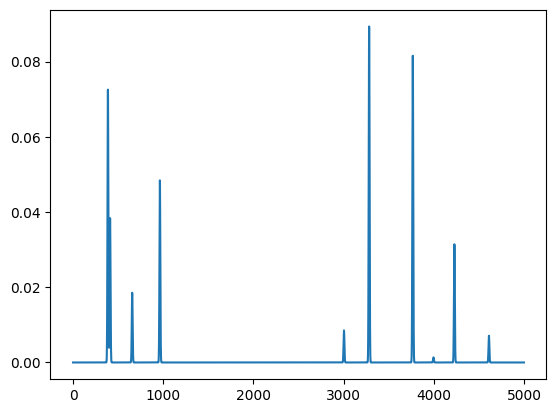

In [ ]:
plt.plot(x_train[0])

In [3]:
from torch.utils.data import Dataset

class SiameseDataset(Dataset):
  
  def __init__(self, x, y, transform = None):
    self.x = x
    self.transform = transform 
    self.y = y.reshape(-1)
  
  def __getitem__(self, idx):
    anchor = self.x[idx]
    same_class_idx = np.arange(self.x.shape[0])[idx//20 * 20 : (idx//20 + 1) * 20]
    other_class_idx = np.concatenate((np.arange(self.x.shape[0])[0 : idx//20 * 20],
                                      np.arange(self.x.shape[0])[(idx//20 + 1) * 20 :])) 


    positive = self.x[np.random.choice(same_class_idx)]
    positive = positive + self.x[np.random.choice(other_class_idx)] + self.x[np.random.choice(other_class_idx)]
    
    negative = self.x[np.random.choice(other_class_idx)]
    negative = negative + self.x[np.random.choice(other_class_idx)] + self.x[np.random.choice(other_class_idx)]
    if self.transform is not None:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    return anchor, positive, negative
  
  
  def __len__(self):
    return len(self.x)

In [4]:
from torch.utils.data import Dataset

class ValidationSiameseDataset(Dataset):
  
  def __init__(self, x, y, transform):
    self.x = x
    self.transform = transform 
    self.y = y.reshape(-1)
  
  def __getitem__(self, idx):
    anchor = self.x[idx]
    same_class_idx = np.arange(self.x.shape[0])[idx//5 * 5 : (idx//5 + 1) * 5]
    other_class_idx = np.concatenate((np.arange(self.x.shape[0])[0 : idx//5 * 5],
                                      np.arange(self.x.shape[0])[(idx//5 + 1) * 5 :]))
    
    positive = self.x[np.random.choice(same_class_idx)]
    positive = positive + self.x[np.random.choice(other_class_idx)] + self.x[np.random.choice(other_class_idx)] 
    
    negative = self.x[np.random.choice(other_class_idx)]
    negative = negative + self.x[np.random.choice(other_class_idx)] + self.x[np.random.choice(other_class_idx)] 

    if self.transform is not None:
      anchor = self.transform(anchor)
      positive = self.transform(positive)
      negative = self.transform(negative)
    return anchor, positive, negative
  
  
  
  def __len__(self):
    return len(self.x)

In [5]:
def transformation(x):
  x = x/np.max(x)
  x = x + np.random.normal(0,0.005,x.shape[0])
  x = torch.Tensor(x)
  return x

In [6]:
from torch.utils.data import  DataLoader

train_dataset = SiameseDataset(x_train[2000:], y_train[2000:], transform = transformation)
val_dataset = ValidationSiameseDataset(x_val[500:], y_val[500:], transform=transformation)

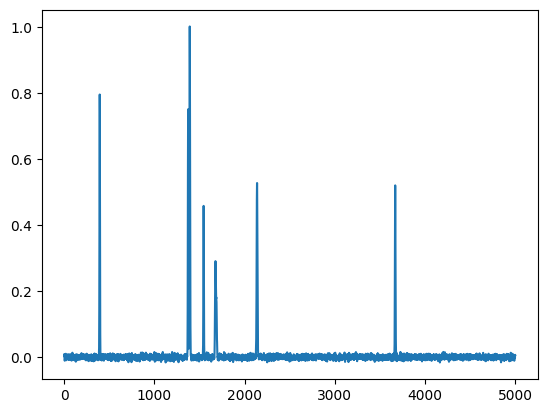

In [ ]:
val_data = list(val_dataset)
plt.plot(val_data[0][2].numpy()) #example of processed data

In [7]:
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)

In [8]:
from torch import nn
class SiameseNet(nn.Module):

    def __init__(self, latent_dim):
      super().__init__()
      self.latent_dim = latent_dim
      self.model = nn.Sequential(nn.Conv1d(in_channels=1, out_channels=16,kernel_size=21, padding = 'same'),
                                  nn.MaxPool1d(kernel_size=2, stride=2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(16),
                                  nn.Conv1d(16, 32, 11, padding = 'same'),
                                  nn.MaxPool1d(2, 2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(32),
                                  nn.Conv1d(32, 64, 5, padding = 'same'),
                                  nn.MaxPool1d(2, 2),
                                  nn.LeakyReLU(),
                                  nn.BatchNorm1d(64),
                                 
                                 nn.Flatten(),
                                 nn.Linear(64*625, self.latent_dim))

    
    def _forward(self, x):
      out = x.view(-1, 1, 5000)
      out = self.model(out)
      # normalize embedding to unit vector
      out = torch.nn.functional.normalize(out) 
      return out
    

    def predict(self, x):
      out = x.view(-1, 1, 5000)
      out = self.model(out)
      out = torch.nn.functional.normalize(out)
      return out

    def forward(self, anchor, positive, negative, latent_dim):
        output1 = self._forward(anchor)
        output2 = self._forward(positive)
        output3 = self._forward(negative)
        
        return output1, output2, output3

In [9]:
def train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim):
    loss_history = []
    l = []
    l_val = []
    n_p_train = []
    n_p_val = []
    
    for epoch in range(0, num_epochs):
      model.train()
      for i, batch in enumerate(train_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss, number_pos = criterion_train(output_anc, output_pos, output_neg)
          loss.backward()
          optimizer.step()
          optimizer.zero_grad()
          l.append(loss.item())
          n_p_train.append(number_pos.item())
      
      model.eval()
      for i, batch in enumerate(val_loader, 0):
          anc, pos, neg = batch
          output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
          loss_val, number_pos_val = criterion_val(output_anc, output_pos, output_neg)
          l_val.append(loss_val.item())
          n_p_val.append(number_pos_val.item())
      #scheduler.step()
      last_epoch_loss =  torch.tensor(l[-len(train_loader):-1]).mean()
      last_epoch_val_loss = torch.tensor(l_val[-len(val_loader):-1]).mean()
      print("Epoch {} with {:.4f} loss and {:.4f} val_loss".format(epoch, last_epoch_loss, last_epoch_val_loss))
        
    return l, last_epoch_loss, l_val, last_epoch_val_loss, n_p_train, n_p_val

Будем расчитывать loss только по триплетам, которые дают достаточно большую ошибку (hard triplets и "сложная" часть semi-hard triplets).

![Diagram-a-demonstrates-a-triplet-violating-the-triplet-loss-condition-i.ppm](data:application/octet-stream;base64,iVBORw0KGgoAAAANSUhEUgAAAtoAAALMCAMAAADtv+WHAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAMAUExURf/Jerffsf/Lev//2fvJtf//1+Xl5f//1f///wAAAP/NfP//2///5P//0/8AAP//3f+6eAcGBf//3//Ugf/Pff//4f+3cv//+///6P9kKP3Pvf/ahP/Rfv8SAQ4MCf7MuP9rMQICARQTEP+6df/0x///7v8JAP8cB/78+iIhHf/70P/VwPzErhxwIP/JeP/Fgf3Jtv83G/++ev/Xg/9+Rv/Afk1NR/24nP/ShP/twP/99f8nDv/EiP6qif9mMf/r2P+iXUNGQCojHCedG+np6fT09P9OLB0XEP+/c/+zbv9uM1A/Kv/axP9DJP/OkRwaGP/20f/lsjw9M/+FSbCxlP/Hjf/Fdy4uJv/Tm//VrjExLhiaFOHivq+vr2NOL8HovD4xHv9zNv/hv/v71P/v4oGBcfG+c//27f+wZ/n4zv+ifvPGdk6SSv9bOv8tE/92Pf+oYfLzzP94QvvLt8zMzP9oLP/NnM+kYv+2eP+Ucf+EX//bqKiET//ly//di//GmdCnlv/KhPzIsnd3Y/+RaK/Yp//RpvvHeCKbGGxsXOGza3R0dJx6Sdzc3P++fDiAM2NZQ/9vUaOfhvz49P/DfJGRfv+VVVtPSHdePfzrvP/mwDw8PP9bKdrgtrOQWfC/rDMnG/+NVcXEpNfX187NrGBgX/+7etqsZ//greLi4rPbrih5Kbzkt+7ty11eU8GYW/Hx8Ts1MIGBgf/cut7Abv9lSEY7KoW6gO7u7v95Tf9uO7i8nINmPo6ghf794P6hbf/45qChlWxtbI1uRYOuRP+9i9TVsqiHeP/ZoP+xj4iNdKOjo7q6uv/atOrrw/+HTo2GfLzascSdjbyyYJKSkmakQWpiVOCzoT6ROP+FUrjEoUykK6W0VMDAwMe+Yuu5b8TExJZ3arK7XP/qzMegYOfnw7eTg6eUgPvNe4BlW7rjta6KVbLRnf/LplNXSD6iJNTU0Le3t+lzQf7+2VeeRY5wZcbywrCLZZucgXaub6SDdFBkRv/Jgb2WiKDHltIgBzbLyp0AACAASURBVHgB7L0NeJTVmTeeTToM8xEmk2TCaELahAQSbEkhJvKlGMpnKSCUGEiBugyggYLGIgQRKcVC+XRBcYkIIkLAbgFBtKywaQVlKQi+/120u/UD3iq9aHmles3uXnRftu//d9/n4znPzCQklIQM5JlknvP9nHPu33PPfe5zn3MSOrZf7T1wU/ZAwk3ZqpZu1BcnP274ER/nulz71jQc3x7TOj3QDu1r6OdzlYX7G872bm6Oq/KVhuPbY1qnB9qh3fx+nlzmch1pONu7ua6cynau3XAHtVJMO7Sb39GrXI1C+6Tf5SpsCrRfOXny5McFzX9+e44m9UA7tJvUTWaigv2A9iozxO7+srKwsLQpAsnk7Bz/pYP2zO2+69YD7dBufldeBdoHv5j7xcsFTSh2Ml6RTYObkLA9ybX0QDu0m91rxLVzGpG1m1pgh/2QXNqh3dTuana6dmg3u8s6xubaBUOaWdKXZTmunNKDzczVnrypPdAO7ab2lEw3ZPBgHkYOHjz4VQoqOAhXAb6/PDm3AwUVvEpRBZy8QNzYHfV1ZowrZ8z+5r4QUcW0BzTQA+3QbqBjGggumFy2qRAy8phNmzb9L0pz8EjZptKXXz6yqbKictOm/QUd5+4v21S2/yDnf+XdRoaTR3JcrtJ2DQl3VEt8tUO7wV7tcGb//jNRo7z9OUAkhG3cSilrhwpXjuvkGYjNCHSVFXScXAFXaQcu9uPSHftPFnR8eT9fZ162PesI0q0Cm2+/WqYH2qFt9euQNQctT8eOc8eAOc81Q8j9ZdkmhDPX5hnJDptcLv+eMgRRKILO5Lpc2UfEKzEZr8Gmgy8fYeC7co98bL4pBG0uIvIR7f7r0gPt0FbdOOTg5B3vKg/dPwaEC6OgPaRDB2DSv0PJ2gRtl9/vysblPwMmvB9wzl0loQ1Mb3p3h0B2To6/Yr/g5vwYFJPTDm2zx6+vux3asj8H7y+tzJ1sdG6H/bmu7D2xZhUJvHrKZjBB2+UvPTkZF0nWqwDkijMHuaTJcOduwlfZ/jMM8MJVllDSTK7dPt40iNMU5y0L7bln+PpYdRJkZpdrh/Z27DgZkNz0bixA7UdKDW3m2q5NVkaK3TT5GQHtbHhcrspVXx58BsPLXJefRBZ5kaLF8qnQWPeXUdXJQwpiRbWHNdgDtyS0n/nii8mXwEtxlX05V6B3yBEY7JlWT2cQuyNmv0VDO9eAKMWWfiEyEteGVPOW8J0rxRMqz73KvoIOexBl5OtY8PJczGMaEot++FtUZKyXTKdod0T3wC0J7XcrC8cw6CDtFhaeFL3SgbjoHg2gAkA7Jya07bORJJD4j1hyC8VCEhdlTgbXzvGfVIWehCY7p1Iw+A77IcrbZO13KysKCytWze1YEEGmg1SzdmhH9MpVvTcLtIec3G8bAzbW8MlAo3Htg3qOLlLgFa7SiuhmcO3syaIELsbk6cS1K2hsKa6DbxXiuZPZswaVyNkn3Ah4Zv8OUavcsh07vpDpxa3gTCV0LqvU+2GLa/c03AM3BbRfmXxyf6Xf/HFvuMEdhzCyK3bwVZkDrEmG+HEpeOwYxX+JVZpyhlUi8WW7rJ39ZQOxxLU3FViRQ8oAUpF4DWT77DNK/FizHynV5d9xzsqC6c1SvASlgteb4e3uxnsg/qH9ypq5+8fk+HNy9MjO1uIhHdasWaMQRDGvEJwLTxbQNeQkMcQjkiGyInvyq5y9gEaRl2wQ08XaoE0CiQlt08LkmTPZ0J2IAjk3Jxac+mU8eYwqfw1pviEb0UUyTKnSORZ0gGizA5g/o5/e7mhiDyQ0MV2bTTa3tLKC5lDsQzKruidLKysrzZ/4NYVgxycl3oYApqvWFIjkLyPGXyFE7yFHgMozMYUA5tpH1BOgIckxoW3y9Jcxl75JijucntQpuWdYe8LQVghelYv6l52jYeRc/FrgfZA/Hq/uOPIqQ1uORNVT2+9X74G4hvbBM0dW4ddaXDFY7ORVq44ATASVVeoHvcOZMTmFFmZfOWNNfw9+C5xU8sdXITr4BX+N6kQb1ya0mtA2uTaJPmpEyaVQYr+wL1ljcW0eUbpKpVTzMmQrDGBFfQ/uy96xqhAWgnKsG1WX9oAGeyBuoV1w7svJmFSB3Qb9lJeV2uVTtPfgx9ZwEYkunROq5rl7sl0VBictMLuGfvqPzKWgIfTKxMaTyZc7dowUSMzYM4X4LTEfwO/BKhaPXoasLQWSuWhGtqUZH3IS2dQbRm8mau8/MvnLuQdRr/aryT0Qn9CG3ejkTZjZBt1d/tzcijOvvBopO7x6psIPTGTn5o7J9VMyaRm9Bj/+OYVfSqvTiH5ahRL9OyiQoO2PDW2TL8M8qhGuTWND2+DW4NrnNLSHQCdom9EfsgMVF6/EqztyuZHUkB1KfImodLs3dg/EJbRfhiEp6zaIpe04+fG5g1GNG7KqkCILT36Mi5ixq1KMJYcQpjA/yLw5MtuaVYgrLUDwmjJXjsVIbelMvhwNbTP2CEqLgnY2/2QMmVyouPZkCCCuCgwX9XUGVbx0rgD+gi8+hlk3Xzk7rDl6nbLd0XAPxB+0O+zfD5kCfA1XxZH9Z87Fatzgk/iRd13aL/ju3EvwFErTpFcK4XFll64SlqYwXDUgQ6Z6hftf6fjKqjGuMW+ZihXjKfuR/0iBDIgUSEyeHhvaLMF/QW3Yx3yYTFJgFXjGYspf4F3MXSWfMLiQYldV5LwV+cNkVKndGd0D8QdtUi3QlV25qfTMQUn/yIad25Tjyi7TYJm7Dz/rhWJOp8MOQr1x5R45p0FzrhRSTO7cjufGYNpwTWSpwk982b/jVRkZKZBEcG27tv1VLb3Qq5crpG6aG8KVvYN+YM7xQ+kJUtt+kMWVNR3P7OHWPPMFpUK6c4Nj1649VPVA/EF78P5CAMGfW3pu8GANSdUcdee5ki+UDwaqeB+kHqPg4BEhpBOe+Mqu0LOJz8xFwtx3C2hzswZ3gALwXHsUq4+EdiTXPnLQqkXBy/tUNU6ijMovuf60+peuHAwLxozBezbkFbIelNCeDMkrp+yVjkMGF6CgIV+WjhmTSxfGFw223nrireyKP2h3HEzKi7IzBnCjCUgz3GUG6Qs0u0TaNZNPAmLmVclCAhVzELan/rKPz0HAbYhrdySBvFIpWSIFkgiunVO4/1Vdvbl78MaIH4+3UEYpM15SrRtX7qbS0tJCBFwS1SeevknOI3Us2C+HGDkop2y/0Pno4tsdth6IQ2h33EPUbkB7IRvHTFH/ZA+evL8QiwW0mRIsVlcdkRehDaKzeg2GfEngOUnzOpu0OYmtx2Bsgsjs0slz55IR39W4Nq0pUxdJ8mMgyeOiCl4qgKNgLjWnkuqzg8aTfNEitR0WtHdQDrroYa4xpUiJBLADsCQpEd/+bfRAPEKb5+4YF0ZD7M4v92EK8iCHFbwy90wl6QFz9pyzJ2LfmiOkgSj7skDFkTCwHwJuoVy6q8Kt+xe0qsC/aUfpDgjGkdCO4NpArV7ZO5hEj7KDVFABQ5vAW0Bz/cKYdvDJS5g5rRBGidlC+2czQDz4VoXLX7jqi45DTpZW4JX0l8ZqEZXffnXsGI/QfvkIwBDDyLPAIuirZDhCfqww31GBMSSpVLJtijiVeLBQZh9UfproGVOY49rR0BC14zOsfnFl+wu/iIY2iyurRGFUT5e/UgxfCwavgkW4X/4+xIJ2R7J3efmLk6W5WFQs38NXV6EIxbXPgVkXnqSaDnnlCxpy+JUaRVW+/W71QDxCuyPJn3IMZrWk48kdO8S4zAh7ZdWOMrBKoBr6tAa2fPq4DLC3dnE6uB/pCTVGMRFOVo0jDVQpHcmCT9qpcqpXCc8mtFH2jlVfHDy5Yw+tdSgV+nQWsMXbSQKJmCaSTxkyF9tcnhQrJIbsx4J5bYD4LpqiK/oKDFQa+WmJqPIt6I1LaBPLy9U6CqLayydPngG3LbPbbJ87STwP6u8d+w/S6yARh2HkSaXgQN7JUBSOMQd7QuTVBlDRqOhwZscebDZyiYy7B++/tMecJ1xDojPnFeto9mHuJweGIKgdLlXBuTSLJAaKLME09DAyZcnRNgTv4uenUC677Njx3B7CdgMayuhK33IhcQntyRgUKgMM/DhD+DhC+4LgMiFS8DKxY1d2YeGZgoKO4MU5QhldgPk9/yqtXShYhVR7IFqoazCtf3E1YCMrExUc/OLduUL3+Cq2j9KFgYvvx0at+ynZQZpUdJ05B+tYoJtrIuZoEEdR2XLah34l9ughLyI7sChFRUTM938MOQmWgwc5CvtGoOCKdmjL3oi6xSW0D5IBUe452ZgzmyorSZqmy4T2x4Qp/NZ/wb/tBKB9QkdCIoNinx0LPgbTthkxFazZhwSFZ6L6yh5QYPcqH6RgucDxFRaFzhR8QdyVrh3n1AauBVwFaepHvyfmmPXlUmUEKKCdozWTYsirVw6fy4Vc1pAaR9Xn1r3HJbQ7kkWonybO392PKWjGDexFVp0587FFyY/LEJ67X+m/Cdr+PTx1TrjK3cTbJrxy8gjWmUesORgCFYy53NEqs1kusu3zbwIuz4nF88ZMOtsVym14Os7d4wdE1YsKCQcC9X7BjIeco7fspHosTyiBUwv9YUcY5J5RhucqSftd90CcQpvgXLjqy8nKWjsbEx1Yg1ig21WwhqRZY7dIgrbkcZMJLzku2ImeZCMqv17UIrK/CgOSbI0nXWRzHfT+SekBC3qMukFvc6Z0k/Wz8G4hpJMdk7/gB0DzAaRni3d0zQ7ITlLDQrEF+0kkgTj1pUjc3CrdUunjE9odSkH+HD/2awKhXdljcnd8/KrdTPVVEpjNtbIC2swMYXXH+fxYdQak5KqtFRThB0NGt60uUBHNu/M6GgHRqIxDDs7dr6PWwFQKG1DteAU7Uq255EeVcjaJYS5tYDXG3HdwyBkycvVT4oKoQtsDbD0Qn9B+Zq5i10B24f53PzYUHqJ5gyHo+s05GravE0phWGKQDCCvTablH2emufOGVtjYOq9xD6kF9erH6KSWAUzBF2yxlb1pU9mmTTxqKBOqv46kEqm0MeiDX+InBVd2qV0ZFF3+LR8Sn9Du2PGIAub+/SdjjaRokjDH2nmh40lWvvk3QRNN1znswnpkxxGya43ShXeEfZ7fkn1Fhmv4ti3sbTz/3DNYiqmvwh1ygNmRrLQ2CdNaiDTiWvNWGacsM2T3xku/RWPjGtowJZpsk2EtIjK0NymIDMHOwH4ybHUd0fy94GAHYaVhZRKuIScrIAU0YKsdmbgR/1W4tj3nwSObNu0rzPbnVmJzbq0J/BLQ3neQU645+eXHkpd/XMaa91w1DrWX1O6TPRCv0Ka1Wa5NLx80NMo2mg6GyJHjX0Ub5RUMGTIZP+Klc3f4c/yFwjTDltbyDHl1CCXGZn/XQZQlDUmuFqith8R2QTv+8skdpaveNU11aUa/8uUhxLHfLcwdI9e5Fwz+mMYaWOL5auyy2kOpB+IV2mvIiqmsYRoWnCNpvHDHuwc7TN5RCi4HLcjcI5fOnJQSScycBWfKSksvkbnSpusAGt77ocnQpgrh7DK1cYSoH3Ht3LJVJ6EPp+PKLDNbsaXDvnMxm9EeyD0Qr9DuSPYUhVL9G5OW+4EF8GrargF6EN596eXGcI1CCt4SqhNX5VuxZZWYD2oo8OD+I0caq2BD+Yzwj1kCxw7HQzpicQVWeh5UkWto5HkdxrqqvJvwHrfQngzS2va20cQpWLOGeO7JCvrR5inu7MpI/Z5OHOGgmUG8Mm9FBN8o79zSMTlUH0gec7Ftm3/TF7omr2BcfB00lLq8m88Rt9Cm1Y8x2VbBuR08Uf3qu6XZhAukOvJyLCVKLGKehKY7Z0ybkWGHvHJmE35yys5hyp2WthlYjlzdE6s1t3ZY3EJ7MM27iI0PDAq+evLIjk1+/xkOOgdzQExF28z8jLSxnGvInnTydZBGYhV+LWGvvotGTD6IrK8C2jllapJ0zRH8apnGtNdS+M2dJ26h3XEIaa5tExevnMSGrcym2fKOCQcNSkGzKFjQzPTNKvyvSfwqL3euPHPyy5efOfgxGWtHTaP+NcXffHnjF9oH6YwBZYLdEQL2F6tyxcy5a4zibTcXveRmO4VHJp9ho0Y1/3RztfK6tSZ+oY2dzwBtZcV6DpatPORC2JiTes7juvVTWyhoMC+jBLcuZCMpw/arLdSuzdUhfqEtbPvoiLBX9q9aBYsmvnL2QLpuaB6nzfV+MytUMPnMqn2inVi9cPKLZma/xZLHL7RxQiOoXLhq8pe8wh1u2rAV+6wW3MwkHHJyD/YpwWUuWruZG3ztbYtraGNCQ1u2YsPWyhgbtl57z7TRnAUwBsAnamfaNlrdG1iteIb2y4a5nH/PyY/bN6C+gUBqe4+OZ2h3JBMLumjD1mYZa7Q9OrTX6Lr3QFxDm0wssvdhw9ZXr3u/tBcY9z0Q19A+V5idu+cL0wo07unR3oDr1gNxDe2D706efBVjvuvWUe0FxVsPxDW0462z2+vbmj3QDu3W7O32Z7ViD7RDuxU7u/1RrdkD7dBuzd5uf1Yr9kA7tFuxs9sf1Zo90A7t1uzt9me1Yg+0Q7sVO7v9Ua3ZA+3Qbs3ebn9WK/ZAO7RbsbPbH9WaPdAO7dbs7fZntWIPtEO7FTu7/VGt2QPt0G7N3m5/Viv2QDu0r7Wzp02bNpD/I1ZiPvNgv87XWmZ7vuvYA+3Qvmpn4rQOcdlSTps3YEDJOyVFAxYPtIU/M3XZdwY+iAzt+Lb1S+t72qF9tT5/cOKyZfPwWbZsmpF04Ly6K0V0Lek98UEr/JlFy8pLyhcj9cJFVmi760b0QDu0r9Lr0yb2XnKFrj5FpwSGO3fu3K/fqWdLUviq6/3O1GA+X/36dR64uKSo91pCfJ9yGzcf+OnURVMXLZrWzsuv0t/XL7od2lZf9ntw2q/o82CBFdZx4rO96/jqXbf4036d+wHEQa/XO3ZtTYa8SnYlexwORygcrs/vWyfwjhwpi3+F5BBMCM2/Wla0FmElywYaLN54Srvz+vdAO7R1nz64aHH5O+XvDBi92JA8Ok8sqqvhK6Pr6L5JHnwAY0e474S1NYTiuoya48k+ujxhp8NXOyBFpK6pqRudlxoG3L35nTtOW/xsUQmuurWjl7VjW/d4yzraoS37tzOk5LorS4quFPWpmziNOTOYszeway2Y8wj+7PLAHwik+jyepOS+CyeMnoDr+K68JGcyXU5Hki957OiUESOQfMSI8rz6oDeQGnb6Avl5a3uLF6FkSYlNZG9Z4t7apbdDW9F/YtGzQppIqRvd1wMU8xXIWzi6nDE8YUKeR2I42el0Onrk9cUnL88RdpKf0Z2c5Kg9ToCfMGH02LADcHc6k3yBYPg4A75rSteaovL7+uUr9WDBtE8/XbTo00XtnFxR4Treb1Vo93sQl9ZIY2T4zDwgu6YmoyZjRN3xvCQWO0j0cPaoqu3bI5k+jFRCMXAswCwcFMDwRiBCkJDSchDncTiSekwoGVBSQuL5gF33+ZwBgJtGo58uLoEIXlJyapquynWk7S1e1C0K7WmnykcvnrBMAqqf11cfHp3RtaamK/5HlNT6HJILA6DgvcmOcBLEZgdhmiGb7Aw5kyFbO51hRrozGX7COSDvQEq6UAR5KQdueX379l04oCZj7fE8X8DjdHggndeH5tWUQAYvWvtOuwh+/d/DWxHaA187taxkANR5dRMH5gdxpTqDQW/fCQNSBkxYuGvXwrE9khiOxITlRahNJvyKP0ZxcggIV4FAMbwWmOUbwAFURtjjCeeNRdl5eFecSakk7eQ7R49ghUrKs33qFhVcf+Le2iXeetDu/OC8PldKIFbXpHTtPdbH40KSipOqxk7YlZdM/Jm5LeGULu2RwKUb82jJrzmYUvGHYsQlknFKUQj4uUezfuLnST2Or6UBKkaYdSWnfkVKwvbr+vXArQftft8ZAAE3JaUrxOqiWl8SLhY/gDWIyCEnxGsBUpI6SPCgD90ESoWfQzhG+VUqBIoXQuaklDINhBV8KBdCRKKFa+tQGcjgA/qGgyx/E2kLMAx4pl+7+P3XwfwWhPZEAnYKBowjSsb2IEkaFzNaSMkEOvoQLukuPPwtPUruoDBGr/rSUOY3QmahMigh/7FbuMQDnZ682r59d42uGbH2OKZ9fKmpwfoC0HPqhHmL501o14C3Q/sqPdB54GtqzrtffjD/V33LoXUeUTP6+PGxIY9ENcObIC7ALBEpcClAjiCBeARaKFYp9F0I3MorxW/DS1m5APGgMEaTodqFUI73cPhI/E7yBvOD89Ixsb+kbuLURe2c+yrEbST6JufaBTA7XbT42XkDCzr269cvv96Z6kv17BpQXj5gQm2IlBiMOvrSnNXgsIohI9oIhY8+ArZGEhHMcUYCmY5DRAr59sifBkRgrge6FtzpSvIEkibw6LKuZMmAqe3YbgS8jUfd1NDu3G9ReXlJSUrvZ8un9fMlYSocigqPo0ePPHx6sNwLREWjFhBsiDELQJtAlW5dCqWIyE1eIyPl4BQC6pDuWb7HewbUJ3lSAW2arU/pDZNZ9XvTOBXbY2P0wM0M7YJFn5evXVJU0jul94C+3iTMkovpRNJUeJIAMIlKgTDxbSCQncJvhyqFiRAjiSjLnlCnk0/gWHxZqUTxIi+xbUK3I3lXidCb1BRltEM7BmibFnRTQ3veEtg2YcjY9aG6HkGGDdiiAjTfNcjIoXCmA21wRag9QiU3cooM9G2WZ4WaLlUYiqE/ihIyiSM5b9fx46NLMCAomXcfLA2bRsn2VBE9cDNDu9+8K5g7x+Q2WeF5BG6IMQqAyRs8BkZVoAyKEdMUfCvUitKoEI30WCUKVCMNakIX3r6wM+94+YCSCX0dHkcYs/IFIFvnB2F0225tEgHghr03M7SD857FvAz+BmAqhvED3JCWmYEmmXA0DAXybYC3J+L86iWw3ZFOJ2WH9slCObVKZUaK6gHUrAXHPH1yFUyv8pwenyfZ4UsK9OvYcdqy8tHlcjlEwwRtj1E9cLNCuzN0aDCqhm3pwrFja3uwFZ782Rcos0ESQWCnkqNGMFbLS1DUPnIwNiVQdURkwaY/OpGZW8IbE/jEupMw4uWxgSPg9Sb7gvXL6pYsWVIyb+Kp9qVpCr2N3m8maD8z8NNPB9IyAqj5vM58r89XC9tSML4wgYZxSA7jI6AWHSMhaCDRcJoFxHJTUlEkZ8KX+BNpOYyc2iHLkH7E6D8hQxHOHanBpNEZGDasLbrSZ/RA8PD262o9cNNAG1aqmEEvqVs2rXN+2EdT2qQrJsEVd0KL9RFIs0HL8iicyxC+WbFcCrwqRKXmwuGx+Y1HqngZFCs7RVklqBTcAkQ5fcmjadSQgmVoReW/uhpZ2+M7drxZoP3ga/NGD8B62951tfVJjkCqUPM5IbQyZBS0oqBnBJDT8FI+84MoTqECFfhsPFlFavDrVFZMhEuWi5dQf0QtkBWCN4rncEePsQMyWN1ds+QdY4VbO4gb6oGbBNoDJw4oWfIsNH0jevfND5BhCIAimDUD0uCnAjcMFw0hDSrhkHi033QaC4I2lwIxFRqZk/zWw2QN5E0UYuSyPYi5NoXAeKt24YS1WJzWtWtRu7a7ITwb4TcJtCcC12TzNALGfElCDgEebCAxcWhDlQVFAhCWGAQC3lSZWSaMSG+EKkCbpUe4rSRWMZHY1zW1koggrpEIdCYl5S0sH11SV3L8viA2hjCo2O6M0QM3C7SL1tZ0rclIqYOej2RrxgUhwsIVhdmAY/OIpJy6+vT507tDkbGiKITKiIh49lqxUQ+jAPpgwY4nKSwrKAPtdRRPQBgFy5sIw6gBNgIL5+3q4XAEwvlYgUYELejXPqiMAeybRdbuPLE3JmdgzbcLyxgZMAZcFEoEkGzI1MixXgGn77dl48atOA2+bWYwypPhRrwd5lah9BqIOCM7bexAeW0RMo+9oIgH0fsQ9jiq8nqEkzxe/AWwDUTHjq8dP9VuQxUL2zcB1y7AIrC+E7pCg72wFlbPAIABpEh4sD8SQWZ6h3e9y+WqPO3lYswYhWULl/Yn2UuNzon4kNO3+cT06Zcnhc3C7G57MUb9ZQRsqSCAJzsDQZ/Hm1//2jtYB/f8p7Foe4uHxTu0sUdZMJTq8/WdUD7Wl6REEYm+CJREeO2Igo/R6PSOz3a5xp0OWKBSKKX85BblqFBbMVcLdAYPofRB21OJBYvEMWplPgiJYhSK3LgcHm/ekq5YfbZk8cD2NfGRb3KcQrug4MFpz9DPcT62u3HgL7lHVXJYrP2yY4VwoaBiuGSwPYZQ5CBo+8edN6DNILeXSkF86TgTfzKtVbjGsYB2xWZZushkVNEsBZmMjyzMSgDO7UgCtKHr7l2SUjRgakEkbW9xf3xC+5lTC+fNWzawczDo83l9rOsDrvErbYDKgIUJkau5AW0/uPYkxVcZSxagdHbwTHqVwH3lMw2HTqTqoPM7vYdyc1yVm722JDYP59FliiibFx7y48nJyb6+JSPITKZ30ZLRr7Vj2/YyxyO0By46VdOn6MqVZWFnPmnpmIESIqTGTiKF8GTDhAhPdtJKLT1KFIFWOggkflfOuEkBWYpCp7ijTEyhhGmrBU9V9ekqD+w7YFOoPk5swuBDPWgvBp/SPeqyyRHclgtJfhKgLYI16FUR/ARdKSTS2fVTZFJqb1LVwvI6rIaD4nNJeTu04x3a0+Zdoc1Tu2bA5JOXgDG6QW+GicSKBRmBDuPbeX779u3n1XCTkMPoESmcQtauPBQCR/b4sN4MH1bW6RIx570ZJRwav2HD+t9u235sNxQeXAJuKPq8wxM+vX37sdPY7k+JyczhCZHEtQHtzRikWh+ULP6soBguVUmRUT4Q6xZqJwwoSsEU/JL2ZcI2ZMfhRPu0eUXPrqUtzDIWJik2d68QQAAAIABJREFUTfAkJiY/GoUqwLx7HCcKCwunn6atbuRHOxDgqD80xuXK/eBYKqwFQ6EQ/ZMdCqUR5ToC2y+hhDG5ubnDcC+8DAM9fq8cjs0oekM4fH56YWHFhlCYflBQLTZnoW+8LeHxgmvzIyU+uWxZvpBxKMQWGdPD1aHlcGPLM2q6Hs/ztiu4TXDHnUAybd7aIvz+dh2RUV5LgGMMaMprRxQ4NH58jhXQ7o05Uc3aZR3MWKPCAtsqKP5QMOi5vEdc66sCYRmPycrQW2U5SCGvnJyKE0liVBh2HCpzuaZXX75UiMjCFeOrgWXoogNBz6Rt23enYpcqZ9Vl0r9Y4o6twkB+wEuPEu+QgLdyR4BdVtyJOaBwct+xu8bmeSAnta/IscAdd9AeWN4VK2dG1JVPGNvD4tMaeBoAEjO4scv6CjvHjwM0950PMDqAHAIPxTOInOFJS8FY/duqD10mjNNVceLQ6bB8RKpj/D4E5ZZd2rPn0p5Cii5cv5tFFk/yBvg3bK+kQJcr+3I1+LYvUH1o/eUVl/ZMX79+W8B7qNTvcpVOoneBq6Qey89O9iHt+M2QhYz2qBQqyFZbEcjbrjmSkwKe+vz8Aou4t7Yr3qDd+cHXBvSuWVsyoZZ2xxE8WwABSFFgsRwRGCEkQAC+DGheOg1o6wxGOkeYsJk9fnwhXgBx5fjHbcfaSnqCI8TIhcDSI1QVDk0fBqS6Kn7rpbfM41gKz4oTUB6OwdtRuB2h4arN6yv9oiR/6STvCThzl1pzncaDQ87w7vUVOWW/rUpCPSOqJrziBdB54JUhQuaBNONwBDH/jrVm1ja0tyrA4wzanb3BHrsGlOzqi9lm8DZNau1QvE3cVTADQ305guP9Y6Yfi+KNCk+B8+NcrpxSYu2AIeQHXP5DQRbNnd5tFJ6z4XxSampqIPX8+FIkyB7vpVifcwWS5g5zuS6NP1HoKsNgMRweP64QgeLyl24+AVfZtlCShK6soLh5PJcLXa49+AnQtUeEaoPlELHGN7cMfizNwZYUPi+O1JkwYeKtzr7jCtq8eCa1x9ixVUkegTSmL1PWgoMdNZHsD+l8xzasP0/acM5D0EEJViFegrYLGsDCFdCBXN4wHeDNKR0fTkJCR3C9K8dVeGJ3kMaIycne8HhILQrajhXI6PJfmr4t6fT4E4eqkzxVhzZx0AcbNkwf5wfm6WtFVRKLUuKRGrrJnhDlX+rxxRS0RAMpj6yxCJA1F2URulO9jucXP7ukT8mpU7e27WtcQLsfMSBMqacGwR0xLhPIUKTVdwskOkigV4AXgSJFMjgutnOnl8MCtEoZSmauDYRWnDgfDKTWB0NLC4G4FUlY3UDKO8gp+6qDJNgwtnfjPcglrg37EObaropDPhTvqcema97QHkA5p2LFJG/QOX6HlN2X0prHiA9qllRFo9CcpWHWiJs1Q2SMtlFQRCqEJCcneY5ndMXmr0VLcCjULcy62z60Oz8zbeqifgWd8x2pOE+D4GWo4kBaQd0I0rM3kvYMJ0qO322fowpzLzZ8ySKcgmu7Ki6fxjausEH1VbEIjYNqkNy3eWnZmEvV9eTGO5YUrAa0sw8JgURw7XGnvdCM8GZnoe378FZUrq/2YD/Y5BAp/nAReG1PJl9SOFhN70HF+qQkBeRYjYrOaQ+h3lmYgvU4Kb17lwwwz7QEe7ilrrYP7YHzFg94Z9l9XsiQSQCjxITJrmy01WA3QmVinYcmJE8f2hxWZVlMEUkU196zOxXPw+XxTic8gtUCas6qSdu3HauCRoTQ6/PlM7TH8zBSytorqgKcLxmCeRkJMxuqA1Rzz69C64lv56xgaFNtUCDBl5xJvvzTeEv8J06zxlDVXqaQNaWnihDKpj6yJPJzsLPqeFeefseRC7ewTNLGoV3wnamLryx5tvfo5CAUGoLNEiXtDJdD8MV3SXCT9ormCgzh6vXTV5RuC+I9MbPIaO95YrWupQEIBvQqeTxLcyCQVLMUgU1BoHrG9HrQm3r6EAxUSVrJHk9FOYXGvHQb5moIg04I5mDDY5aexxCU684sHiU7ogSScDXKWoq5ouxtnaW+3VYz9mCCn1TjqhVoofgzAoTTg7OlSkZgAXxRzS28sUPbhvYzi0qu9IZ9xIiSPB5bWXQVBAbFbQjQZDepbaYQWPBOAvfMWR+yirO4J8ZhPIzMmU4SCBXo8RDXvrSZ5SAEeLyOzdtwHTpBY0K6lEDCsvYJb1hUAwYjZB9bdppsobgkKeqQ2I6KmJ/USaU5eH9Q1Iljuz2eWK3Cpva7t23bbOPpZhHSTa11JmHzqQF1GSN6D/j01l1n1qahXfAabb+ASfURA/LCxKglyQkXJmDlD7EMVazMQA+M9OjDWhWkEnx5zzZPOFZBgdOXgLHcDc4kxOIT9kBT7Ro3HlIItI0OZ6hq+yWaZc+WwCauTbJ2SHDt6alkL4WHkwIdScZVa4MRlEz4XRpmrk0tQDL8QXTZXClLyx13eVKIKopD+zjOamhwW+GYPZjQoeK5ZpSTPlSEPQS17Du6pGbA2NCtOz/ZlqFdsGjAFRwlirnHAbWYeQQNiZAWDRkUthCic4xPmE6swaXkAE81/fbnntCCgSqJM1uxouwkVjdnyzVlqc71e8Zl5wgeC568geZ35DCSufZ0bGWGcuiEsm2lQDJGlQp8KBkDycLLWBxp1hItgkAyfoUEd2HZoVRIMElkXiWTiTbn/9YP45bzqTovB4s4ESbaQSHOcHJeLbbNwv60t6plSZuG9ikcqpgCY5EJY4WmTtNUkdwAOuhpEll4KBASavWhDXxtl6Yg4dB2YswrwoY9KvgxHeZLkKyiqfScpaztwyOTkrbR7Lgw/AifX49IXNnjPliBa9vpMubahELJtXl/Y/zGeBykEc/9YLfWh/iqNwxy5VzaBtxZLeBxA/h2P1p/k0vMe9AhjEq9k9ZvpgNIdMqwY9sHlAK23txQW2utZNqFPVh80Ch5HYFbdF1wm4b2wHl1XbHL6tgeJomJdgRZTUNNfA4hxmWL83k2X4bqga5LmyEsUKwnzEqPVAYdgRqmq6nh6mPbJ9HoL3SMgL9UaPvAAB2nNwBTbIkKe2uyEPEXVu7BjAxs+byk1mC9tpqNZK5NNfA4SWkIQSZJVdWzG5OUOdMnSXkZVRVsluIxR0oPWb+nogxmVY6k3SfGrDhWhWqxUS0SJPnWF9J8kGVaRdlEU0VJojAOwRcqjheDqu/14QAoOvzp1loe3Iah3blfuLaoBmeIhkhIZrrRlyAmHAoXgq4UYP+wCIPlsZtLsbCFr+zSSfVMbk+AlR4k8wLYEExxC52+XFm4YjN8SSGOJa4tHsZG1hVgl9Ka2z9u/KTzVXQOjSdIY04IJFFcG0hnNfelY7CplgWlnl6RDcGc6mBvRQglh1kwn3R+8+YqSCOOtypduSs2w6IWFwR8gujuy7k5pduFgYCV39boyGCqVlKqE2ZTHQsWTfzOLSWbtF1o5wehDR47dmwerea10c/0GbQkp2BcwkHjMCx13M5DN4FtCAPQtIBr+4ih7sNUCvhaarD6BBmvXoLaJPfEaV+yLxU8PUdMP9KDeWlMTgWWxjiTNhPqK8aHg/VJyIr5RnDtHAwjaciXyliernbP9Dk+QDEfnJczTCgpcBrCt1+8BxEtSnKwPWJZdb4XGhbi+JBMph9bShVbug16SLSsvhrGg/KFFdlFc40+EF0jAiiS/vCi4DTj+ya+s3b0sltJzd1God0ZRyrlQ/DFPrxhBQJBRyJeFC0FRQ26wnQ5kFztCQbC5wHibLZArcAPvmt8PqlawkkwsXPllOHH3eHc/tb0YQL5+K445sVDCVdSj0Fvi14aE3bwpEtZFSbaARnALHXSPs21PVV7UMJ0IWsrrk3Q5hag0l5OLGyp+C20GiJYfMVlftkwbeRdgaI+mI73CK/HpfHVgDtO4gnQQlDVftEfsgirJH6YfMcplPmCI9hjSR22RFy26NYBd5uDdgEpYjv3q3diCCQuBQwJakVEoqxBVwv4YNW+qkmbjx0av23S+fB4+mHfVhUK7V4/CDA5sVv+uCvxGVOIStsBpl047phXKrJXQNYW5WMZei5APwm7XDtpZOgqhT5PYCa1moz1steHgTiHc/MlREoNCWTtJOLwYgZH1E4J5hG/QvQUX3gFMLw0lMRgdITO01uir8JjXkcYzcIundQLsT8ohkoyO4ISitRYH4y9tepSispxGNutcbU1aD+4CLuQdoYZlI9muQUNiWARHyvIoCQ5Q0T7cODQuMoKLOKq/GDSUn/uhknJsEANki7DVTgdP/aAJa8sJxkj1WGBqPLE9u1VDpp+RErFtTkx2DoNI5OcgmtXB+i9g3V0cFuFH2M7HhmGq9jglbk21S/JsR5Dztyl1nIehjZrCnX9lcOXtALPPMFriMG0J13Cy2RdY7Z7k0LbN0M0i9UlqoyIPuK0FEf/ntq1I3A+RO+ikvJbhW+3LWhPm7qsfN7Uem9SkIwuBG0sghkotgIjXA6fwxHafJlQTJd/T4VrzLF8ek08jvGl9OPuDBCpxcry88FkocfYt+EEPuNPQ9BFSp5+XBGid4CfKbj2dojpkLUB5WEbIBLTZHtwPD8op+wQBHtPFesFTwhZG78djvPTkVhILyjKGTjGU+lSIEHFLUw6QpPA8XOWQpeNhCHv5kKq/T6qFFThFet3ezdPv3RpxQrem4ezifdYFWGVxP1BXiTAjb0o0lG1C+fBY1uHtVcWL7o1ZijbErQLBi6rw1F45bsgCgiaKIpZoJZEE7gQ0ZLIREZf0DHptLfqBCZkABT6IkEbG9rQlRSkdQCXqpMIPSw+F14+j030xl8qLR3v8WJhAUnJiBNcu2w7r3axEq8no6jgeCqz8MQhTLQfGj8e6pF9GH0O2+DwYPXXBjizNyhZ2+nMp8QVh0IBBponn9R7PHUpkMewEy+Pb/cJiEu5G/Bbhbjk4GaU5K9Y78O+fqeXlm7AnhBsNbhvW0AI7lQrkV1/y56xukrJIiJFknNh+YAMgLsuZdmtIZK0IWgXfIpZdWzD0HV0D4iUkZSLkiEjE0AUCZ0+v33pNu8h4CJ32LiyMYQkiCCnWSsCPQGp1/aNr8ZEjTOwHZMjObnjAZWq6urqKtin4hJlgmvjteB8AhbB39Lk5YpjKKf+UCEV6s+t2Dco1+/P8Vf8lqQXUqf4Ti8dRtoT3naQ2Cl260G+nHGHQnQsjSdUvQHF5ozbhuGxBiS7QsmYaM9xZe/Zzla7NGmEp2Sf2E22sI6q6ipsE0Ub/1RsE5o/WMCGrRJMMMviZPnaR7B39KjaNaAGltzlU9tl7dbtgYKpi0uK8IvZtW5CHjAW66dWEzHaQZT2VS8dVznm0HagpPIQNgg5tIK496AN0OchFjvkHYKNKTFx+MLVGF+6XJdh/AHTVBbsmbUT6kh/Atxj9STyESoCx2iZ2Lht2JfHsZuW1ehrzNLt9TT7A2hDQIa9NWQTnjlFLkjbu3mWZdx4bLjjdWxbQastCy/zz4YsWTXEe2xQDmZ+QmHkCjkCh0iCzz3EZ106efAY2oCQcdVUdWyIhnPJbGNGVQw/lZ5MAfyvQ4BtR4++o7Fgeqy3dQl7o57WZrh2v6nlbDAyYsTovjTJQTQhWElCGcRTThVLydjtq56OwdcHe7BKdzxUh8EgzyrmfjBJWl0kVa9H/LBj+Sgz2VsFydu/XtibkhgiLhaEHJvJnmMcVCL8eGfSeRhI5fjX4z1I9nrWT4dYTNewPUvXb/amHlo6fekhzCp5N+9D4CVwXgEtPCSQPJ359nRcS4V+fdxmEuF108QTkoPn8aKN2Z7PzcbPCwoqnI59B+WVJFbhl4qlyr7Tl6eP96VyVWV+1U22cjnQSgB1flLt8eMLk4P5t8TUTZuB9oPvLMG5BhkpA0aPJU1aAx8TziKNDgFHdZ5egSkRf07u+iDEYlifji8ERPdBn8dpncHtANoYUhKDE1eXEbRJdqVLYEhADmOuy3gHBumd+RxVh/aMGzfukNiFzYdXBr5x45ZOopVi0MlhS03kTz2/Yty4shOboTyh59Eb6HBMml4ImNKFmqFQtZugbh/V3+moJjkne5vYCtDB0C6F4CRfOSh4ViD/IOydQvmCGGRWjq8OYINa/RYZ3aCd4hmoh/gjLzYtcWD3q8CtcKZC24F2+ZKamq4Z5dj7nbEheDORSbhMhw0X2gMziwANFCGzHhMg9JzeADQVHsMECxfCP/v+skM+6LZTq0lfsnQST6gQhEhWV2X5MGjz74O2DyEUmFx1+vz589WoA/4wyIWH/TzudECORpWdzh5IdLoa6ZFIfAi0l8fg9aLLX0rcHtsb62jBYzGPXr8Npt85hYA2Guxw0jST61JVgF45eumcntAehCyFKIMARwjvAbaPCFRXVTmBVPUw+13UnCqvPtSXvIWVI8nprb/5tSRtBtoFzx/HtozYxs8H9ZtmPCZZBI2IWJHRKizs3QAEEF8GFwUmnF5i04WbIbPyx7ebds3JvgytNKBNdnSFJ5LBCGV5GpPYQWrfvqVkoC0z4tzGQIDWk5Efsi6byAZ4i1h46WIEQslSz+KG9ZI4UncfunwJT3KNWz+XarfPsnEVlcJ3OEDLcSou72ZLRE/oBIRy/4oqYtFoGgzBoT/JwWRQkBYEO1IP4T0YNP3Y+BUrNkzyYlWdeBpSUj/gg0u6hD/62+P10fnBN/fVVqDdL+jIm3D8eF9swmBRwkYgm4fTCEQa4Q7Ptj2EV6GDAJGD28G1c5ceUyJO0u5LQNdlmmxP6kHrx117QmLPVqsUlJrsmbR+/CRrOIinCfgK5LBHhBCM+BKvm4jhVMjD9YNiJmnb9BUrlo535h9bCjSSgibiI4Tr0mohPgd6UCVLD/GYklN6J43LoQEE5B78NOVfduXkFC5dWubPGbRiw+XzNNi0SsRDw6leY9M3rgV/IZFoJqoJg0JI3NM+XXTzIrxtQLugH6YfQSC6eGSvOTNoosiiCENkFGFJZPFJH/WrDCwXEteukvIuWf0BJhsUa0tNJtQsxXkbpDAh6WVPss2yX5SLJxC/pgcRGBgPHCKfC7e4FMg5JaXmS7ZABiIIxq90cTSyqNT0MC47HKBx4yWnGBOkVlElN9AoQH4gSOENXQ/NH0IcmGCFKAUuzpf/xHlphS5Te6q2bTt2WjREIFlEiBB+IjfO4a2fNq9PyXd+dbOaurYJaHcOpDogrvJe7BJRmqxMF4tEGg5Ixzup8l6qmPMWcA8eK4TE8cExyXHDoc0kUZ9QxPclfwA8iLnvpADJB3uqfJKVSWTwg3HeAJYBSODJqugaUWXkRQK6JaQzeDRyKZkIwXHrpF+EFA2lHYrlYKtJCBfQ5ul7bJe5fRwqdhkTsvK9gmaHhr80yMTKzRCt1LGunNylIdoFWVQWD/RuLiscd+K8MoChaqtncXWonfSHExXKa4rWvlN+s2453xag3c8bZimSOhy9r0ihCcGgU+RhD1KGHN6q8SvI5hNWn5uxPIYx5T0GWOSMYcUH5fD69gAFS8WWqdBYh7btAbsrw3YKMDQhrj3uEAsI5rMon/hTzyJhXPzJECCaQK1S4a4iVOV1CL2qtsuI4Vwo2JFKXBtL37ETvjN18x7Yl+euT1U/RSRcZ0MUx7aDKMrrI56OxOsvX16/nuSvMUt3SxUQlRfeTPNNFdsxBlXFRz6RmoNYH87Bqal7tqj8Jj3B7MZCm46j6dwvyCcIaAKwQyCZaBCJaZku1YMV5URkXDkr1m/DihmQEipfmlG5jH3LOJ2vB2uo11eJKQ4IqusRDakWMmsqafgI2rJEk5mqINwl0lUIVQkf/rJVzebhskQapLZdHEpFWI1LSuXhr3/pW9jKUowPVqgfHgCf61x44jxVNLybN4qtOLEb20UE84/Rm5s7vlrimBLzdGkFttLUD2KXrp52ePoOIKuSlCV1rz14Mw4obyS0+w2cOvDBZ/I9EJUlqRk3EjwGaQQ1EK7/iP/yGvDsXAiemE4p20wTdOB5LKhOF0MwrItMZiRcqpJ8DUfnEQMkcxBH0vYPCitO9EgSDzKfSs8Tj5KVMOpiAgbBMqntBZRFGSVabNtEtC7VEaAZeVx+7OsT2EZaHQOajt3TEVVGryNsWEjico1ZX8/SexJ+pbAv7J7tWsEd3k2/RWOm83sgUSxvtiahcuGqCUV12GWqrqTkpuTbNxDanb8zesCAxQtDScZwXlPbRFC0G3b5Yr4bO04K809/GdYQgJkG2Ea1DOoFyoV0TGpIIKJkRyppkP2VjBxsBLX9NI3uGvkYMFUoVhAJCdZt5EYKBSMZKr1CgOHvqGfRE8CLCbH4+an2nj6RCxU36eLFgzwhmtF0XUrmt9NLZ+GMeau6HpokXD7PsTKs8rkcCIsH+kTiMhooiyeJGshmyDAR48Sa99FdM+iMp3duxuPLbhi0Ow88Vb6k6Nlnj7NqhKgoPuygL4EThQ0ZK9Ik+7xkc5d96cRbm09vX790H8GidFs9pFNPMkkkuSuqWKcHFTT/msMqVNIaZh3ZOZdOTCKbfijJxGFK8uG4iT9VF6NG9iDpixlINZW15koLN5ziT+ahUPlYOLDv5foN08uGlY3v4R0P+xHsVqzF5wBrdRCTBO2I57fQked+UA2xmy85mJDqFJTDknjZeMw4NlQ5q4lY3dB3YcoIrFAoX1Rw84kkNwraDy6alwJjqJQR5TDzU2QwESEDPbx/CDgr4YDj8eWp3gZeNeaDbZ4ADo30VmNzdmCbFyXKqbxS5nHIg6NpCCrjmE1Tfu/pFR9shxkenAAbXfx0DTPt1Q9UtRN3roMMwg2pxJ8FZ5FCZ5cNwbP4j2IpTn6kEyPJQNWh6et3JwVI+qjAqk2VxLMbSh7XCTZ3Tcrnoe82WiQvrlRWgm+QKqDU6kN45V3Tk2gls/xT5UQ8mOvr8PU4Tmbcy3518yH7Rh3TVDCR7Fexe07N6B5hO5ezKI99m5KqTp/G5DVte6pIhLt3MwjoX3osCRPdkJkDVTx2vHQMOkDsOkLahrLNQiIBo9tNS7zGsHqBynA4q6vFVD4jDfAmmjf+kahQiFQgUX4rd6yi9BuJZFbKSJcT1qs9qqpIWYKNqT7gmUiumaeaRS+YKKKO4WrotP0fYCEbKg/5BpOqVZfwWm/ATCml9m6nJZ+567FgWrcIwfhr4OMI91i4tqR8bLCda1+vl3vg4iUlWM+UMWJCHigk+l0QQOKFbg4fGPKesnGXLp9OFVvFSyqRfRBt/gF+T2jxBXm97bAP6BwN2twdkZeOBbhYLCM/RhLKtnxNXRyWZz5QhwtmSg+2QQEeK0nzXRb+zYLpCYgRkeJxZJwCMckx6dChy4esxc48UIQVODaUcqZWk7HVuPG8NRCVQGpu0gVuEFgOV5Pp6xgssGiwyqp56smOcF5tbd8eN6NNyY0RSJ6ZWLK2Docdlkzoy0u0FdUFkQk/tIdC1frpS2F7neOqWHFiu4M2C2Nk4TyZ32ITJtLzIlnYm795uthY8tJuzCzizIMPciGH0z6sXBy/B5i3xstBYBJlKPgKCkuIqSi+U1pVLR0hk4tqIFSlkImtEDyGnqTSi6eyTwVZZWoXc/VkT9CbXE1hIlP+sWF4M8XgIOgsw1Bz+nka+spyxLAZsjYyJwV/izGyq/J8vizSepasD1dcP48fQHuNexyB1OBNN+N+g6B9qgTAXlu+UAjagohmv8NiaNI2kiTklbNn/CSwd0ErbN+ei4kKMsP2eZ3bty3N8WOJSsUHh2jDSVpAU4EfZb3bR+qkPbnZ+yovYx7QfILllgDgm3RbkdJlQoNqGztddDuiCmJc2XMjjS2jlv8RQSc3QWEyBgoTEkcO7QO0x4tjdQRCw6dJEmeujbPTVsCdO/08q5z0Q7Qjstqicvyj5EzyBm82Q9cbA+3ODy5bUlc3oa/YpJI71+IlRAFst7BUrP/yiw1R/WOWCvkTckoqrRCrPFTlSXKEqrftGwNgQwLZthvbiRF6vbSwMHcDZiC5TEfo9Io9myfthkc9w4YkFajuiIyIN70GTkTxV/0WuSPzUSiF6bK1g6qpXsKQw/cWGoPdUUglEqRFb2L5hHxqyFfNwwyWtVOraCVGzp7TYatOkY/lB+JR+mm67z2B1JuMb98gaOffV4t9obBrjOQkisqSFMnBal78BcFx6XiyBsJVVh0QcHDUY4IjZ9Dl6tRg0oZSDChx7Rm/3YlF5rQXKzayKQMAKtaTvEok9KRuPuYLwq5fAEZRWxJYevmmogzYGUGRTE9DE2komYCL4ZFOI4bTUNqGPohTYOPiklKhEskhhQmy5G/DdBM2PcGIkiKpHAyoMa7cxxbo3mSyl8GCCZqXFZWxnkOJo8JEITI4NclzcwklNwTasGANOrCTqMVHbaTGetnzS4mKw0pXbDgfPD99BfBbyRsrEa3CqYf2+V3Zped3v8VmzDhXd8X2/CAOutuwgTZB9UAZiMxLaZRJH0xs1PNwEzQkMlKgjco2D2cRGW3fViKghIBy3T6qMFU3VTA9Aes5V6wom052AmHHdt6mmBe9yac7QrRIPhdH/WEwfR7bwELxp36tZBsbqi09VZYi25MUcATzF01ddLPouG8AtDv3C2D9t5Aomaz8JbsZ5AR2z5Ny11+59Bhp9zA8Gl9RCYsnRYmkSfTLO2z9Bp6dHlR5AkNMB5R8+OnGzsEQwJNWgH2t4HViAieCiNYjYrlELQhf9vpEh4gyLawbpcUMFOnNb1kmHqSepTPCIWNFBmxgv207FotieElrb9AtkLXFE2lDQ7KPGkRTl2KLK3+F2OobCTA+hC5IwVc/nR6oHqYDRXmOpKrakpSikpvEhrv1od05iAVXoi+tb0Fk7nbwnxDz7LLtu53YCQwzNIGqzZuxBxOcTBRnPQaKkFWGEaUrD03aDSsUcTIdVpZjCJVlair/AAAgAElEQVTqW4EIc0cy27odA03KqRGmiC0ApiAg6ykCVRLcjVpbeKE6ypTcHuWzgq1mWwVzqbo6HI4M+EAjGKpC0+WeViRre+l9p7Se1A3ZORDVaH2yw0Gnvw9ShowONvOlYAa3VVMu1Hiueiaehi2mitaWPFs04OY4AKfVod2v3uMRs8CiUwUBZV+j37VBRSlONBeGEqTh4x3DVCo+i4Zw7fpg/aFwPmTL5KQQTb3zptjYvmzDng181jnTkZ6j6KsZlqKohKdBa/UQ+92sJuU1/TplzEATS8LdxGR4CJWMtlE3+HbTBj50jRsfEB0Y8HFQJXb6xrLQ8az4O53PtXEEgsmHlmKPV2cQSxqiq4AQ3QO6NQ7PLuzBU1N3ZfR3boaVk60Jbdq6vF8wFXw1Zl8rhAQ2l0GULtvGB+oKwQWkVVmAC+wbVgZm5arY88ExbOfKUXLrJjrDAzA+dszpVUsZqdgISyaTqqpchVZ7HKFQhKja2eOt3NJ1lWizFEa4grnKJx8ovVQomkMt5NPLciovwWygcpsv6PV686vX04L9ivWpqcliYzU6hpgm6D3e0KG3TtCmK5c2rD+EgxFk5bgtVLR6KldHe5zhvhNqRpCZ64CbwVyq9aDdedp3pk57EFvNELkkXkSvorNVf9PdS4vACg/x1nnU9yAsMV2cTeqhMCJd9QYkce3ZjLU5Uu7E3guY3CnF3nuUAGZR8peYCsAHf5qCIoS+rSB6rv7AQ34rVkXZUskUKmVEnBHMMRFfqkRxV3mjnsgV4eZj7Q2Ytn/DeRI7yn47afPmSZNoVxVY/cFsIDkVS4XhWcrGvL6q87CxAurpgvRdDU0UGqeeYrbTaCRFJ+WNrqG9024Kebv1oD2wvLxk8cI8bN+r+9ZOYOUTy9B5koLxxcYSWF6GNV0wtOA3I3x6D6g2ZilWE6I0IMLpPb0PZLws7LRJwhSPQZRBUXIq+Mi78qqHR91VHnsx8BkBMpMoK2ZU7CZzBlWDiPLYK7OhffV8umr2oX5kzZ0zqJKuQvRBLjZDwYvrPY1fOkzH4/RsbH516BItgFdX4f/CFt+R7Yp4mozGtPvoDByM1bvkJtg9rdWg/emEK0UlCRPyjDG7hoKt352p2wpp1M9naIjXIAk7QTkPYTn40g2n80l29KTyZsC503fzPgwwHJlEevCcQ/koiopFPuLU+hNBSfJGRlI2hNtSwqOLEOlt0VYRV3FxS60vriN7I0qnYow6qBzYqST/EMBauHRSkK29NHArNuCwPSzAOMYLJmkvZOxCsYGkbgywl274X8TLsQ8Vdluhsqjy6m4+GWH8KAxqCNt0UvDa+N8YsJWg3W/gPNocasTaWt5cQ3axBpIgp+h5h++3oIeyxac9oALV28ePv1zqAsHGnBi/HaNQ7MrEmrDc6ZOCtBtw4Avy+i9tp2Ni+I8wKchFcLF9VDA9LvaHUkTHqnxWJl1tldhIAqf4i3qESkwRMoPKZ0ZRtHoUdqWniatK2BZg7FhKanu6Cssuk0aIgI/Y7DKyqoH6iFl24Z711cFg0onSfdCTTq+OXE8mWkjPU89mB7Ln4bzJrinLsM15nF+tA+2CReUlOLW3JqM8T9shR5Fc0VHI2tgsHapZCCFVu0+vL8vOJi0XLn9u6XZsUwoz7ELy4jTH3adP7570AUgL+31GNhesS9fUE0DThOQEOjIGknUJNkZKoVyGvSCqu8SlVaZskJFcJlEtFXcVGFEieVWZvnraqdt/iSZksXProX0wfM3NJZZNS/dhv04WfxXb6BBX33ms0oENzYnqkIO3ed0GC7Mxh6yesT/c7qOqOKsWDigqz4v/WffWgfbA8pISiHAjsO2Z5kSqUxVlNZR4L5HcDbuxpNuTmuq8XDaO9i3Vl3/cbzHk92HJVQ7Ccss2jSsbNw7UdF06Vs+nGREexJ96RPTd/lABKgojl4qDW/zpmqkU0eUJuOuEMRKYcfIp6kEURUH0kY+QXg6Dekdq6g/Bth1qwEDV9kOHDm07tO20B1a8UG8nsRIQW66BgQcPjUG/5F6uzmdNlC/IWtHK8bRtMUqVfxDXTELIx1ENME7p0bc2LxSI+2OCWwXa0+YVAdl0aC86WPevgT8msgKOl7Z88leuGO8LjccGp+rXV2PbtQIiJZR7PJ2uQnMKV2wX2kKJEQspGjIqRhDSBJaKse4Gsa1Ay0XRqr4algqaMplulHpZxBPtJTdWC53SwwK2a6naK9lBBzJgRTvms2hUkcTWf+OwbJ/U+2XUJdlLt4UwFUCxYu+V6alhq/bQgkOIC8v6yipYtXOEMakWTg3GuXK7NaDdeeC8rnVYUDOglqbRTG5h9LaAIn0HNmP9H65x4+XBuuQp5L1Rx8F4BO4NOKYDytv14/YRt8Y1Zl/pBt4mEvk1IEyEcekcY0aDmpKu4uk2jwiSBUam1JFGC1RueoJy62gZEBUuy+fyzKrJB4ig1PNLx43B1iQEbcFumeuiJ+FPDoTY+u8ErfMMJImtjl2uTeu3V/GUF842AxufbswAQ+Y4hu3HT8d4nqgvFez0OfML4lrabg1odyyYunZtTcrovkIJrcmt8MH0togeDk2ifXAgVmOrGb782YUbNvPmqJvpSOmcD0K05sBTdX7zimGQwrPHnDhGi8xsLw2Vp2mnHVHPlqmQWlWA0urMkRlFOpWUS2OPDLFFWEWrhuo7ilWPUWWorDLKqjslCJ3GZsZL6ceKiqA/cTHO64+RrSu2FYLyyUf7z7p4B4vcikO0owPO8MHm4GLhKD0Dsnk4+beXcisv0fZx/HT65seLOsg2O8K+YDu0r9YDnesXlpfv6ovpFO5LSVXqSNmNOpz8ECZ55xgsrxHXuA3jD50OwGQVv8HbSaF9SRzqhfUom8fTdWiSL8CSpSzOVqoo26QduQUVZZxF4cZdRqaoykcWZasDe1SIUUrk4yKi1EPAQlMnHZokXl0uxuLaDs92HkPTDjxO3yQ6CMr1waETxBUqT5zHwd1JTlrSMV2eXuYIQwm+m4yqXEvpHCr1iMia4FkOSC3xLJO0BtfuHAz0GFuLg9aJ/NSXtg8HGKHkDB77QIrYg/Zgj9MqJVYme/Ivg2aXzpPRD5WC7RZwsZm2KtUoCkEEBIUpkULHk8MeFRnAmVUhIrftG4a52IsdR5US0nRRcGi3raWUVz9dFARvRIgOtz0JhiRye2MqkYrnC3nFLq+5pZNIpc/Kpexx2/rxiVGw9oVNMM66BNzlaZaBqkm+/NO8ZAFLLMO2Z4hKc3X4Kzk5GA52LBg4reBqrKttxrcCtPsFWflKUiKRxNadDfl8VeNLK3CN23Aep+XxbpWcH3uaguGU4dxzWQwKpWgUayvXDi8RxfSypeKnI5hirBxE4ui0wLDcFlZtD+sjVBPCCN6+6Eh+i3VhESXKR4r260RcO/KJChkOennM0BAFUAh2nqoodA2iw6cI2kDxmPEhT6rvMkJxTT8fDKygO2+n6Zy0/sS2L06AO+Tso8Wj4gHWq2ivJH4FHL9atHjeovjcN63loY39hWkXVuKzBBlNIIu4okNt9E0KV8NM4tjmzbtxnEYSAUiQgfYyALS3k8hIGdQlC7eIJJJLUvGDuQQZ0AhbFRnpm9JicaKDNpANs5gL/m98elTVTh07cdmyiadq+/atsiKQhvNC0EVOfEVBSIKXa2Q9j5+oKqjirKQqRN/Fr5HTufvY+IoynLKmoD1ouxeHkOzeTBO2Obkrqj0fKGjDWnhM7r5KGnvv2w5NqWij9QhZFw6gL1jULixJwdHucankbnFoYxtW3h0G3chEicEQNbEUoCiAtnbCJfRbgieD7EkBOiDvEg2oRC5mXvAYZdjRQT4b8ZQHEfaUKCIyQNXCGwjVLrv7qXX26/XXX58tLrjsUesW3L0sr55bgB2qwg3WLqJuKp2oo66NcKjqqQZwbyEHzNnHH0qG8kRybVpIiQELrP8uAcO5lz4gY9ilkLqdgapxcNI1LvKYJ7NQ2bUoOuxc2Ltu7ZKiifHIt1sa2rSiRgkPgnBWx7FL9qmta8lDYBUXo1fkxYIb2tMUw0jppyJwEe1tJRghVkqdQjt0MhSggIRIbIMpXqzUqs/vFteCx18f1b1bp6Ze3bqPev2pmb8WeSeGMCDDiMAGca6veCZVx6qAVTmzp1TtRGtkDiRA8/HCY2aL334WSAZtxvJ3XL7gtj04OQHSB8z/xtP2+p7Qhn0EbMzoUF2inqSL5afhK+ycMKJrCnbhPhWH2G5BaBfgZ6xfIAy+i4/oRkEguPWfFRfZ00QsgWqQCRnxlxz20RljOMpA/physGLg6iEWSi0ccB2Et/Fv2M6S8Wyob+1rY6eOPXX30O5d6OLv7t37R1xz5NV/TkREd5FN5H39ndemjp36Gqb4sOUHJPTICtprJKqKluGjsUY+DhLhRg4KEIMN3L1il1fMqtPlcFRtF5t9Zm/AziZImORdT0jHOmIsTKKXArnFX+w6OZwLU2AJmFJSMpH2i46vqwWhPfDUtM5ByNkGHYhCjX5stERKXCCwAi+OVycDv9ylDG1VEOUxPnavhgI7FBkpuY7ReaHwAB4wJgx7lj0+dBRdvbp3k1enLr1euPOl5+595KrXvfc+99LDQ62M3br34rJmLzgVpqGnGBbrp5p1p0rpqtkbEjO9SoJMHI+N0dA9J86HGbcQlcPSjOy3wo5SbC8Oxfee7dBuxyxSMghVctVCGHDXwIA7/vYpbjFoPzh13oB5n2IMSD1IHSWgpLpMdWuDoYgI4eQCMR0sqBAO7mbbzT362CVFHZQqChbF2R+pnx0ztcyK18eD6Wtv1bwFj+Oa3V2KHt173fPwo7jufPTO5x4ZnpBVfNUrszjL3TPj3vcoF7K9+UKvLqKsbr1ep6JnTgxjlhz7T1Jd9dNVA1S/mHeZULWDvSKvahGATU6nZzfGjlh8kC/4CZSj+ZNOXALYT9OJPcmpWGXGAglMb5bClkxlx507jr+sUPJ6eiys44U35XEnkrQUtJ85NaCo7tnjeZKdiE6U8IvZk0wwo69BCUdq9W/Hn/fydsJ0vF34GJ1l4R8HtZUsQhRoEUO5ImgkgmMGUhRmRDAhVP/84rvu+vXM2QKIXeaMGkqfN196KL04ja4+WenuxIQmXYmJ7nTkKEam4vsf+e49XJIS1eesu/udu+5aVoVHpoZVhc0a2hvVQK2tnuK3g7oZKZMDYahDcvYcC3hhSBVO9VQ7gp5tH0yvImQ768OHaLZgUCktv7u0HYeLmExHlMgPN2vgST5eB5mkqB3aUhwrWPROEeyznz0evQ+r+Om0kcbyCO4hCR7avX7fsBOnq5M8EBGc1ae3kW1Jzrhj9eGYGRRBbGCAx/SrNPIJQASJH+Gqvnl9n3+qf3dcXeire/dejz40/P7hw4fff3+iW11NgrVMZOSiYoYP7/nQC3O4ZH5Al9l31X7aNy+Epxu6QTRLVBbVpJqaNVceFRbREun1OWgHC/+lSbtDHk9y9TEYkgSwNS3m29FS7McMZGdvmLa5DCfV25g29YcqmTvX8oRDC1NquhbNi7uDylqIaw8sf3ZtSk0NjltXSLZIwV0ne1L0oBXHkIOXQlJ3rygkc/vp1UGcNbp5elklkA2e7aHjFaOziGKtcBRt0SfSSckgg+APky3BHjNnD509dA4rQLoNhUB973P3ZmQRq04Dq24OomOkZQYOFp7+EEq997mHe/FjuozCE9d9jn0ksRchqmFWUL93sqfgl81SrZMNszeRWxTmk4Kzx106FMTSm3EVlRuw4xl03tB2BOjsExhy7873HFsvNpdX5ZmP12HkQM2cST0WptQtvK8gvgaRHVtof+1PhRXr2rFhhWyiEvqK/sx+1MSLEeqrnj6MJMMxS6fj2sNu7LgqteRWKZoWBjysMAsnEg9WgCPVG/Sc+uVTCx7vRdJwtzn3vPnmmw/f27M4E5+shMSeMYB6jUE9E3sm9kGpxcXDX8JD3hzKsnyX2Y8veOrXfYNBzIZHv65Wl+leEnWPbIjZ2LD3GDEEV04ZuozmZgqxuyVUTFCXTFoBr790EjYtCTiqmOcIolj9FlkyHox0nqpdWNOaH28qkpbg2gUPLqbVYhnYr5KmVqi/zN63sBXVk7akzuRqXtoHgtBFWqtCrJGya1ysIvQjtEMggrwyleEM+zBCrf3887vWEci69e81qtfQOzOy+qQ3WaBuPsghqScmuNOzstKyHrlnVK9Rc1hRPmrB559/Xuuz7Ke5s2w9IVsU0bBYgMcAxVt9oqwQGKb+wpVdujlAeqbUMJu+YvtAKE5ZXRgOpKbyYdwWQYQLz7a6lYPwYnhC8YbtloB2v0UDiujAg/K+YXrrY300leDQbiuhDHLgLFBJIRDJnz3u8iSyVtM9rwgQowSZKCJG1oUE3Kqq+yY+3qt/f1ZA93/zoeEjhg93p+P6awWQq0GeH5IwPCNj+HNCaU7a8sf7VlX1iJS7zZ6TTcVNuNAwapsVLLoF3w5H9fnLuZDduMuyV0wKQROIGQHa3YVOfucfUlJ6h6pxVcGSgJ8jC7SeKR7FHYjETo/TF2frbloC2gWQtOmUGrZilZ0vqMAdxV8WWQRNohDOqeqrx5cqbOficEicjqDfFVWMRYwYxLYiuR54KiqC0xa8ry14/fWhc4hhD/3ucy89NyKtuDgtq4kKkKuBtwnxbgjfmT2hAH/u0f6oRKf+s2e/PtMXJJNrrqP1rfvPCopwmR2BzND4BavHj5+OIeO46ePHb6azQJyOoFjfseIYpiFFIu+hS5dKS5eeJmHIeIjhlM+R5ePI4vgyJWkJaHcsODU6o250LS1JpY/Z9xFkEQnUNxJSWtW7+N2sT92GPRr4OnEsECSLEnsJMq3KwrE2D5WoKwCHJxismjdz5jqGda97Zr957/0QgbOaAMfrnaSnG/DOvP/O2fe8wCPYUQtm3j0xAHhTB4g/0VbRHt0Ioz1WZ8hYSoo+SvJ6T69funT87lQCLoaQ3mNkI+Xfs1lqvMNVx9aXMV9fseG32H3KKohcxqOsCKfHE4grcbtloJ23q3xCXpLJgVRvMZnoiwPoSxDO6kLDhR6nX051kchIsZG5ZNnyZuS30wi7ecDytGriqbtnd+vUrQvmyEe9NDw9MSER1/WGbRPLo0cnJmYNv7NXLwje3Tr1X7fs9lpnqrWO0d4m3W9GLxjdp53UbSRE8B19Fg6f3wMcZ186z3s2hHByxPkVcglTDuwofWySE9GtXJoqkuKSU5PiarlkS0C7n6++Rx4O01IAlmBT3WRiT7jRcXYaSvQSlB0+eWHGnkb6KNQqL7JIVQqFK7dKTu8IAmcKFHXr9d5DD424H2O6lpatr4bydIxdh48Y8dA9wHaX/nN6rTsF6AkjWl31qLboTqAk9l5AWnQbH/qUBAclSN3NW9/umQRdN/lprwuov+WVM26bV8jbHMmlGUVaTocnKZ7E7RaAdj9vaoBMtCVhiCxW95iQM0N1ryK5RUgig3UR10ZZnFQWbvmtYFux5KEoTNp7g7UL1q0bBcm2+wt3vvfc/cWZaelXw10rxadDL/jQe+99l5SQ/WevW/drb5A4t2iTaI/VPu5OWyO5M8wEDG7CN8c4PMcwC5lTMT6AkQolC4f5eMncE2+tP0EQL/stbQZgdalyqYeoopNSvfdNXHYqTjaWuv7Q7uf1ku0w9ZTqkhhdJaOMFIZT9TJ1rXHJ3re/KUQ+RQLkM5zm47GLcd5ddz9OQ7b+Q4e++VBWZp8bza0j35qs4sysl4YOHUXKyKF3//rzKrIzsTUIbaPmqSZSh0m3ddO9yP3GKZx8rBVMts+HqT8R5vHQZluFS0P5+VUnaA+X0t+GEEelcH5dCNLKjwxy1F55tk+cnA183aGN/bOFkKc6Rd1j9JeIQkSsOEkug2/rrkc+uE2vIIDOomgkHhDG7uu1U2fOoR/8/r2+PSL92QR3U81BIgHYgn7M5ycm9rz3BVJIdusy+9ev9Q3h2DvVfcbdcFK7zVZzFPUNHIK9IIWXTgXxV2wT1n8IENC+tBlWjh7HtkuAeeluTORQYcZHEMUs3ekYO7oubvZxvd7Q7ux18nhbwZV6hvpIglfeuAfNThNdygllBtHHRCWeD+fJaKPfTRpQ8UYUStGPgQNmqr7Q4td7zYHdU//3HnpkRHraDZevG3pBULWEEQ/d+wKqCkvYdYsD4kRA1S9Go80GU7BusUhDIWIlMhTd9esB3n3bwJgRTKEeH3HtcePpTDdf/XrIJBXHhFm9LkqWx48Rz0JI2Dl2QE3XeNnH9TpDu3O+k5l2ZM+bLIHiLEqolFYIos0E7LVLgiqPTKjIIKhq+wbpgs67nloHnUin7vf840v3P1mcdT0n0BvC6LWHu9My+zxy56P3QC7BPPxTtfkslohOoG+z90x3ZBy4tgxyBNZjsqbM2Q9aRWyEgd+BJA9tTZK7p5pOowycx2blYz44BgNLdGQEGez97nTmHadzE3pfWTyw7ZuUXEdoPzhwYEE/r9Par9JEIPWRza9IQQSI7E+Ki5Gc0umk5IhVoArjtGFvoPbrdw8Frvv3GvrmiMxWnJS5dnAnJMCMNuPhUWTn3eWpuz4Pw6xX9odqHPeP6CV8iz4x4nQncTqHdzx4dMUGHA3kDG/eluwNJwkppHD87jDegOBuGHHjoFUwdFWuVaIIUmU7PX3F3vJYddPmraWuH7T7nRowYFG93QSZuoQxpsc+FhxVd6nuVPxIpBeh3MX0hcQ6vXZoSlBiTirLEinAnEKf9n2qF6bSu/e/55H7709IbxGNiPu6lwqL2IT7739kFK1b6zb080+rMAUvm2a0ObrFKo3sDtlRYlfbnOyy8ZiGvTzuUDWWftYfItOpfaz1854GtLPH0y5qRunSjZsoRlDBKfaWT1kSB+bb1w3azywrL0oZUEu/dwqkMXqKu0l2OfUjOU0SRfdtzBArS4MFQMWVGlyMyXSw7KHP3TsiscXm0dNbYiozMas48ZF774RKB+avC/KsGXg0XfxR71r9ILopqjc4QRi72gLIrumO1OBlV+WRbSE5707n9GGUeX4foC0P5dNlM5H4y6QAFgL3pXMTisoH3jJc+1cT667UdH12F+mcYkCaw0xCRHWaPUD3cAT1jFRwWj5ZNN04EEtK8vNmLphNyr4337w3DRL2tUkI6WmZxe6GrVt7ujMz966ecd35NlU2sfjJ3t99cxRezTnrFpzKh+rZ7ECrl1UvxI6ldF4PzaqXHvKEj62A7LGiKjVczWhHkIdPgRcCiSrJJGBEWHLYM3btiBHPvtP2t5a/Tly74LWaEpixZiyMNV6k3onR71aQ7L6odDIF3aw4mdgirXRZxTlD4YCv9sczaSTWq9fDicVQYV8jshNm7PzssxkNq8DTl+/87I2tK4sbfm96JmJNQ1ZCw29Hw1kTEt1Zmc8N7dUfQvfjX18W8rJVt8Sd0WeRvYso8Uc9w+lwQHJZ2XavL0R7pOUuhV1roIp3B8S2F57zl0uzMdsesHpUlC06VBRhFel05C0sHzDh+C0jaw+ct7Y37FhTdmEttdUNkgpWn6m+VjCkPlRuK5Xo2ZiZVSIzSVQBNKE+9XEsRu/Spde9MFW9dl1f+qwtU4YN+iyzIfglpn82MjfngbONQDtx+YwZM2ZdE7Lx1PSsnsMzHp3TpVv37qMWh6qwHZXZZWYvUHdRT9jClMeZVHX6dCgptYpMSVYcw95bDs9uUgBWQAFYtfv8nnHbYfrKnSt7U3eq6nF5D0Fb3iOvb49Q27eUuk5ce+IAnOcxom4XzqWN6AuNUJMmUWl0T6rkKkARR4Ubd6NAkVoGYI/LZY/PJin1zefudWf2aQiXTQgvXjky2+Xf2xC0ExN3boRerVFoF++cMnLkxrPXLI+TtuSR9yCWdBs1e0EoaOmfrD7kPmq4o7hzsAuPIzm1iqZnNvC229isKIcWKkzyYtHzsW0OXhhs9C4VH7tMHHFGBwy1eQvX6wLtB6fy2oO1E3qwCZnuIHSN+IvBmqM7jkggk8sSRNca4XBKn0VYuwv2m2GY9uEnfM49D494sjE5uSnQ3olla7kNQtuduHckZNfGoO2edRRoGrazobejCZXomZWZ+BzL3P2fmjkxiLXqou+oJ6J7UXQdx4kEon9obhLQJq69AUN9WEh5tu/Ba5l7eTcmj33APXdtVD7jUbI4IgosrgLBto7t6wLtaYtxCFNNxug84tmMRwFK0c22b0SIP+5x9Jb4s6URL4LsSXuM9ukHSIe8hVPDz9OaMJisfrcP5q2bgJzGkmTuHATOdvhsA9PyBG2wvkag7U7f8gbQ9EBj0nhjFRBx7kR38b1ivdm6U8/jvAIBV+ObOytGb+pOpOE9phw2oD17jiWRkQ+2dcVqBf+4QzgziHYHtX0UjXR+EUte4XLCVKqNyyTXBdoFAxc/27VmwC7aoMv6aPTpILOjImPNOJ3BKC1mmMykbrBbDT2/bk7/Lt163TtieNa1akUsrKWtBHT92auzYqtA0gW032hY1k7PWg2+n73xbJpV6LW4IHOPGHFPl27Yierxiby3muiPyF4UHcb9oTqUkpCb0Oysno7afFAVAKGSvbDZBrYvk8fg/vYidber4nSAN9zGF0teF2h37LhrdEYRCdrctUbnyH5Fv0R1jaCC+U1JZF7rJktQvN4qKbpARyD/83WvQy8y6lHI2Ncs3RrQS5+19wGw5Y2xrV8Ts7L2voHoN2YUN/T7kOiev/roAyO3LG9YyWI8rhFnT3dx5kMv3TkH9gKzZ0JXwh3FvYQv7oro/tAopE6GSQnWJECvDZO/9SEyhkoKsWkr5BOVUPa68upfT7NoehwnCAfq2zbbvi7Q7twvb+yEXT2SCNqqe8zu0H0lES7jcCMX5bCltqJN4Nvc6ilMNPnlDS379esYPM655970Pn+tKCJQ1jOteCOwcCJxQxwAACAASURBVDg2114+a8ZFgvbIs8WYPuQLG6fhlUrHSku1Ji2ruOfFLTMaAW3To9KfTL9zKAaUvRbcXRvkPbVUn1gdrDpG9KHycTqg2RnYVgpGve8ETpJNDfbgNe4bIoxUJDVsWVX5OhCO5ICnbS+6uS7Q7heux88dtTsWRFX/Nxan0jTrbnsgdle9azb0ff1HvXcdTVaz0hnaMbl2+s4nVm/cSpL0xc/2zp/F4J6xcuXZ5enLz67cuXKGeB/c6e6ePa9V9xcBe7xA7nt7YfK9y4JFUAQqwAFmmsGiA6lb6KPRLQPYXy8Wti89f373eT55UwgkuittRLIXFhmFMxPyC555sM3aSV0PaBcEkwNqzb/oVVv36m6LiJNeTSB0nfijCNWPMrOMgC+yNJkdu5vN7NWlW6c5z2UM7xNbMo7AydW8Ytmie0pDXNtd/MSwYcP8iM4eNmjQSAwUExOXr9466PDZxL1Ttm59YLWbRSLs/xeb51/t+THjs9ISHnoTtgPdZy/IY3Md6ieSNa72oW6jNB7fMfDtnNxNHyzdU4i6+0u3xRiVyuIoEz7yJjyGN+yrz5tXvqitzrhfD2jnp9JeFrI7jKarvtB3hVcRIEGqUKvzK1jbU+tCRDozMoS9CPrOpKVhQx99KfG6CNkJCWmZdD2ZPgXgnRJrPtKdeZRwLa9sqPfciZ9BF7hx5eE3EJGzdeMWaFbSZ83A6pmYML22wPS0jOfexHii17qve2nPSuqXyC6JwKLqOsIojtvcTsptl1/s8JK9vprNuK0ikEj8qWzmXZYsEzjzJvR+dnRbxfZ1gHY/XscHRos+sCNO9Jf8tnqF+kr6jG4znDpfdCodxY9CPP4wrX7HAkzRdB96b1raXzteY8ClZ6bN30LXZ+6j2VBcr14ejc7EtC0j39iaDZQMe+CNkVOgA8lKPAp1yOGLFIbLf/RsesLZJ45evLhTjjLdWTElm2ZiPD2z6z2jMJ58/a5loYDsNdXvokNkBwsPvhVZ4MK5TsHtpftkFV1jVmCRu5WcXPrDZRoFq1J0inDyhBEpdUvKP22bMslfD+2CANZDU3/oJivUqdefOtf8qO6yBXJ2HaMd/A6QTxINTiuOC8Daj7xT66AW63/PiOu091P68hkrp/izs/3ZD3z2BKTpnDdiKe8S7581g2JdI1fOmjEL+MxyE4t/AJwbeYH4+cVZs1Y/gCNbDwvZJGH5jLONqkoSm7Z5Vbr7/q539u/WpfvQxSEfpt7Nvm3QLYkAcIcdu7ddys3Nzc7NHTO9GpvFNJhHEMhOPuNpBO0arCd7p22uS/iroY21kMw6dAdohw25skeMjqEOJS+npy+REUEiUexyBBmMYpzh4OezsTtkl4cfeSgrmrc2kyMKnp225Y0HpLCxdeTWHJdrayzNNaz+0rY8AOBPSXwSFrM9E7LSpwDo2X7XsI0Xwb/fWJmZdpamdPxHhUl31s7DI59QupRYFXNnZTVFLu+ZkJbW8yXw7S69ZmKOSiPT6DHDaZGBAvGPo2+Sjx06hJNkD22bJDaTUsmpXzlVRDcb/W2kwHEgdV1rakpKyj9ti/L2Xw3tfGdAvfaqg3RfW71KLiMaTsOnkkXli5FGpeUCEO/zVv16djcYNT86/Mk+12ZfxyCD2jgzjZeW9UxzPwHAEkhpF5qcYfhqYL4xPfEiQ3tGGusaBdd25W5cvTJxxhMbL85ILz4Lru7fuPMCxScWbxnmgmwDER4Py8zMitCbuJfPX3348N6zTdJbFrvfe3MoJO6n7q7CtjlWf1KXSSDyTYGV+xZf4p4UwHx9GCekWfvMRRIksu9tBTEVMHrNm4D1ZCm9iya2RZHkr4H2g9OmTfsVVoyxOCIxJ7tVdJTuZxUqukRBWIdKhyxCRfNdFoEUlEgXqNLUV30+cxSrsuVvfixmePWwrOLl8/d+Np+lBUzTYDY6BwL0lI1THtjqB8b9D8yIaQOSnkgvgX/KDDHXmJWwEa8B3oNMzIynE/8tXon47C1PMloTMy/6yeDkwF5xzSBjW+PKmnEYs4NT5jfG163kiVl9sAwH4F7wPM4fi9V1tjDuYiOEJ975S78Kqk/Nu+x3K6Md8Z6+5TD3rCuZt6gNYvuvgHbnUwNKShZadiOq/fbWR3SU6YVbp4WjIfhGZMFjmE4kNYah8evepVOve++/v2mAsKChXWQfsnzW3jdyc0eyRJ02H0JETvbqs2dnzDh7ducUgdaYE+WR0GZNYc6UGZkoksX+4rMMbfKDaxO0XQ98NiUX4nfusNzVF+zQ5sRNhjbsXdMfeoEOR3v8UxylzZ2ke1N2rOEXvUYdJwNpRElz7+IjepSIoBMoclr9LRMbSbCerJzF7XkPtj2R5NqhDcORJUVFS3aFoPjjD7pH9FBkx4rOlHH2G+VUmWQx0R0oQ6Liw0HfAuy31P+e59yZdpRo3F7dkZiVnjXjKEvUg8g+LzFzC4aAg1bPysTWrdhgaicNDQethrIj+oJAwgKH4tosa4/8zBoq2qGd9QSKylVSvKtw485Es9qZLL2snsXvQfTDokOy+jz03JtdOnV//e48DHdUNxrIi6KL2YWANTN7lc+MExS0x9jLpTj8h5PHDsjo2jaXSl47tPtNLOpdV/NQOZ1W0wg+RY8JdEuMSo8tzN6x2ofeo07kL9G3Olc4UPX5gjmdugx9b0RxLNxFQyFWSFrCZzufnAXeimvQTiwpSCwmAJIEwhBzP7kFXv8b82OxbcG1tfFTlpumLo8aQnTaTubaxVSUNBNEiq1TNv4dPREZ8UB1Za0k1WGOlF5UaGP3ngl9Mru+Ca3nqMe/zoeiyv41ulz3lu5R1ZuEa5HeSC5TcZeLSMNpK53eCvpz9li4NiOjfFEbXHRzzdB+ZiDZaNek4CAm2SGq6aI3dKdqByWzeXQAQimCMgpnVLLoR4R9z88ciinnF0akNWSb1BgsZNzysxdHHl65F7zXleOnhWCJiSuxuiAHZiEiRWLaZzQBk7uF4RlRouDa2RsV1xZTl5bu2n3/Fojt2VtYIMEgE0+BEP/GRZyLsPcBjFFzj1qrKhPFO/TAZ7EeFPFcy5uYlvDmnP7dOg2diCMpCWsNQtHsXtGbos8Z4LK/FRGie1sTDuWLR4BWRHDamqR89NS2aCh1zdBeNKA32Wgfx6EoqrUN9AwlsBLZnI1B2CJSrFThQN/XYbza5Z6Mv8J2NTFxxuph/mEPPAARxL/1DZp2SXcfxVhu0NFZSo+YeOEzAD/7opCXLVCRS3Dt3I0zRGKhITFsqbJW0sBw2F7m+FAN4h1xbf3swAwc/3Rh51GgfphlLotfC45lZYr9MY353FnDH3kTe7wOvSvsCMueRn+JLuMupK/oHkSoJAuop12yAPgRL/6sIKMUyi2egu+qvLwewbYnal/rMU2dp827UlKDY2DH0tnf0R/uLfpCJ0R2EgchmNPgFiO7VaBMxKlVecjhCb62DlLmPSSMROjQGgNCZJz7Aq2BIUgdXr2XTZyEbnrkzgQtBWeSuCI5b0T+dDdN2WQfFtBOTJ9BfNmCdmLa3kF+EmboF6CnsLR6Y29aJsSnnlnFZzG145oirKroLdlC5rMPzMpsbnPSsoa/hBHH0McX+1Ib6ctGoiQBdFdLvmwRISb49RDU4fHk+9og275Grl1wio6FzKiZkKeQbXSd4bTDliJkpJFGvgAauNKvsU9dbHU7PFjvVHvXOowfH85QpqMRmGuq1525moBNEKNRI7IJeXnjDEvIYd109t5YA1XBtYdJgcS9/DNaUXNYCySJmU8ArcPEEFTGHiVg05WVtRqTQVvVFH5aFsnpqiiRpKnfaWkvQQ3YZbZScTMmo/uZO5FJoBOwj2kkOtiK5UDd85oCslQdixTE/VN9bdC+9VqhPXFASteajPK8sI0no4M0CJUjoje4W82u0W+/LdDkHJEl+EKnFozCPPOd1zCvTgeAWTN+sN7jwwFyjvbJEsvNhEQ8xeDaaWenYOnvE7EEBcG1h0munT5rNXh4zlFdvFRkr2R5hIvJ2XpRxSa6Z8C8yq8mg7KWg+P7p5y1XqmmAhvp3FmPvIAdHfrPxLy7hiMcuuO0Q/WxDGBiRFNEZRWpIjLDK/9kMirT52x7S26uEdqdp03sWkcHMRmL6iK6AC1W6Nb8QvaiTCl6yCKA6nfrTgmtYlEc/YW9i4f2xymP7yU0e49sWJjypfVr6WcPQy2BqXDFaoW8vPWJWVrpAnY7EuPKvTGOJgPXBpgBbSFMc1nDntAJpSJ7BskjCZk7SXYxypWxYryKh5BS8PA16nqy3COeg+HjnJlhWKjKTta9qKkQGUEDQe5dq4ujkyBEBkamkg/g4rHPc5s7MOEaod2x47Tjoyf0TQrrDrR3SuzupM5RHaRTiBIQrP+sV4ILFSXr9AHvXZhhnnPPSwkMmWYwt4SsJzN3rt64cePFNC1eFM/HaM6VrVltlvswIJarJhip9PSsw5QixtZ+CtpizImdHaBbecN6ByTXFuDNXIkHZc9/UtfXBm3wdLxiw1arN0ynapqjJ5YV3fsCrNUXPB/gc5mot1RPc//pzhUO3ekG/ZBH/Bl4F2XI4IgiBV0k8JOC3rY2krxWaPcL9uhLcrZiyLIf6UbdSh/lllGqE2Ws8jZw173J8apIzBH4qhaP6tSt13eHq1/2phE/gRYXnt2yZSMx6Qcu7iRLPboyaTsGQ0B2u7eINWHMiDlJOq+02XhB6Uw4UMTYuDbzZf+UnXpeFEoPqF6EyJF4Ye8waGHmW4oWzA3hJRKxPZ8k4CNvLLHHel5jLnfmiKEYWD+++HleECa6FV0f0fuyu2X3ajo1kCwGrbg8+jLKRmk4Obmtbd5wrdAOJkm9puwr6gQLgEag6h1bpOWhDmo4J3ehKgF3TK3n3d0LyL4XVhqNETo6Lj1hxozD2dkY10Eezp7ymdxSClYeAFiOoda4n1YYmEYjWcS1c6bE2LVScO3sjcszaQ9Y3tkh96je2QGqRfoFYPAmpu/cmA3RxdhqB4NMNimh3x73hfl4w7L3Nvt3yGinOyvjBezs2mtBHqz5jD5rjDAR6axcTCBBJaJBYx9FS6+nX8EzBW2IdV8jtDvXB7H9GH6MYrY6Eqyy9SLY5jH6jLsQXw11JeX2hE/ReeqjrmFdb+bOkW8wgyZsQ76QP/3Y+oyFXC0JQE4gVisEZEZOOisvNsaAtjuRWLx/5PJMMqcV0N6imbuIFdDGeBVv1QM7L2gsYm7IAn7aXpoXyv5M2FHpNM1y9EzPGvEo1pb1X/cp1qtH9aLqXluU6m6RmiijQux0pXhBPZFEx0piEhl9jsBri0+1oVnJa4N25yBEOmqPaK/sE9Fg0U0UKbix6RehV//W3SiKVOTwhn69rj+m1u8tjjQINUGQFb1lVM/0J+eTzhmGd4c3TsmFAwNFgcGsRDk7LotwZ9LUybDDKxVEs2YI874EFWA9y52AFQuksjt6ePWMrGIaKA6zNgjMSjyMl2TQYXqQ0DKOnGWIOYlPDMqh1fAIShfP3KifiaMR6GqeahMi1/CXMO/e/R+n8kH2shNj9T8RrPEfWfVuxMotM3MhFi0dPWpHPzvgVNvZwfWaoI1jPbyW1ZiCn/Vec4it5Q14qOMoSnSgLZEMRZgMxn7ZVXeP6tZtzguPNDIXjX1Rz86PXO7VMwtWTgBs7gOYMbmwcyPkWhiXCjtVMUez8SzORuUrsfgznpzc8qSQeHpmzngAWV3mLI4Gd6Jb6sVhf5IpuLa1i5qpRxQvzMjlFrTFDM6go1TXxFkQebCdiYxNT0tc+RkZvs4/m9U8lYk77X6sm+y2bqp9AwajeyP7mEjF0SKNhVQVrogjYmJkVxTy5BWNSHm26FSbmby5Jmj38wjVSIzuEDi3IiyXDcQS0iI1fxudZjiNrnb6QgtoX6g7sUxMYyvasXzW0a2fWQgSCdJW0tjQv/Hs2eVZ6e5Zq8Fqt84XNqXg2ojaulrPrCfwzHrO6gvQmkNZmM6jQ5p7l9Pp5iOxugCMmS5Au5h2UTM2CJQvDdsBiq3/Ri4v1rkl8EmRLVc0SOBjEHFh/sZhw3KHDdt69Owsy4xQZ23Ygeo++yim3dfRcnej7+z45AhJGJM+FoWiKYB0Rg4Vb+XGuZwE7bUl89oM274maAfD9vOqqKVmKyViKVjHqN4Qcdy7BrCl396BOhGVHfI6n5rTqdvQ54Y3huyss6uhRZuy074nGkywMTuy9ejKTJoLTH8SygpX9khhzEe4InlZscwEwaZzME+II1PTi5/cOZIEGGj1Yu3bh+dxLG1YycoWTFsqpblQkfMANWs5WYy4rIdgHn8nTbTz1GVazykQxAcd7ckiT1r6ZxsfkKOCYSOnbGmeVJKYdv+d3Tt1X/ca7XppdafoaurHWITSv4y6xyVpFNE4owyLTKP8nrwSMt0un9hWRpLXAu1+QR6Dq3bbmqwDtYN6UzWf7oaHnNRrRpCZkiNUnPc+LFrv/sIjMUZzBhfLZDX1sItPmpYl0EUAmsNggs0p3U9+xsh5QoCQZwVNlUjajNWEw0GHV2/ZiV10IMk8QOsRYu622rN4+VEsxpky5ejZrKyzh6e8Acs9VR0hxQvwLiccA71KQ9IzczmpIcVoNms5raCcspJmIhOLd67Ge2hdD1zE/lOqyKbcixMexYTWus8x5paD/BjAtAUpj+pqIijCGggW5FbxlEjkc1QtHICjQK4MWNRGliU0F9rPTHvwV56gAqDZGbEByilEb1idFQPPqqs4KWeylR1O/XQBlva+0DVN8cTYVC7eyZb+Gw+YmzbIyRG5CMydNos5rX/jSt6AFbEkkey01ryIPSiBrq0baSLFlXvxs0HDsIlOpJjDVcD8ZiK2qyLBvOfyhPmr9VAwgefOxX6BaYkk6tMgU0jwiWkXsE4SbPwzTF2mz6IVlq7VvJ7MPeswaoOUWwcN2joIaXIGbYmhUY/dehGa5SaZZPZdecbZTuhM0Z8WFKmnyac+utPNQDOFDLdFq9wU6MAC964pKUUlbeSYm2ZC+0EcMzYvTx8biwZRj6BhosER3SN6U87UxuwS1TXGXWWyBfnC4Nnd7ul6tXmaxAv8O587xdBFiJVbOUJVjb2cLhxmuxFX7mH+BXDzuq5hlnoiITFtFs214KI9F2BVPWvnxtXzVy6P/VaRUQoughVEpRnLNerYEFBozNN6MtfGRLuY6E9PY2QP20JTNJnz6XUc9gRBOwv7T9GDh11cuXPnzgNcjWFbzPdUF9+gw53V87053bqMmtmXtVgN9ruMiBF/tSAVbydVOOl41xpAuy4uof3gayVLSpaM7SEOklXv+1XuOCNCv/zUGapjlLxhdZAtRr81wLi36iko/e7JiFbrRRC4Z1oas8DsjSuF9EHxQlW9lSe80zJXktVILmF2Ctv6JUB7gm10hu019C6Zs544zBBDqq1PzCieMX9GWnFTjlJ1G0J+4vK9q1evng/VC5TnojT/A0d30mr2RAA4xzXs6Cx65pM7UZncoweI8RcvJ9nHtfXihSczi4ufZIMr8jU2cI7oAiqlJ45R6DYKs+5KJmE+YXW0SQTJmiKJaFBKk0U7UJwsDDdVLC1wxyLgorVxCe2B75TUdU0ZXSuH32ZTZdcYQcqp7WtsfFj3CIUiqUytMpk9HQ4sgjTSffZwC63R5FQh7hmkSMM6LmUJTdCGrM32eVlp85+gIzoGHYb5ac4DF9kIChCEbK3WnYty0ouXPzFlJH+ewD57WECpym/OHWsrM4mdp+0cSS/PSMgdw6asfuKJJ3hQOewwKyndB2jxw7CdZF0CMZ9kkDf2PpnWs2diAl5Usr9yTUkwZaGe6dgHtrixtxz7TbyEWfdeT53y8TEVVveKflZgtBBqUC+CAhFeTSiDmJwZ6Zy+vNEZI+riUiDpN7WuBLasRWPJ4E+0Wb618Og+MNwylrvB6E8Tt9FumVClDzk8eQtgjvzC/VeRswXo3MW0aAtDvy3WBCOCgGw3DFppK3jSlZxdDZ1EjmDkCWK3kCeyrKlCzLEkLJcXL0qILYtcDeZkZ0hpMnkafeNZqpnfn5NDjBnblaykWHfaE0Cz/wE+EqR4L1AOu9gDsyT7z0o7isRTbIp6nHq2EuJKrH0IdYXSE+8d2r1b/3Wv4ZB3A4SqT0WQppjNS+nt6USACOM8MqPOr/xOHCpZUtRW1H/NkrVfK8dC34y1u+6LtpzkDtRtjeod1Xh+A3Qydmif2aGqbxHp9FU9jmmIe2AP1SRNAX79gRWX/7C1l5R7xvz5mJNxZ/E6R9eUz2akz8JefmKdL36/z4Kd+kd+pu2aGCHpWOZF1zXxa40xdjC0h+3NvEA/D/LKXS1ss9OLaaHPA1voByT9LAEZ9Xrj8FmxG707k0SZkSuNSriLL27F9QCv3bE/x/ClJ9K6sv7rJlqTN1ZH29FL4aq/4dQfhIsssSJ1DlupzuS8vL73tZHJ9mZBe9mStTUpGQPyUrVpqu4Hq0eiXbbWy2hbd1me6KRhz9THofW7J0PboRoEjOXsWZzOv+JbV2utGVn9ZSUmzrpIgzn/xvlYmsgKwOwp80nYTZtBirjco3/VLj2xqiLDElkdAuVhsfuJo2x6mDvl6OpZrBGBZRQJUMyX01FxhjbJLRdn8NI4oD0blorKfDwdprV8UEP24dgKG10N7FJCk+6vL8ZpkTaSUGerEKvjRRKE6yhbJqaziopBdBXlCPu8gTYyH9kMaBd8Oq+kLiWjZGFVWInP6BrVU6qXqJHSraJUV6gkZqepPtGZKLFKiEhH+DXw7O5vDtfqYk28Bh1ZxbztwTBlJiISZvEuZv6tU85Cn52YyT/9rtWkfHD3nE+Yn9JC0E5Mn49xKqY/sf9DWiaU3yOnbNyZKbUe6ffzOU4sTWel8SKykW/QGHfr0b2YM4KUj9+gYeIsHBhAzVr+ZBoNNP0b3VfTdrvdbC01+/OwkreNnjVJoNwWKQjfEUSLIKlBIfU2UBAVkepoI4vJmgHtaTiEHWvY5/WglTUEP9W+GH3TYJzqgIjcVlHSJW/hcO3jkLPvGd7QgppEzIZHYtydvpIwkpN70VB6JF6Yj6Gj/42L4rQCCW3MW5IgkL4R+zltbCFop6etBhizab18gjs9cRYfkaqEn+JZJP0PO5qI4WbWBar2lAszpmT7UdVhW2bNSE8jrg1os3Jx+UqcHbKSXsM39iYYMkpkBwh/YuL9L8EScOiy+rCikHkXSEY/iz8F5QjCmJzGzK0AbWXTrnBqsE1MSDYH2iVLajK6ltfiCHrrpdYNEu0W/RURGIVz3S+6e2UO8usOJHSn5jHP7prW0Dnp2NyUR2o26ibyPk1AibF/XvF82I1mT9m7XBQloT3scDoAl571xJQte3de82nXtodHedKLSeQYKXYUTEgkGd6qcxoZX+UcPoCZSPdytuHa+OSTO7fAuBuM+4GN2OGHFgc/wfYrsBcYtPUNMt5yHbb0P1HP0wEwlnqvV6cur08M8BnBZq9zx1MH64/w2OgHj+m3JeeMohRdBIUhUVKwbYgkzYD2M98pHz6iZhfqb4raov1GF2hnRAyFR/cOek91r3LoApKdgeefYmmkAa0ftgFeufoJa/5PEzVzxmHaYHXYUcsAI3MvAgbtVTN7mZ8RQpBEyKw7d2Y9aSrYdEl/vaNnOi+bn+JOizEKTtu5kXQiF2mSMms5jxFgGF5cvPIo1IVg9RuPEo8euZONpDIvwk0XjRGiX+gYVcXkDbC97sce2pGV+9XoXIuJKApYd0ULBVuZDTfxp8LFXYbJTI4kb5tg282AdseOr00YPaEWp7BHCmKiS6zuiNV8qzMQq3sEDtOt+5bSJIfrP30Ka6IalrPdMFDNHRa5sVNPTKXvpM34iFVmSctunGEArGyVEznu4rOHs3MGIY1/5E6CNGbLo+SaGFC5liCsoGFJ3qabVgUVzycm/MBe0mti60GMZrEIk2STrM82qiGlHGRCkzP/DXoPyCD3yRiviSrTvLvdmJjsvq5WrHTX3Sv6nL3U04pykjLipgLtrFsXEZlIFMnfyUFPW1hM1ixo14fv69GDGhf75W2kE6x+4saTl/sGX7qzKEZ0GAeFYMUKZHd5s0E5G6oNrATIweSMDZburOUXRxLTBnAf2CmV4YluWjwjoU2T7dmY5MMOOFNWsu1Ic5ejmfC5ijtrxsZcf7Z/o003rfLAMGAKVkxeIJV6FptlDYM1LcnkPWdBguJGaGgnXFjJc5XZU1Y2jWljtir9/vf6d5rz1PPWWUyq76mrLbKojrdCJDlUhEkaIx+T0yKhyN42RpLNgHbnIA6tCVMz7O0XgFRhuiu40SpU9IC9N2Wv0E1k0onZkeyFfTaNIBuUsxOKZxBvxjpw22995iyL4eW8ofbQS9sCjrf1LM35pWcm0mT70Qs9t1ycn9Y0bbnCYvPv7uVbnrh48Ym91n5UZhnpWTsv7r3A9U9fvpcGusKyBety0j/bIiZWszeKFT49hXYEA8w3Yu74Y5ar3IlZGW/274ZNuH0s+RnUsfAoXUacJE1kEqaLppJFNQpCbl2A0xNuAwrAZkC7X1hb/Ok2mw3S/RHZUo6wekSn41Iiw3X/eD8lK9bZGQ3I2US7rFksUg96Qpv494R67QCt28KvPIkBOBBshlg/k7kXocMOH8Dc94wt2IoP/DqT1N0KAy12x/EcxVgK1qBsnCVPYwCr5o3VNmaKF7VnYvGTZzdOwcurJpMyZ60WP0Y0xbP8qhoS0SJ34kM4AHvUzE/NLWMMEkhiWSGCpEQGTQoRZCVpzEWZklOTPl009UYbtzYD2vnhALXJwqJuumpqVABHIIPOIxyUjlwyvbjpNIR4yNn3kRXrPY3qs2ltIsFXWNARKdPTz+4kDRrOcry4k1bWYLpDzEoWCyPtjfPn7zyKtQdCF9diArb9RaEjKO0hpk/HCb32lJXKYAWLwh7aegAAIABJREFU4bKKVw/auoXFj0Sc+QTrABdsXaHq2WitCjLLiuF2u++d3b3TqLtDrN4misjuR4fb+pz63R5AIYpI5LQS6LyShDJWZIB9a48JNWvXvnZjpyWbDu18n5bX0B57k6hHRIitb2welcWeU3SYLTMlCPkcQDZZsTbI7YiK7iwxM40lj5wuMW3l4a3Es3OnfHYhbT4gjF0WhJCbtnIKzb9nDyocRmOxjQcUgGKg4QYF8V4+9NIV0+ABBiiY4sGIWKhHoKEkMyooeQ5sGZm98UDTNZXu9HtHde80+xTMty06yX5XkOQ+jwijOJNYippWmAzBTRYso8I9xpYPLyl5Z+oN1W83Hdo41Tu2ukg1WXUTIdN6/62OiNFz9r6jBLIwKWdfzYqVoEys2c+zihCiPxtJ+HWNvLgzPSuteC/JJMM2it1PL8x/gKLEtbHJA7FWhHli1nz6xcmdsvJJLF3DovYnDidkpkkbPxziRJtlbn0i68menz2xs0kmtrLuWe7nsEXi62MhTxo0ssgRSUAmGb4M0hnOmEVYhZErnDcB2/jWXVkWH9Du56WNR4wmkjOyU6jZRhLVCwgSoTI9buKPeyRGhoCQs5tgxZoJ/QMoPnJvWlZ6sZtO28WFURYUI9B6P0GyKSZE+oDIWQmrpxAbd2U/MAWT7aaZXyvCt/FHPbmSpuT9Gy9+dnbGZ088sTX36F5eVoYVPJkJbH0CRQvMvISheeNlGbFZ6c9hX6J1U9XpwEQG6nWDCEwqFc5kUcQziKwoZaRTQToLBTiqcAwIFiUsHngjRZImc206+FS0FpW3GsQu+hLdRI1WHxmq/Tq3SmCNUygEybkwyNnh0EzoRl4YLhV3BpGinBfSltNWIK43oOVbuZf4ck42NrRmdWBi1k4yzqbNU0lccS/HxpTDhg2CrJJ47RuQRdXgegYkFmOSnd6+N45ihSTVfeReMSUPRTcGlFjgSYueWVXJe842UapKT8cRqt3W9cUhkyaFNCGIRrYI7dEOTfPoEI6iYEE/OJJ6jMYS4JS15b+6gXy7qdDu54tWj1DPUKdEfqzGU5Rqrz1UZJLRZhTc4fDd2NZvdpOsWHtmZZHKDMYhOzENTUx569Gd2hhErEDEbB4rr7PSlu/8bP5nK+9Pa8I7cz0R2+SyeqanHeA3NWfYMKHU3riScQxzrq1Auv+oMgEkURxnA8ewoIn1sMSsnrzO/dNANME0S2mEjJpA2mEljhGEA5jpHOCUK+/cyJ0bmgTtRa+99mky9megVphIhd8KsBpLrlgNVoFWMdZboYpFiZ7QxNndugx9KLMhuxE78bBQFoAGf2NhxL9xi7AG5UTFUJchathhad9KB58WixGnvZC24oMQtVPYvXKbcg/P57WW6el7Sd2D9RRSFYr1N/OPYs/ZjavdTTMQKL4f69y7rJtKDIr6GjQQf5Jsov9lkEWMppDSIqIu2uGsHd01I+XZuhu5mVQToP3Mp+VXlhynTeLVRzXd8HMQfRFuxQc+kdDsQyuaU4oEVgbKmVoLA+1R9zZV44ztnohtiyt3I84jNSah07JYFby1uavCbyDUs4pnHH7jjQew2OCNNzb2FBtKiMXx2VOWKyV/2qyLvL8b5qv27mzSrFOa+2GonB6fCjNARaDG7kwYkzqaiAgU4XZSGj7Q0Jk6tg4DyZQBi26cRNIEaA9859neKc+q9ZBmf5hANsMNfNuCJYQjw4weDCWHPT3untOp13vDmwptaMh4SThJ2aTutWkLE7G5DYmslub7BoK2aY9OTE9cPuPs/Itbdp6dMUsK2lh+gEaM/IxMX+lyX3hiGDXLlYM2Yy9wW5tFksjvxPQr2MOh+1NV9m2lqO8VKg06aBJxnEqgQ22EtLKpdAjx1NI5wCmLb+AS4CZAe1FKUUpGytgktMfqCLisJnFLI7yyG1RrDR6NIB2q+sgKCHt/3QsHiw1Xe/BFkijaD3GbDZCgNduyMnK9lzuTjxsQO35E522TIYlZxWmJy+93w/hV1C/zLO9gtVFtlYI9YA1FZi70PU1oB/aVehRTN7+u8hi0UKK3Jp5FVx1kANoikwiMTiNSEFTGFo3oXXIjD7i+OrQHLlvbO2VEylj7264wSY2wUI6GiT/crdDIl8DqFuoIq3vgS05NxZkH3YY+0sShvyBpVibv9wT+9WSCIY1wpHsGNvPAOvL5dhuqJmDhhibhJRZiChO/Smy+PWW+4s44Swo8e9CUjYcP02xszpSdeje2xipd3PWe7t1e7xvUWKUO14S06GAjiqYP0cpGOStAEFH6ZTlJyWOPj911Iy0Arw7tiUtwPmRNed8k9YYbPNfWHarl4m7riNgeWwbRMZ7Q53Tmwb1NXQgpKJno5mU1mLlhEzo7eYvPTtm6EQsQ7KFx5BMbGGePtPArdhOcsjKt+MmVI2lpftMmJ93uh4biLKf76h0NINoEK4ijvdphhNlhrgksdGaUAdv8B8NtGtoPLivqnZJRNDY5LBrLzaQvCWsL3bE6QIcZOczfQ4lulSzk/Xxot069HmkuEBPTLvIs5Btbove6dC8/u3IGFm7FEZjtVcXhCuDMD/BSNxEj9oA9jOMAs9JWEkfPFlua2PNF+7J60ir3mfVhJp7qdBPEAqJWjKYuO7RPks0AtAihBFacw5vUlqH9zMTROCByRHmV+aZbtdctkq22Gm91jz21LQUSmelojW8XOvPAZqQaTaLokKxZtJsHSKzEUysJjAGLW2gBjfWQFnRhIExzqlO0dSMmVvkweDquDNvtsA23ub1xw3VxuzPu6dSp10xh5wa6cOcLCgi6aIJYZIrEr0xCCUROpq/l1AXRBEXgBp5LdjWB5MG1T9bUdF2Lk9jBp2O0MjIIfqtXVAYOsYIj88hkoWSP9+45Xea8lNbYmQcNEK74AovbDzyRXhwpbTeQI16C05azecCULD4HOIuMRzADi/f4jYtkxu1+kvRDW/c2ZbFkz8QnR8zu0mnO3fcFA8276ExnRU07q6JgRUBFWJ3SFwy2XeXfg8sGdM0YMaGv2lSHak0gVbU3AGs4rdbbApVHZbYnw7EHz6/r1OW7Pa9JLM7KYi0f9jVtoiFzvEA7azlbyTwwn4wD3GdXQgGIEwDpN+oB3orETVOu2VN4HVzjbcIE5owDO//f//t/Q7dN2ty867TTQ3YWioAKwxYOJCkNypIz7LmBGzdcjWt3fHAijqxe6AxbMFStUCHUXtEkm0t3gxXKOWTrcSOXToVxh7fv6zhB697ixgnUQKw7bS9te+CS1s0NpIrH4Atnabo1m856cKcdpbWciW7eZkputJJGpzEYZ+g03MYLa9/+t397+ukpTz/9g3/7QbP+frHZCTWCQLQkGyhnEC/Co7Dh8Hpv2Hqbq0K748DasWP5JHZbQ6yRsGqFdY9IaEXEbr/AesjpfW0dDmN+6f5r5LqJfI4HhFLeSq9h+sZdTCJ2KcZLm7N6Vrr77BT/yC0zEt1PXiS0P7ATy39hA4aBpN86Q6eBBiZmffL+0qe/8Q//8A/faP71b//xi9NYFk+8SODb9m0SPIJf5ftumERydWgHgwEsYlf4RCvEnwpQd7N5st22hDaP/X0XRYQXPYWT4R5NaPYQUpEykw5Th7o3Yqmkio7bO05z34tZdUA7jXffxqRkehpvSEXnr6azcij3qgKJu8/O978BYOP/3/7t337wNNh3E/8oyze+8fSf/7/TdM6Core+S87EfgP3cJIv9cYNJK8K7X7eVPopYuTa4Cs9dFMtgtuWRDcXodZrHp2aMnk8d/fq1v3Rxs/zaByeWOBO2B5pqMkazxA3sek4HmTrZ8XFM8gE7I0tWEGcxke5+jdC/zd/yjCs3L/KjFSi+8APiGM//fS//eDPv2jO9We8Bk8j5z/84C/VAALRkehFVIwgtiIsk13ROxDOv0EHpV4N2p29sNM2cKlqzPeIpllNQkQDcdHBokOwM8Pj3bo82hQT7YYAyYow+p0eGetApYZyxUV4VtbKz+bPSC/mraZ45/C0hNWw3+ZtMGfBTv0B8xSIWE1KX/kDgud//AXXT5p3URa8Ft/4h//4RbVcX6lRYEOzor+N+gHH8xOnFtwIqeSq0E7KV79BohmETVuDRDOtIAO8htOWK0YZWDHWq9OcR65tCClpiYNPt7DVEI6pjt8ZmljAxG6yWEeGfVdoN4eLNFWLkSQpAAcdhm1UcfGWJxofoST2+eQ/AM6n//yXn3//+9//+R//+Me/wX9TLqT7/vf/6+d/+fO/QSj5j80EbZBagZgc8BLxQVNCgoUDduLIvYUD1i6e+KsbgO2rQLtzvoeXsZtVlq+swq1sGjdOhckksqkxkKwSiJ7AoYOfwtyv+5sZtNLr2q9E7GNJWhLXUeDgJrx4g0A/76KWkI4DE/zA9k5wAyx9b7y1F1a+z8j+2ff/hq6f4SO+ydX4R6b+yS9+8PQ3nv7Fabn0OyZJNeA1dZOdvtq6jLVX6m6EbetVoJ0f9ql60l2/kxKSUY3hxDHbrbIb6Lec4cCvcSbkC8OvUTli0bV4/lZgO1usAraCbxJX2gw6/5K3l4KKO432w4ICEG+x2ve1gXamz3qbpJE//wzcWl0E7qZcMt0ff/YLCCVP/wULZGMTHaxN4oOwoUnrAbRTSlJO3YAD964G7SSx94itORrgZhtUCt0oBJgJVTzfVS9IvDucnz7erdMLD0UbgDRAqwaDsy5gY/Xs1XzkUYOJ4jaCzyfL2XqRF8hh93tA2y/2C2y8SUtm0BDyzz/5ObFg+dcIrAnNUem+/zf/AZHkz5tDDgu3oDWR24ZlG52dsNuuG5FSV1f+WutLJI1Du1/AycpMUX9Gagy4SqCaoNagF3EyhWh2RDoEpgbu7tVlznNPmutjGidWQ7E9s4q3bMQ5vQ3Fx3e4FLBh8keG3NgKExKJiw/la7xds/4V0P7BX77/RwvPBN2f/c33/yvq+j7wT8CWF0Ocvv74N3/BQPTpX8DcWxOXOFPkR+GDqUzHW0/ASRq9+9yAM4Abh3Y+T69GVZ+bg7pHg9TWsKh8NoRbb3w4tGxop+4PZ1xFf9U4+XRserNMvXW2uHBcKL5IM49Y2FycloYjtsG2c8RRqo1VP33l+5CTo5n2H3/2l3+Kvn6CcSbhmkGtEE737/+C2HaVbRMqO7AV9Y2fa5xuUw62/eznv2p1LUnD0O5c8MyDYZj22uQKUXkD0oZTIlm3z97sCJ+Zz3tqaDfYaP91Q0hNW/dNDG2sHKMzqLA31vJZyy/sJYvAqD2YdUdoR59/ffofvvGDn5gwZdx+/2eXcnNzx1j/Y+CpnP4TRKpL4FsEANr/8I33q1JNjgUyij8DzSpekDjM+zbUlXze6tJ2g9AumLps2bzFMNNWLNpeeRuAyUMNUYGiUfCpCFtsJLcPh37dvVOv59S6P02Rdkd0DyQWu4lvY5egjbzTpQsHmV117H3lX5/+BqBN2hETqn/z/Z9tInVSxFU4ruyf/uvnrESxY/yPkEgE1zZprYAs75riKjzcY2EJDgFe8s6vWlvabhDaHT/vs+TZjNG8AsHkuAq+GskCx2aSRtzcKVYvoLDkcHDi692739nnKvqraDLfmiFZ6U/wushsHLIKpv1GE9ZFZgHa/wBoG0hljH//Z2URsJbecf/0faEltL0Lf/zLn5/+xn9MshYSGlAgkptezdyg7M4bPSKj67OL2wzX7vzgvCtYEjkB0DaqLJ1GSBSMFdLNNCpMJjbzYMC96PFO0I5cRX91a+I4VqtxbuQg2guOrmEPrOZTbmKls8KW/CskiR9AP6J5tgB5g9B2VfzT3/wxStiG/u/pb/zg/6Pz5+wfIq9FbkVsFRIKjy2qG1A+tdX3SGuIaz84sWRtSg1Bm9qBaqqaylYJr9EMI4kKVWKYLIGlEnLbegIHnmLvl/fseyxYZGl3RfVA1vL5fBA25JLDK2c0YcdW4tpSIFEydONc2+Uq/MV/iaTm28DQ/j9VhuE2KK2JbaOqRAnFOh2hvsd3DezX6satDUF7WnkJnaRHXFu9owrcqjGRfoVgyqDS2J2i9fZ8gftmQzsy/DqNIaNwcBMG9EzLOrtlNV1PrCyW2zk02swllkCikUrAVVw7J3fcpf+Lz7hCSDjy+qf/AvoFc1evA3Pt//g/VUkSEAaNLYxIl6IxvNgB0JkXvgELyRqC9sCSopSuKaPHOklFoj/RrTHaoFOJ9NFpIxIgGYy0q2b26jZqOC+OapQ+7ZFGD6TTQQu4rjqC5DySa7NKT+KUIf79nwhZO6diOplA/eWfpv/fsgo/Y9u/5y8//yPS6leBUP6zX/zbN34guLYFCXKB1JLaRGIFCSvI6bkR5+01AO0HT60tScmoweYjZsVlM4zqU4gKjWiSilIFWO1XIfixCoV/jVOEHm36VlEGfW9lp1tcTesCxbVNqBLENdeu/Cfg+Ge4/viTExWCbefs+CPL5pROXVIgIUxoLEc4LKILF8Eb/w6fL7+tCCSL3qnDmdUpY1O1PasCLjeLGocAGWZFyRdVRphgFi0V2bhrOCDsuwubM7zQ9fpM1jSN0LdeKs21ifXKi5wWtH/xc7IG/CPMAn/yf6VE8n9/bkzciIwS2kkKzhYCNEUFAAgQCgoiyuH1tRlol5SszUiZkCd2rFA11xjWQNXwVkkimqSDjRwqDKX5gguwJ+u9kbuZ3Xroa9EWG1zbkjDgsqANri0k65///ESFELgZ2rZ3QcvasWlpkFU6NbpB6WDrn0nWkEDyWnlKyug8aZmrIa2QrJph3Y0kHGg1izqCffTFyXTacGji6526vNSkXb1alPg3d+FZSvkXMS7UsnblPwmTwJ9B5feX/yuk7T2xuDbL2kkW1U1Sa4qbyBeBCAl4Wl0iaQDaHR98bcCE2lDYaIVR9UiQKqyqJJF+oxTVbk7q7Tu7U5c59xbfbOsG2tibAq5Nem0xZQNGrP4Mrg1oCw79RwVtKZAoAYbuSiBRgNYwsOirKK9kVcQIUDg8ra4kaQjanUN987DGEzWz6m0xXyNMN0I0wUou/Kpt2qfTYxDpOzWq05zn7r8plw20IXhbXNsEqilr/1mpQ37+x1VyOkgJJOo9MKBNv76KRfFdEt1+M0VTxKT6Wlv/1xC0+6UGcQyC+FCV7W2xwm1NjBEsm8sxKEMWw7eQ9/l1/bvfk3CzbffUhkAtqqK4NqFTs2w4DK5N9q4YR/7Xf/0sYhipXwYIK8S1pV5bUNr8Ngmt2ZeFmmSfs81A24E1CGbVpVtUVrdDOrTflkpnt1qog3iWaiZt8Nf4qr42h5M4rBC4NtmQRCnztKwNmxFSkfzsJ3/5J6n8yyk8QeK3wbLtXFsxaxDeTvsoUssAZ9hR/6tprTrZ3gDX7hx0ipVjEsqCOdvqbfOo9ftGO8lppLGcMk3Yc9fsLt3ebLcdafGXxeDaBloNri2mbN76xfSy3Fw5ZTMdwLYuoT6xy9oGl1KENqhvQh6kDyU7kmsnDHitNW2kGoB2fmoSpiE1HG0otTWA0lCA1VB7tO2l1uWRIzWwoEuXFx5qNx5pcWjH0msTbJVA4squ2LRpXGVlZaHANTTb2b/4Lx5YCrYtMA6BRGhImOIxJFGBAdBfQUDTG5M2odoJS4oGfKcVLVsbgHbQqxaOcUWj2yFqLdsQHa1bJ6KMNiqnpwrHH3R5rt2UtcWRnWDqtS0Zw+LacpLGuGGeXVm1MqyBcFxK1gZNmaxMffqygUEDnB2a3Hmju9b0LprXiieAxIZ256AvSVTR+EYtxZ9EssQ1UlAiq4mK2atWiXTKpwoM9p3dpcuov27jkZZHxU3xBK0hEQhlmNKXkrUNTAtn7iXbugXKxv9k1CrMoxQV9V2Q14KExIhCRnK4anQNjiRbMq/1NpOPDe1+viRelI+qSsjakWk0gZ1GrOGk5hleWZIIC3lfG9Wt1yN83udNgZ823AhD1o6pIYmAdo5/z0/IpkS/AsqhZG2GrYCAQV4LzCrQQAm4X215BhbbLL7R0PbyqbBm1ayKA5r6XTVDTbdsnGqjSG8mcPomruveaWjPdsVfK7wSWkOiMCrvWta2YXvc0j//BcbaklUbNy1rg98ZtLSjIYLyIpICw8kTMrqmFJUPbLXlvzG5dudAPgsZRgMUA6ZaimByWTUnF0IoUH60UyU0wpPD+b/u0m3Od+9virlxKxD/5n6E5NowdwJQjT8F7ZzcyjJ9/d9/wj5oBGh1WW4lazdIYhvKbR5AG2dbd01ZO2BZqylJoqDd+ZlfDRyYV8/Vpy+JWQVYuuummYHaHdEkK7GCOLF956cLunV7tF070irvlFplY4FUwFbJ2jmVf4b8Ia6fwLL1j4hGWvFHSaXLJpCYXEzTXgHGCFBwCDsX1mH577MlrXZIahS0H1w2r3zAgLEOByNR11HUkDmx9cWxqu46KYNZJ4oZ7Qst6N+l+3vNO0KvVWBwMz5EakjEUgSNWUtDkjPun/7rv7DN5fdpr0vMSyKJvix8A+HWMFJTlRxMaxv5VbSKIb8z7zjMpIvqbiC0B/RZUjLiuNzbjWFqq7UNuLLqdDPaqBqkMiNKtVUW5fW8TptXthuPtMqbJDUkZB5lolbrtXNg+aewLBKIlDqx8GpZG0SMhEQEAiQeRCoJB6dvbMaIlGcHTGst1XYk1y54sHwJ1kQuDIet2iuoMj75y4qLcmkQa4dCOA0/KRDnsN+3GGdzPnSTbl/WKnBtzkMsWVsAWAFXy9ps1MrKE06gIa1FEZnPZkOi0ByFAM3FTQQgtafv6AHli1tvY8tIaD8z9Z2imoyMhdgvnnCoaqfQLWGq0aoToIEqreU0CqBY3QlBbBfVZdRD2D63/WqFHlBcW8jMFnANWZst/ywkK/Cbr4IlkICOmpSMY4PyFjLYZcONo0dt7bQbp/wbOKCkDps0LHSEVe1l7bj6og0UQi5Vb8st4lVOfTeDKVPw1BzYRV3bIXqtAIWb7RE2WdtAq8G1TT22hX0L64KbS1mb6GqSlOmMAP1nYMMCOMxIHMmp3tYSRzp2jOTai0rAtOtG1xLXtn8ivPZIy6farHBvxSiXI3zq8e6dXkjrc5OdXdpm3whDQ0Kw1ZKHgrZfrrIRvJpTCAYvXgMFcC1rEyHxpygdAxgcJeJtOHDkp94waHdehH2+M0pqsfsV1UnW3lZJs64UYfoVemU+i7nLhJQWOu2Z0GnfmdC0nQbaLGDip2I2rq15sqEhoRXtRrhCtMS3FaM1JJq+RH3xFwPgCg0EEuluzdW/EVy7YGpNScqIkr56p1mFblE1WUPcVF25RcKvghTWlT+i0aGkMHTad7ZPsbfau6FkbYVR3NkZIWur4EhEK66tlX+aoDYKs4e+FP0VSMhPWXB3epJa7/jfCGh3nNq7qKampK9eYSPfNjuUZaDVBpVKtUY33orQLk9o5iis9X2yXfPXWtg2NCQavoRXJZBA+SeHkcSvGfWKcRvpEUMakmPJSYK6saiviYwkAvcylY7weVptHBkJ7WmLe49YuzAvrOtmOlDBiAbZvdZbLMLhV6+xvid7Q9gJ7YVH2qfYWwvZCdKGxNqpVQLWgDaW2GjmrBxaJpfJf/6X/3j6G3+exLPRFt0VYU1sWLES0laA13nDoF2waHT5cbmpNgNZ1woOdtOX0R5ym17VRAqL9XGGn5/daU674q/VgJ0Ae23eqZUtsE02rAQSbMwqNmsQvBpJzEt7vw+mTftrG2TV4DB4ngiLIr+ESeDGQbtjv/vu62Hf6C8WQBsOU62NSiEaC8U9DojsNaJ9uqbVsJ2YhaNssFmDNYMu8P0zxbX9lVjRLsNYHlFueBjYwi9ORQjpYZiidGyoa75oB3mqo9VW/0YKJB1h9RcGLOVLJgCKRsRoh0hlNMyWisKpVSKvzh7yThzardd32zf5aylkX3FfuXJlSfqSdP5aQvc+a7ERydM4pkmJGpIpQ5s3na9/+ssfTT4d4WZ0I+znfxZn2USAQ1FZQCXmt4HucFKgtSSSSGgXeD0N/OII4Fpo5SbpwMhXIVlG25pKmYOLodNuN2ZtIWTPOvDJgU9w/c5+fQRR4ulfqDVhggkTR/759/+LPoatH7Fp849hTgE//zmfQPaX6iSTmRFF5Uc4iYeRS/MyI5bCkj359a20rj0S2vkhawdLWenIWqq2NHCXyWPHOsJ9F3Tv9GZ6+yCyRbCdOOt3H739/vsffvinP33LvD78t6f53Mg/AqnAqXXhQGv+qFBbJCVTY8k//vEnOMnmH35RZUzlGbgW1I4KkL/ZEt6cKOx8fuq0VlmOEAVt2n+E0Gl/9aIrbVY32i3xbRQkQsK+mf279HrP3T5d0yLQTlg+45O3gemf/vR73/upur73vQ9/9684yPppsUcU41VB2US6gDW+zT8Bb6yjJJ79jX/4S6o47VfSV+AkGhwcbaXRbA6WcT2Ol5SXL2oNoSQK2smpuiKEWKN+5EQrFOaF0/DpWIl0ior4hHzBpzp1eXR4Yvsufy0D7cQLyz95+6ffY47902/Jz/feTljyBIBJR0cKeZsAqyAsOTMDW6BbxMpvCvojNidmZP9iUpIwm4sirMAFkzuK7gIpDCVYSJVkFBWVt8aZ7RHQ1lvrGJiMqmpkuyL8xttglMJtF1uzPte+BKFlgE2lJmbNevtb3/upJY789HsffkRKEsb2L/7yM1px8HPxJ110s3/s3u//7C+CZ/+5WqtHNIezEd8gPTsNv4CCo2rXgIyUtUuWtYIpSQS0831OceQYVUpjmhxRtVSw1RHaQTHsoS/xysqivH1f79al173t1qwtB+2EBHfPt8Gv1fXT7/3powsJ7iufQNqGUPKDX/yk2dfPfvEDZIawXh3z8Gcb3S3QSMzbY53JfcszsGdDa5xrHQFtb8Bu8qfRTRVVCBdoNcBupRINsfwK//Lu7TsUh5+2b83aksjGFM2sjyxsA9mzrgDvRZ8Q3/5pqfBdAAAgAElEQVTG0z+4lgsvBYaQp30OYaht0VcCl262QA6XkcznVAo+/LeuaFkrDCQjoB3Mtx3LFIFM+SIaobb2GOGKb5tBaF39KUD7/vYzmVoS2kvcn3wEti34Nr7fn9WHRjbA9sX3ge1rvX7wi9Nepr8ELG7SZdDYgoMRaENNuEf5iJq6ktYYSJrQfmbatE/5LFdRbVFzru3Vq0xN4Qxme5HNlt1Xu2BOt6HD2zdDazloX0k88Mn7Fs+GoP3JLGmIduXCzvd/8DSLFiRefIO+6GIHfal/dn6DGLX8gNX/+S89PLTdetSnQWhoypuIcIJrY6edlJLylt+zwYB2waIBAwbs0vYjuhGy8riZfwRkUWmKt1UfOWUeoyeQwuG9C6trXmrfdbjlkJ0IBcmfwLJxCS3J995erkws3ReuzJgx/31gG3OT/wCMy4/ls0Kftl3/8X8mna5yQlTV9LTRmzwWCCyXTs1QQjj+wskLi/jI9pZf/WtBu2Dq6CtXuk7oEdaYjgKsva7ss7VRIJraZnwsrzN/cZdO97RL2i2GbPeSA29/+K3vfY/02gztn/707QMXrMe5L/SZtfNfr3Jd/H//b/X//B/z+v82V3lSkzCTKFiYIihIb6c+qG4PUCktTgezwaoJGTU1fQa0JtcuWNynrmbE6CqH2PbKXsmIOpvQ1e6IHNQeW9uc4amPd+n0ZhPP8bQI0u5qUg+4l1yAkI2pmm9Br/3+2x+Cb//0Wx8eiDhG2Z3eZ0kfWJYsWXKFb/hORwD8IrTPk4+M6jZngTM/4A3QH10+n123oCluMLDoMBvtrZTOcO2AjGfLX2v52XaLa3detqQOJ1f3MH525FuoMMuVVV+65oR6lQINZKfh140KhR0ze3Xp/932LaOahNRmJrpyBeYjH4o5yG/96e0DiR8B49/7078aPNsqMRHXhQTxjTPe8cHFX/he/lyvTrPzgjhb3YE/XCSJCCoqshLtpZtu8Io/ToYQlc5KxkxOxDh77Bo9+rVW1WsXzLsCri0FEq6c+JLN0hA1/KKu9maraAV9KkS4feHHO3W/8/72iUgLY9fP5V7+EexGMLsOPL//rwcS09+G+3vvH4Der5lX5ohenYb2hbkFDRrFn6Ip3xkVCI/1UUS3odueEmWG8+5reZ5trGjvt6i8BLs0TIgcRnLFqMpcbXbY62r5FNJ147WD06R6Ae17n2xmT7cnv3oPXOlz4O33iWWzLPK7T9xZV9xQbUM7cg0bYhRnwJ5+5vM+xaqFXkTR1qJ2I/AViXQWC/AiwucLtqoNybR5a7EBSQagLZmsxKX1chqt0jDXjTAirRyWCxnCVXdh5Vj7TOTVkdrMFFBk/w52I1CKYAD5/tufuNMTE64kfPSnn374uytKO9KMIrOGP9y/W6/PocQWl01AtbDB8KAvze1sIVF4QDKZ0pns8LbGdiRa1p62Fut9u5ZA+WfVStVchCjBwoo3XlxuF8dQA1QrOIGM8j4/tFv3oe3HIDQDZU1J6l4+C4psoe/7E4TsC7y7S6L7dx9+63dXrkn4S3e/2an74iDp+uiSehGLTTXFxSDghEx9Cx0c1srQHrj2SkpGzYQ8+Ttk1U3BU1VPxlgJVARqbTjNF4DdOAahU6/2LaOaAtdmpHEnfAJ9H2mxoRf56JMDiYpR/+7D9w8saUZBVtKsYkD7LowjmWsrIDO9BdFjUpkCLUwI6sdMiKhWhvYzpwYUjRixK0wLliOrKCpqfcsq22tuZNJO5aCU3tpR7ccgWAC6Lq4rmFSHIptkbNj3fTRriVriAYHkw9/NuiamnZCe9Wa37q9/jlPMsQ86KKfJzNSUJKUbReAuQ8Q7oP06l4o3ciQFWlUg6fjMqePlE7BtlK4THOLPwrTRThUokhvN007pEDdn+NO7MRXZPsl+XSDNhbiXJH7yu/fJOBv/H77/r31M+aPnRx8tj6n4u/rz3enPjerS7XEPGbAqKvPd5lHcXCPaHqB8NhCoApw+XyuMI7Ws3bFjwa969OBNJlQN9J3rhy9ZT6q24dQvA4WpcP2CqEICi4d273JP+6LIq0OrqSmEkE1SNmygDsy6YOfRs2Zd+5aKac917/R4vWWbrSksAKtorEgr7gbFo9idArq8Q1/u7dzimm0D2p2DSQFt92dU1N4C8llVj05mTy3jsXDIezeW+z6ScA1D9qaS+pZK515y5XcfkiwCRfa33v7dgUS3HdmYgLn2/njyXkA77BF01iRmhyaokkWYnymiI9ZIoACtXgURywkCntaEduegB7vEauAqh6iqqp2NW6sG2TKpfAiUmfjmyL+7S6c7i9uRfe2A0zl7JlxZcuCjt7Ui+6NPooCt016TIxNce/biUNggsAaAwmtT7pQpAj8iW3Jr7NhqcO36gB5Bivqo2qtmyVB7JNVdhSChcuowWUj40wVdOj3aDu1rglpEpisXDhzAIjFe3futD98GsCMS/LXetEdGdemyrm9AIdNOVO0zkM/kjsCJGW0xOoGH+ryB01raQMqCdud6YWoua8T1VJWNqKWCsy3a9Fitl6Hh5LtxEMKdadebCH8tEeMy/4UD73/rT2S3KoRsmqC5vpc74V5Mtk/1RpJd+0FVIiyRWTpVlKQ8bhYGJHcTiSncGcbZHwMmtvBKGwvaHQNebQejKmreuaqR9Y30UyskmmXTxS019I/duj88oh3ZfzUGMfcoDFdhvPqntz854Fb6vr+6ZKOAtOGjOo2qDQpKChorCFvUNcHRkJvyqpwWwp3hsWufLSp5rWX5tgntoASmrD3f6Av1MyBsOIU+RSbh1smssiCrMYHkddjDsn2jPwM+1+S8kvDJR+8TuyZF9tsfzehzjQq+qzy8mKD9OdTaDUE2MlxCRENGxJtQMZDhDOVNwIHtRS18GJkFbQgkWj9iw7LVDKOq5ERtrTjhV31hNUTkSU1+vVP/R9qhfRVINR7tdrsP/O59CNmwFvnWnz786MqFlgF2QkLa8Be69V93ikykBCUl5cWNgiT9lVPR3bpbCNAYQRD/OZL7jsZKm6J3WnaljYY2VH+eqLc0Rv1ks2QbTHYumxCdB6o/x2uzAe32TRoax+5VY+XWUODZ739yYLn7esvY+vnp9z83qlv/X3vDTNNoimq0WlBWLk5s5ZCvgIqlO37rQwvpdNTW4tr9PB7BtKla4u2U9VG1E4FWrbl99IUI8SdfcdVwGYgU9bXr+ncf9VD7el8NnmY73EuW/+5tsGySRX769kefuPu05MDFff+bnbrdDWgrWuIuKR8BAAESCRoBEYkblYG9Rgz84bGtCm0fGcRY9bZwabROTTbKliC5aoZ5V7FWWHDZnE692tf7NhvPMgMpsrFRJSuyMXj8EPZ9LYlrPNVd/GinLncF5WJCjWsJUIEN8oDUFmQUUGQq5VV3DuYvB0G7pqhkYIvO20iB5Jl+A/Oizq9haNrrqaqp79qhcBzZUsofCk7s1b7z8LUCOyHhyoVZBz6imUeafIRaZHmLT+q60wDtmffx1h0RP+IWxWlpWYOfkIzBPcypNBfEAZLhXTUZKSUtrCIR0O43ccKA8rGCB0e/iCJEY1Y7NPQ5xB5s6w+nd+KcTi+42+WRa0T3khnvf/gnWqT+05+yvk8Zrl5jcU3I5s66s3uXXjPN48wFpCWnI0NuC9V4A/iPUawwjWhystm3SAAZm/ANo9bw2K4ZNWvrPm/RcaSA9rR3nnw2Y8BY7PenmC/uzG8NP8XJlrED7kg4618nmU7ewlW/ngOD1pbQwDaBTPGd5Er6kk/extwjJh/x//ZHB9zXZoXdvF5IdD/0QvdO65x0jIBFS+0K+wKB1FBe39q+fem/VnzJbxFGHukSCarCWCJPmgoxZZMxoqiuZRXbDO1nXhuAg1BHTLCgLRthIl23EYEqWscbfFvFyZcCXofn89ndu7/ZDu3mwYtSu68sh76PGTaE7PffnnUBWpG/wvCp6TVIg4nUOmeqoKaNhTk8vqqxy5YdL6+5uybGX4wgTvfOPOSpDafS0NSZXDuhqHzZgy0vaw8s53WRx8UurbZ2xNB9ULzErRhERIBZvwMqPFw/s0uXoe1Wf03HlU55Yda/fih3g/oT9qVseSFbP7n4kf4Ebc28JMWh3cCMy+KX/vZvH37zb7/95rcj/2z+b3O0+v7bh//2b2fWVlEBWL/TY+yplp2MFGe0D6wrSqmpKdolLP9EawiXdpBTuEIrp1EebrXNYyWkuHBgQadud6a38KBeE+XmcVxZ/q+0zRnmaDD3+Mkns7LMxQYt3MxMgnaePteIoAASY4oinLf4uTvfvO3aroffu/d5ssKDDO4JtbDFNgskDO06vS4yFqZNXKNmIgnh1v5BD9jeB/aHgzO7dXmpfb/45oHRvWQWrEVoEQ0vVP9d+pJW5Q3F9/bvNPSuKl51ZbGtZE944cz3brvtsdtue/PfH38pxqfhoDu/htfhhdt+eSqMUWWyIxhsFWivhahdt6sHD2DtYKVW2fDKATKNfJElL7dh2oR4OIRD2d9rN2htDrSxGxSWPbKxyE//9Kf3D7T64T9pDw3t0v312oAdDuHQrue+9thjjz387//+1N13Ne+a+fi///vfPvbYbc+dcoTBHL2BFpW05RY7A7FRQ0Yd1kWaOAaGCcb6Y3hEmAllI1LhXecMhz6f3a1LO7Sbg+zE5bOwnlcsDvvW2wdmJbbcpHoD1cJce69OoyZahq3M4Hxjf/nmY499++EFL379xa//+CvNuX78dWRZgPfinudqiW+3ErRTijA7VJukRocalRrXIkQBOAL0OrkJdgRKr6/qcZw6dm9WqwzsGyBUfAVDFnn7faHIhuEqtjmLWPfYKq3JGo5t/icGBa0FKZ2OvHcgZT+84O6v3377D3/4w+Yg+ytIf/vtX3/q24/dds9zUwNORyC1Nbj2tHm9e2eM7ksikPpYKAWeFaQRSU5bnPbJREZaKgze1Pte79b/zuGtKim2CvFb6CF9ltCxBpigIYvs9z+akd7qwgg3LK3nC516nWJDZwUKj2/eexBGFrx4+w+bx7H1O3D71xcA24/98pQzyRfOb1ls8zCy4NN55aNrJWgt8FouG7o1/FWLTehzJGHfgnh93uxOvdpNo5r2Irjdyw8ceJ92zIEym6xFbtjGtln3E9euN9idM5z3y9see+ypu5hfA9zNwrdI/8MfP/Xtrz12W03Y53DUt+yODWI2suDB++6LML7WuLWQbKFVQNfmF8kigtibeh+gPaLdoLVp2L7wyftioTqsRT4iIbtp2a5/KoL2nJl5YcWnQs5w1Tt33vbYt2cSshmo3/zmN7+CP3jMT6wwiqc/iCUkb7/wS6cnORBuDWh37Oylbe9tnwiUauiqpnJilcgIVEEQXChPKNkber19hU3ToNdnFhaq09wjySIf/W5W1pIbN0DJ6vlm9+6zP8epYwoWgdqXvvbYm798USL7x9+8Q1y3f1Mhl+63c+BXBZSNb4Xt2+9+9Gu3vTSxR9jraA1o4yRUOV0DjIo/0R6CrAxgJ3l1U1WTdYwKIGkEf8LrCE3EL9tD7Vz7auhOJ33fn2grYfy///5HrWIs0nCl3AmPQP13d0Dt3JvsDNR+94XbHr3rDsmBf/ji7/+brt//6EUZQmz5xR/9MwX+5odWmAS1DPjKi1Cy/O0v+/q8qS2r2BYCSed6DCHN8aEB32jgikjJneWNw2IldaY+/3j/bkNHtJv9NYwijnHDcJUV2WS4+iF2XL1xsoioqdt9Z7duM+vDRFqmcn0tJmsevet2AJjQesePBvn9Of6c3A9+c4cQSr7y429+8zd/yPb7/dn//Z1vRmCbAU7gv/2uR2+77bu13vr7fvVgS/JtBW3bRg3EbgmmJmxlmAyWMWYCxjUF2AAecno/x1qkh4e3m/01Cm13AhTZdKwBzatjofpy9w0TslU93cXvAdrg2kR6skcN7/ruC3/7OKAt2PB3fjTGxdewf/kORBLG+ze/+ps/5FDgf99BQcafkMYphKF9Z22wb3n56NcKWo5zS2in0hIb0QRxi/i2wVWm1EkQqeJVFPkl7r2LMWP7UIsbzyuCxOUdi2g+ep+FbMjYMFxNbwsGN+7i7wLacn0k6OkMLbvztkdnKlH7K9/50VYBbdfI398u5Q+Cth+h/kiuzTAXUGdov/c8TrR+ts/iFjSRUtD2MrQFQoFJCUvh0KEazALBCs9GsOEkcNN/8PP+ne7JamfaDb5z7iXpB34HIZsZNhaqz7rxDJvrqqANxkVkdTp6zLvzhTvv/jrptOnvOz8aJKHt+rvbbxdcmaCdzdC+A5oTzbXlMFNkFNCuXYhTf4vKP205tm1C2w5VjW4DroxV+PlO+IZD55KRZj7KGgTXvie9HdoNQnv5rFlv0wIayNjf+vAj85zHBrO0SgSg3aXbU1W0oIboiIN65915G0GbIAuU3qG5tuvvf/PNrzKQLWiTjCIRLRDOuMYXBJKHb7vt38fuGtE1pW7t579qMYlEQds268RNoeaYMNWBFIGPvMlge0pCPMXjL+Qlrn2lHdoNwHFJOiuyseoRxyq9/cmsll8c1kBFooLdaS/17zZqZshHpAY5nVXg2v9I0CaA/vibBtfO/fsX7/gxYVdBO+efiWtzOgFs+U1hzLX/vZagnVIyYGALQ7tjqhBIBA+2wZQ8kjfbwk1kNxTB4YG7AO0W2b4rihhxF0A7MEAtIhXZb/9ulm379xvcnMSse4d277auis8iA5MigcTOtSuUQOLK/s/fQHHy468oaPsxjNSYJszLPwI7uPZjt703tnYt7SC1tqWh3Q/DSBOrFpwjQokNC2YuxQ9LHrFHqXzYuXBB93Zox0TplfQDB4SMDXB/+OFHrW7dF7NWVmD68O/27/R6VSrxbJK1q+Y9eltsru1yjfkf1pJY0IbyD4BmkcRCNvsl186bkAJol7QstDs/OPA+nFUsMUsYJ9zG+jTEngWszRwqZTh819Du/e9sIyMji2xtwXVBGa5C0v7wk1mz2pwWKe2hOZ1ez4PJNoMhmmsrDQmPG28naduCtuDaCt2Ka8MvZO3vPu/bRdvstCy0n5k6obxcGGtzExQqBbiFMKJ4tAiL+rZn0dEIDnsWYF3kvW1HgmwLmKY6XHFD3ycNV3/69u8+udC6i2ia1A2ZBO0qbLONH2oMJhuWtYHtiv/9VWhJLGgrrs16EhPZQtbGlM3YuhaH9mvlS54dMSHPIaGseC/BNZp7y1ABeJPRi8SIVm+ByBv2Pd6py6PDb5wpRJNo2OqJYJH9u7dpUh2rHrFQ/UCfKwnXfvRMi9W+mKDdA0t/CdzRsvZvtPKPZO43XvwhDKNM5R8DWmpJLGXJj1lD8t3nvWMzRtT1qWtRgaR8SV1KBtm0MiolwDXnVUhv5B79AliJw/VPder+XvsyBBv8pJBNhquYU3971l9z7oyt4OvsYWjn1UsOZ8naQng2NCQkkQz631+/wxBIWPS2cWsSRvBHXPuxF75bG6wtLxlQ3oK77ED5V76EDrDum+wgJU/0h4GLL/EXHc8hxMxjfsK+pzp1ea44/rl2IrYAbtbVSJPdy9/+Ex9r8C2c9ngjDVev8ioQtGc/D9s/oq3BtQVGYUNC3NqVk81T6/59P7ojBteWgBYjSubdkmvX98jr++m0Z1puOQJBG8f8ZhyHMEUNYIxKoJJ0EQ1YGUqINxNIP7/hlEv6iWt3eS6zETpfpXvbSLQ7rbi5VwOLCLCI5m2WRWAw0rYU2VFdXfwQzv2YiO3NmNSWrC3gqrh2xX+K4aS/7F9u/6oWSKK4tuTZUq/93dpUR8ATbDGlNgpmrl2TUbOQNmcTOGY485fENaG0kY+Mjp1CQDu+uXZiWmbajM+eaOa1Zefy4sw0t12EvrJkOY4x/Z4Ust9uM5PqUajmgLQRo7r0WtBXbEZicG1AG0BVs5F//5s/5DL7dv3v79yubUikXlvab39VM2+lIZmamuxpcWgvLqrLyFiIBfQxmbRArIb7VWBOr4D5VjgxjOwW3wKJOytxxsqdq9/IJgPOZnyGTdmyc+XZRHNhoxuGq78jSYTmHslaJDai2kxo1vA3YY880SuIbsnaJDFbs5FvvPijNwS0//CiBW2hIfkqAuhCxFe+zm+E5tqBZI+vxbk2BBLi2hFsl9oDlNqAqnEuIyTQOamWxnU+JHI6n18X59BOT195eOvWYWTP1rwrd9DWrVNWmj9YV6DI5iPVYbn6p98dONDW5mgi36n0+1/q1W3O52I6L5prSw3JGy/e/gfRM7kffPOO33wgLP8E1/7qHb/5w76tFft+/9WvQu1Nb0Srcu0BS7CV5fEwz9kQ02XOS1/2j4SxPRA+hX2dXDsQGe5xF/Ygecmkb2T/tW1/YubKjVPk723zkM2ps0fuzRInCva80gfHmELfR4vDvvf+R7+7v0WPNbguvepOeAjrIz8nW35iU0qvLaRmbfm378VFP/o7MvdzuQb9z4uWUSv489f/+Q9/z52374P/hP6E5RilIQkkJ3mCLTeIZFn786JnM0rGClE7Fn4VdjVbNrFruRXmbUX4qhb06tY/boeRPdOLD2xkouXuK2vuVUnkznljy8rlGETTblB0Pi9t3/enD9//JP3KdQFfCxeSfv8LgDbb8psaEiE4Kw3Jvt/coVYlZP/9iy8aXPuO34zkzqMvYWVCMonUkKQmO5ICLbzKZtG8kqKFVXLGhgEqwYybhrV2AMuar+sECOEEOpXy1ef9Y/fuLzwUr3Z/7qxZU/D7mpM75si7a15u3rXmy9Jcyjvo8Nk0d+JyrA7Tu0HNmtXzhq+hadJLkZVwD3Nt0BfmUdqGRAgWSkPyxot3AMM5DOJhv1cCCWTtr77434UE6txcUg9mS4spNRsZSMaWli25FQk0JAXTBva9j1SXJr/VICW2bPNYfLoJrkDf2Z3mvBe32+tkzpgyDMQpnTx5bodXh7zarGtIh4+/PEIEH/TZk+kkZJOBH8nYnxxIjxe7gyw3yAeBhBmeZUPCggUEEqH0A9f+4Vf+pRItxYu89T/1UoRv3vE/W9H+3D/8y//8fh/i/vMO0pPQMBL22t+FhgQjMW8LSiSAdseOnXFEk4XTCCBrLxzk1jxb51CvBKe0JQl5n6fV7OnxqdZOzNq50Q9ylb47pODg4A6vdNB/7Gz8q0OHDq92/OLIJkglI98WQjbZ970PGTsuZBHm6oJri/O7LFlbTEZqe21w7a/ccft/E3pxjfyAV9n88x1f/eYdvx+T4/L/4cVFA7/z94j537xckmcjadkvWV2F61sa2vlJcotwBqeErAKsRrCBfgrTGOZwM6eRMNAX0B4Rp/KIO3M1KOIvO1cAnBrAFj4OavDrFcrQ4eDgk5tQRC4p+2hS/f2PSO6Onysrkbh2kIlrakhY2L7jR8JeG1wbs5Df/AMaiqviDXADXhv5zdt/859//8Df/eb22+9g7WA013a0qPaPuXa+MxW/OQLLAqPazV76MpEu0kgEx/bI0PpPh3YaFacbNSQmzjhMyJ776mCg1MS2xa8pgi5GsvnFyH5l8MEO+0lDkIvhI68Oiy9kJyhZm0mtZW0hj9i49o+/esd/E6TRX3yjpQg//srXX3zxNy9+86t3/Ojvwcn9/xsCCb0T0oYkABk4XF9AUkPLXALayakka6uPiWIdSJGIiBknAiWaLagjOFALrp2RFlesSjHVrOVHIWiXTn71IGHW5NoWhgWwGwT3Kx0OvrwKtM7+3rewG9Qns9rCQnXVvKbciWv3X1wvVAxS1qYV7YRQPRsJrg0Yf/U3/5mbw+BmgIsV7WDYt9/+nX8ZCWRn/92PvioW3igNiTM5b9eEZQ+2DK5RKkEbe0f5YkKWsW5BVUFf3JFD/NmD7XkCxLUz4nN7nbTlNOzfTzybhAsT2yKEED2YPzqFjLDSdyg4V+l3ZX/j/bc/Wt4n7t5w4tr978bRCJA/nc4e1iobMG6TaxPSF704khk2w5vWRrL6+8d33PE/rAEc9C+3yzXuvMoGsnZSj4Vre5dMbLED9gja/bzOJKq8kJ8FUm2ojYyJVplI/BuvgXAy1x4ep9BOmIIx5P4hgxnUhFZ1sfuVDoPXTD4prpct+NvBDXH75f2FrpyKj7LMGfemcMy2kCYr8YVO3Rc8z3Me2M1Sr41ktm3K2qT4ePG/B0VybSixf/gv+xDqH/SH39whBBmtIfHklY9IKSk61VJsm6Cd77NO1YtGuIB6JPR1qJBTyIu3QXyUA+hmWTtOuXbWcrCbipPg2gLWQiwxhJEhc8vGFOIzpmLyEEK9egU4ifYdnIuRZPbFzLiE9pV7OnVfNzHsIJKCa8sV7TyKNLk2An78zdtfJD2IuISs/RWI4KwAdL3xz7/5qmDjloYk3APQXnulZaGNk4YlKhU6r3onpswQVjiOgLX0soYkPrl2+oyLW125+8GQFWQV05ZQH7zmjPoFPgNoE/75HdBfwjFkTVmOK+eJuDzKJyvxzW7dX/9cHPrbiF6bhOgff/X2H/296hC5e9RX72CNdvYf/uXFO8TerTyMJL3286lh4tq9n21RaAdhP0JYJpRqkUJjN0LL15CArTMKUEsv6bXjVNZOWzkl21V4roABKpiy4tuAMEIPTt4kKZmzZzJEbgozeLryDXm5DHJNfEI7PeHO7t2H3uWhcSTpteWKdkjWwLIxG0lsHHx70e8VtHkfkh/fcTsju+I/7xj4ne8A25xKzEbeWRtgrt27ZQWSYNgDrm2xXxOlEaFmlPUiyFBx0znIQVx7VHxuG1+8E6aahe8yPxaYtnPtwc+cyVG/v64jB6FGic21X41jaLsTn4PF9q8F17Z2jyKh+cemhoT9X/nmHf8irVvFnn9f+eG/sOb779mu9Tcv0vvAXJt2amWunQGu/VpLytr1jjC4thQhgMcmfiSGNZQpX0RYKI41JGk7H5DQlpBWPFtg+JXBr57RyH0A+xgAACAASURBVM7ZAQ12A1yboe2KT67tdj/yQpfuM31ij+3Q8TtfeHSm2hjNJmsTZH+MIw/+R44kSdbGRLuY0xm2r6Ji66BB/wwVCfFtpSFpBa49deEEZR1FfJfQqe4McgQIxBrMWUJYvwUyKvKlcPpeY65tX2rSFsb+V6/DVbj24A480SjRXXlmDc3rEOqtL/Z1UFw77jR/6KLExOEPd+mywEesjzchvu3btAkxXSSQiE2IK0n3wdj+8R1f/W+BZhf02t/8zn/rd58cf/gOT9kIy787a+uhIWlprl1XMiKlNhyJSvIDsJGYjcC06dVJhYOinOFlozqNis9hZJoWSGJy7YMd9piE2zd3SDTXRsgrAtpxyrUTEhPu7NLpqdQwo6P++e/e9rU775Kbsn7l9t/8/aCKrRVb/+5F3hONOfJXb/9PhODze+Lav2fn1opBHEbbAGquDVk7qWrAQylFS1pyGFlXN2LtLlPWbgDl9uAIIAv+TXDmCInupNBdgHZ8zkYWa4FESSIS4oIvv7qm1IR2xTnS/91sXBts+84u3RbgzAwivjzwQ5yKgPnHF//nn3//+9//8798XVj0Abc/xrJfDvv9b8Chv/kbRKvrn3//Gzll85W7H73ta0/Vpib1GJ1SVzKgJWVtbNWwdixVnfAIcEp8auxKcUREchtVCKU0MkqfCKNvnMY2E2uib0auPfiVL8nwKSe7UIwlx5x8RUgkQDe9CgLm8c+1E7/LXBvEDCXX4yybxx69W5zSBBHkxz+mM39f/DpLIwRsllNgOEInAZMHRiTso++vvCiklq/cfvc/fu2xlxb2gNal79gJEz9tsZl2TNmkpEhoW5hULgvehrxtBkahWeUUd1/tU3O6vRCf5lGNc+1X5+7hlVGVZ46wdJm9afKrjXPt+Fh8EDEGSUzHHtuKa4fz3nmPhW3ahpig+02seMTCXvYJXNPWaBzGmu6vkBsX9nDAJXYl/uEPFzxGh+vRMnlPal6LTbOzDUlKTU3JWMWIo7HKrFnxZxO5EuIW0g12L52+19b17/LCzci1Cz4WY6iyVzrsEILJWx2ZXd9kXDvrPXBt0pAQ5VN9v3zhsa89/vUfioMRgGPCN/NnZsn8JYKUE/GUgk6Y5Lfhhz/89Us4MPgd3kDBGfS2lOYP5TLXHlEyNkyYloDU92icyxAFZ8og8klXRI7Uia937/JC17i0IWlcQ/LqZIZ2TunggiMC2meg/uNLC9zsiGsNSUIiQZu4NhM2HH7na48JbAPAEs3EwAWQzW8Vq6MEn//hD+96/Gu3ffudKifPArU4tCFr1wq7RQaqhicAzBgWQDZxL18De/Jon7N+GUH7JuTaByeX8sRb5f7Bz0hoV57BjCSL2TeTrJ1GXFtoSELJDufUGpyw/rWXXrxDHUNG0NXwvYrjKz+8/et3P/7t27723YW0Jg3ltTS06wjaeC8VK9bQjsZqdIiRCU7y4RVQf87Astldus+Oz4P1GpO1Bw/ZL1j1kS8GH5xcJqaX93SAtI3rpuLagLaWtQEM7/O//Daw/dTMu79ye7OvH3797qfufOyx2x5+p6+HJr8dnvtqFz3TYiIJBJK63iPW1nrEdKSApwQpY5zQKkQVa1soESZDFZ5jvBHO+s+HdrkZufbggxLaMHntMGQyLO1xXepw8Cbk2i9prp0MluUM5P3ya8D2Y/94913NvxY8+tg9j33t4V/m1TNYnFXHi+paDtuAdnlRRklfD1R1ETyZJBD7R4FZYT0i2p4YPgeOQ+3S/Z54lbXVRDsJGELIYK5MX+fk2JGg3XFyLkO77BzZSDXIteNTQ5L2kuDaBAYid9iX90vg87avPfqP//iPd8p/3MSlAmLfH334nsce+/ZL7+RJm5SqCSl1zw6Y2lJsG9Ae2Pe1sVVhgmsUNiW66UaRIl4li4K+SsYR7PEuJmjHp0DSyGzkwTVHCgnNuUfmYuw45MsK1m2P2TH3VX4DxGtAcgm54tmGJCER0GYNCcGa/pLD9c+/89S3X7jtttsew39zrxcefWdiVb2DoebJGzCiZm2fiS0I7Y75wYCArUSwTeo2AUzts32Acv1nj2Gfw7u4VxzL2g1Z/r0ypMMmBrMweR38BdbRMNLPdRR4lqz7ZtCQELSFXpt5FeHE59hV89Rzf9tcVN+GSfqn7n0nFFD7uHuqyF67hY1avVIcsaHTxDRHIED8qTfAltz2PkhPuJ4FkptNQzJ48DmaicQSnHMdDw4+eLBgTRl7C08a5n/g1zcN12YNiaY2lGmhcO0v72zu9d3n3ukb6gG7byn68gKy3iUtaUPSMRhIwttIUCZZg+7iSwJURWh+LSQSTqfDuOEIEn+qiEAcDyMb1pC8+vElMXDcdK5gMK6CV4Q5ib9sMum2mVlr9h3nem1S/gmuLUhNVHeGw6mO2rGnxo7V/5bTDDXcp5D0+bxwKmviBLzAtVva8g/QDlOF9WvZLBfjXIA9Kl8o8Pns7l1mx+cwskFZGyoRMW50jdlxhK8dYmbS5TqDUaXg1QLh8S9rF2u9Nmhs8rT6QKC+vl79W04VEnEPUHINM0aK4NotLJAEkgBrC9kGUCOdhl+1VAI6VowzMBHQjtMpm4a5doHU9rEUQl8seJNj/2BAuwGuHacaEkOvbSGEGSGLFuILWsGrXUhisU/GjqfHkoyaFl5lI7i2FCUURKWXmoMgFSp8ltjB4VYkMqmkHFjPE+03iawNzArdx5r9Qh4hMNuvPe+KNZJKHIl/ri1tSIzlhUAE0ZbwIYhNRMefCJUxIt74RrhOTRnwaT2uLZ4X9W3hVoGW6xWVLlYoFtk83r/bTWZDMvjgmUK/HdHal7vjFZq2kQI3O+Jc1lY2JEReCWW47NSXcbEQYIbZMwHaVUug/GvZzRoE1zZrIeT8yLrE9ot3UL7IIol8LZ0hX+2COd1uMnvtg0OOaChHOco6DFG8XXDueNdrw6iV9NoG6YnSNqxEAN1IaiYzWCQFw+voMbao67PLWuxMVEzZkIbE/LHQwBSBoh4C7BSFSlE14VQJLQfHcNsoCS1FuBtLEeJzi52GZO3BL8uZyDGb9lWqzya5JLByMq9IUINI4t/xvDbSXGXDFBVgVbQXdwkIBoYEBSMj4gtRGjkMkeRweOzoeS2GbN7zL0h67QY/XMOGomNFyj6gKLWALMLAPS68URoSIWljYx0B4+z9a76Yq641J4WNq78SuzsIifzm4NoJepVNgwAxsdF4Ip1SQsRRH26xNTZiO8v8YKp99yhCpXy6UddYMNbRiIyIpyinZ2LcLvttgGsP+UIY+uXumNtxiL46vrxHDC2zJxcQq2aB2y5rx6eGhJb9Qq8t6AxMWLCIILfwEnjZFetLI5tK44KCwZaaZUe5ZEPy/FiyIUFlqD5W3XU1TYdsnZVSZhNtNxvGP0ABOhUhPgWS2Fz7lYI14miLii9pekZd2NlSBOe+JY22JbjjW9bmzRq6YbMGRVgJECK/+DBcLMxYLp3CTGnBhqOdwdSWPRVhQNGIkoaWIogmWS1R9Yx9j24Y7x51c61olxguxO4MUodN+H5VzUju+JJ02zG4djzuQ+JOlFvsRAGVABBJbg0T4eBo68uAjEro9LYwtGvWjkg5ngeVu/VwVCiy3hwbGajqiJyWUyQSftqpNU65dvFO7BfNG6MRdHGxCD1kMrbLxuWvJGhD5BAKkVde7XBJqEv8tCG3kLNFZDxb/qUnvtSre6+7PWGh17ZobOKDQ62oSIwYsLIAJgHT0lwbK9rrRvfFjpaolPizVUFUDVWXtRcu3RRyWK3RwZQLHtpfG1vsxOPuUdjOMhfbWarFvEJw7lBwUiB401vYLoqRLb4Hd5gs9yVZVUDb/ylwKw3J6sx4lLXTEx/FdpaLIZAoSBCpDSIbThuEJSL4pr+QmNLLOCqxpbl2XUpN3ejaGPsQq3pcpf6q1bGaTHv+xSnXTp+1hTYh/oKXFyimPXiNXF6z4yCL2ha49ZqyTdD/SWAzRx/yCuwC43Sn1qzEe7p1X/d5mLQMDaGAyC/QqvAiQW5AWENERskcLS5r16V0rRmAJe32x0bXprHmGe02nM4Qc+34lLUTspZPceWMgcWTkDlYKOlwbtUYvlYNBm/WCIZr8JC3REzhjpfljiQUjb2KYQGbM2hLXJ7nQ+dGdn/8FEOb4KHQChqLPwTKMBUV+Q5wuBWpQUb4anmuXVeTQgdZ2yth8xFcVfWUm+4iVLjIJz9WVBzv1JqQBmjD4omN+QBRgeQ1577kay7DlsHNLmD7CxEz+WONeYo+OHdHriv78Mq4PGAwy00HfvTFqQiCsprkitIN32OCgoqhCHUPBlpWQ1IHiaTrQux5YtXTqJfhtOKlSzaYM8oaqyCZTZ6KEI+yNqCNZTauI4I1Cw4MFL86ZMgz+BMrfBGqWPorrwweMqSA/l4lRItcuHV8F1unDfrsQjwqSBL4BLK72WjP4m0GDCS1rZtwSeLjJl1GFgNlzhbfYmdt75SMEcdxMoKsfQQ6rWpRPVWkFdqoi09FiM+N0SCQHB3kcm06KXaF1xgGvJXlqkAwcW1GvpLKKUCCe/CQNaswl7N1ZWZczMBGVpLPjVyM5YXWh0FAXoVaG5qtdIYLKTRstIOKDIc/7ddyczaYsilZUpdRt8thn5C010y3gypEtVPtIof4szKYccy1RxTHJddOcF84igFgKR+JytiVgBVAluzafuMUmpF3gEBOyM7eeDYuN9Biro3TfpVJq6YswaCBj0hjQ7BIqYMUfnCCyK7RiwpaDNuA9jt9utYtrILuj2sra8A3fElvzHbolspm2pKLSD6B7KH4pGuC+8knoMP2l87luXMLsCxvCKxLxOsbJRIX34e8coQW5IzceSEeVX8J8rTfoAkMiVMKImzYMCA94qZiDQQZTmQN95hQUrL40xbDNqC9aOrEXT3IQAp/0Y2goBi1tLcpdhORk8+NfCQuh1A4EyBr58YcIPPSl4OfGSKn1RmxAr4CxhLxFvCV5DL41SEdXxbI3huXJ+tBOhFntNMuZvKjkCD8IhBIJjDbcatzcEqJeRXIyR1VC3uPKFk7usVM/wBtnIkaVrU36mA4VZVEA9AGqxlcS9XwyGaEnKmfzu42573h8cmzEhIyz+IUMsjbb01+d26HV5t3QZfy7ipkdm2dnxmXY0iG9j2dSCCJYF2EBwsCBjoo3O7VPpEesSpBUu2AmpqU3nUtuXU8oJ1EZ8GrZxJAZcXpZgZTlPWxt86WTnl8eY9jOuuROJVIEtxpZ6dAJsnJHVO56t01zbtO7hkzBu9FztYt+F2P00tybUFNO7kJ7honChMyiYggD3IqKKg06h6uLanpWldX0pK7RwHazqhBsKqAuEfXMqLCuvGycchGQSEfjkXo1v+54nhlW+7MlRuJb7tcYzaVNu+qFPlGfhancja9jenDX2CurdAgcaA4nwxmSkfBXOWRULBugnM6kwDtlLq68pYVSPIdAVHb/7+994uJKtn/RQ3a6RYauoc/bYuwZW/+bjEgf3ozCgpnHhiaQUZjcMN5ODmIOQI3AtHgAb1sxRhPcnNCttHrXDzmenzh59NNJsSdbHPCmZfJ4AMxmYcx83Sy4y9zzzz4clbmZeLOvd9vVX2rvrXWagakG0HobnpVff+tqu/3s4rqWlW1oOg2Nln5VHNt+LKI3quSo94Zunk5r3T7Qhv6JP/Hf/t3MAb4fq/f/9cv/td/KCncngNEe/Zk75nozGt9S71VhQCFCR5mDhMLIJqhpI1S0Dk7F4vOLbzNLLRPBLBDYr2pDBbYSUQy/esgZDQLlpDdq9rW0M7OLij4z5999tnnv/tkfa/PP/+vn3/x/x082DycvV1/apR0vWrIa4C+tmjxdFB1QiCGkMIyQgC/gGexJYAkKWd+IRZNLAxkbJ2N+BmJrbYsvoS3XXZTMZ9iYmGRDCqqLkiRBOyMOZE727vVhnGSgv/wL//yr//7f/t3X6zn9e/+8//9L//rf00Odk82D5ds0/5YSXl3a+nllSX9r1wDQCYIJwoAMvDebyUmD0oT1s2eXYhNJRZ6Mjn4B31t3mrr4it8KqiaEvMi8g6MEqT6imzQWdru0IYuZ0lTU8l/+h//8V//9T+u+f2v//I/spv+t1eTZd2TgO1t2m4XDJ+uahitsDeotuJrN8oMOiwpgGBr4UBz/tmp5NS7hTc4RJeRl2y1nXx1YZoS6bLoBLXFUFRJM8IG9yLFGE4+Qnvbjn6ZkY3s7JKSksI1v0sKC7Oy4B9692R32eSV4bpCY2n7pJqGx/IuD+CcUFeANQQEbDkTkEGAQRRQWsoxXOBuB/1TDxLXMtYfESvaQyeGItghMW8vdJHCS6ZkRfFlFWwJyn0UrbYAY9Y6X6CE2C6D1+T4cN127G8LaB+P6CU2EG2JAYkPDVyku2HM0MSBIwAjZQHbbdfaazLSYqNRecsmkJNisrmoiawOA7O5BkTKylrCuIs+tNqvCrdpZ3OjDWx2IWK7u6xsfKJuG7oAof38zBLGl4dVAVuEnegcyRrySFQCJMew4uScOXMpc8iW0A7F8/PpnKtefqoCWDcoq09xrRqiSWfpel7peHnWNgzsRnGN+tBuPy0TfZKOru3X4RbQHpHQIHyYIyGcwcCAQqYYi8GcQJITyeC8P9lqX2p/Mz8CayNNqRlwRel8CyrkFcrFhaoqIoWRAiknMl1devrh9gtrOoANNuoA292T2Cd52AXjxNvrdSgJrXaFvJ1H0FSAJlwr0LiyDEm6BZToQFQAV2Ry8uPYccjUCzskK7OJhWWY+kenVMX1ZoGhimZEXCm7jjj4d/NydfWV7G35MyodQMwqBGxjh3vwYXLPNvvf1TQB0B4pUmi08Ephl4CVLB17ndAqXEwRh4I5OfFMwRrtArRP3J1tjEWXjziquJ6CeQjiokOql0NV1kenYro671T2tp1GsWF4Z2d3PZTYPjecta3a7eyu5lboa+PT1PFNIQWYSqSq6MuDAq86SBHgrIKQYMCpzDC07w/UN04l2+QGUqz8drFEGT0FBXFZfv2NTkAxrCMcg0Phm607GtrY3354BcdJys5NbKeZUlklHaerS68fiUhky28MrfetAY0sKyNkpRLQFSikiBNwMt3XrhmoX4gm+47sxTK7ig5ZF8UuubeabvFg/C1A+93ObbWh2S8539GMfZKy5oltNMCdXfC0urTz5ZAjIInA5NEWGYQqe+usTnCuOx0Jhmsy3GqHVuphdWTfiGPO7S6arJSmYgJI+DE6KVJDYYR24Y6GdlZ23UQzdkq6xzu2T58ku+lcadUd+A3miayEA5LhQxAwRCWPBIUUJgZJfAMjP1CZwfXscoRk5UFjNNmL91PxrYroKSmVSBaNfQtJ84Wl1h8Qi0OH5EXJjob2nqzs88MP8cbkqfGOPdvlFzVAu6pqNBxwhRrRqrFgUpJoUGNSIKMycJAfIVyU2a62GNeGVnsq1lfhmDLocmKZVF10lWR11vgNfW1otTuHt93A14Z/PtoGsguHcRCwe3Kwg/rb2bGJLb38KEtC21EQQCiYt0IDgcMwqF3ztvVGWyrHlzLaaAtoD8xCq91XoUe27UpgqRmsMQkCQga/VJ5RWDVBIAjPaa9qfbE9NyK24bmhXFZWDAdKuk91U7tdMHFleCv/M8tuegWtNu2tbYDJUxRrjQLORGwgQ74FYlQG0eJERjI3fwT78GJcu35uAVttKgQeeUF06VhBuawnLepDlYo8gufZnE42bQgYH4FyVt150Scp61b97ZKO8S291j87uxmgLZ4pqiOswErokDGmnPjlpTNaR7eESNHsYPB470pGsY3QvjjwYDbZhn1tOLE+N7XHkoCVILDKQhtBKrGgWGSQHAo6K5fzGoZ3PLT3ZBWe7xATAQexT5K1J3lucGILX7KFezpOl7aeLPrNhwoYDNMEQbwAOJJU26igIQ6BwNm+2Ld3Mzg7SrTagO0b127kOqaMqhCGIFIqiwVXhZXlNzmjICxIM0Ujz3ehLTBcuOfh4Kmy7oODHXUlhdkdZYOvhrO37A3KkvOnSqufD+Sk7jQrlNjANRAwcNFoMczASG8ympi7m8GRbWy1Q6EDNUXOXnNeV4pDV1VHSHC6ukgFm8tArYoqoNVObs+dwdLcqmbv6cAxwEnsb59/NTlZ1lG4Ze9PlpzvrBo7CXOLDBow4BBcFl9MwoeQYDONJPCliFQdgh2v5/tiUwuz1+4L/GXkS0I7FKpUfSo8tygFfvGS8jRWVhaS1RuJ/C0FwMzSmd0OCV0ipk9yvmMQMP5wC0O7DrZGHxArCwUiMJ4svhKqSLCiLiQ0gJi8LeVULCfKo9H6zYB2PCK72v6FsXFsagV0ZAHB1MZwla38iudVreOx7TKcSyjMzLGkrmPwYHf3qfGHgziP+1Vsy87jLtjzOK9hJS4jq4BJ+GQxNhDwbe1QUqFHHqSqU9Ebm4pGH2S+QwKPRRVPmaKiU2kEOFk9TDn9LwFNVTriEBmabigde7gt905PP77h19kgjG/DjJJugPbgw/Nb9ZIv7MJWO6whIbGggSoSgFabjzkRdPPFBTTVqWhLwiYk316oyUhfRBilDkk8P0eWQZydSqiuN1krIFIehSgt1YhgqGRoKBBchA0bXjVt2V5l+vG7mkXR38Yedzdge/LcVoU2zMVtyDu9gtCGmMqPbrl0zN0UE35bhMBA8k5FfTLaODeQwa62HCEBkMvntKuSeQvoLhoVUVyinnq7pB1nuqpqF9qE90Lok0wCrhHaB8+d36J3bWA1e+nY9fl8HksGD072gkBwpYgGB9eANb/Qas/NZWxTNGy2qdWudPw32Mba8EJRa400VVMNcz9JlHPCo9Bqb8tHcBEc03ksPBQbP9WNjTa03eOwsCydxtNmq6mjFVazDzksunZDLKPtwYCHwAwQaIZyIxWJ5FRiNmNbWXJonyjCyYvirQoHB1cxiYIl9HkTWWpRDgSd8HReVfN2W2KSNpAwQ1mFhYXZXcPiJyRCG7G9NW+2Zx2aaM27x3Y6oHi6MAHhJY4FCUX05QF4YDV7tLG+bwYhmKkXtdoHYAcpg2VviXiNTB0U2D3iNsEpgla7s2Onz5ACiNedP1/X9WpwUMBafJ0a3KI325sQ2sF8GO9TQTYY1gTdwCE6MOZ41A0igUCKC5ZBTmCk/0Fb5raNx8uFoA17bMvlna4isJrpiqjiU9FleUnPosrqBpy7z6tLX9Rt0V4la1Uzm8zumnjVfO5c90EcHVGvU91btNXe86oaoO3an4a30BBb+dG4MMD1TyFEJCKCuYGcikeZvMvOoR2KxB1WSF4MSaZCEYaZsKoJSpg3k3OclrG8zh0P7azzEw/PnRsvmzxlsF3W/Sq5Be+1ZxV2dMLisWCERdGEdpWUwAABgUDkI+8Ew5md0mpa7fsXK87IRe2AznXUR5WeV8b8ByOg54YHGvIeZ2/XDeTT15Zn1cGahHPjV8a7Ad1i+A/G/7biThaFJc2lpZdbgg6i0o4xhtoGCFD0h0Iu22eNacKHJkSCcew0ZPKlOiT3F/tmEzewJnapZUldBfOph6kRS4EptAaPHYwPjOU9pin46UPKtrOUlV2Ydb6rq2v4HOIawI33brYitLMLruSVjp5hj4AWoGRAEEn88gBGxlyDmEAu0SC/c6Gnk9HV7HjJSGifWOyrjw33zquHX8piqVJQdVxZd1VZDVit1KURvzuW13Cua6veeNvUSyS7sLCkLtkxMfFqEHsmZZOvYrBJO+yVud5XJnebK2y6UlX6stLxhJK1XGvgAXYIPlwaaJsG7fu9swtT5XPLcp6XT4EA1yneWHQ310PLv3B9rGp3zra5hLJLCkqSD1+9Ojc+eXDwYVZT18T6X8nzJSUZGhPPyuo6lVd6EtdFUizxiG/VwrmiLrjwRVJKMgVmgAxrfjPZGWGt9l18mrV7pU2KgmENqSqitkJOVsoNciUJs/+e541N7E5s1eDGbV/r6uq6OprHu88lYRogDZms/XhuoqvrfGbmexeePzdW2tACyxBMgHXYBYkCjWGnNMm6aSovxMQXCEZyNwnaNTN9gG1YHwkTSSRG6WrFohgKpOSHamEdZRWVtC255NzLa92FtkY2JqDjXZjVlex6ON7cPFg2Cb2T9bwnJ7vHm69kaL53QRfM1b5zQc7VlmHVMOAh17E2XJJWYq4sXipDMFae6Z2jTKsdujSQgFXtYhGZ60JNWURVLQl1VkepYBHg+ZFHnue1duz0gW0L2SKTVdI0DH3ug5MH3+MFauMdyUxs/tDUdTrv9FtH4NAdTwSrFV2FEB+yB9eakBNcyuD6GtnVoVs2i4k5bLWxNt7/MKbwdmotNZQykaHrVdWPJ7buxHsv6jaFUrhneHyybPLg+I/Xn67v8/R684tJaLqhW5L+TklBDKD9KO7fykkqoFQCFQOsISt4QOHI0JIaPEPBeH7Gka3vRi7WJ6Kw9NdRa3uxrKqEVslEkfHLrgwWWlE5Q0iLCjnBl5dLS5s/zdDPnk2BYQZOkp09AXdwygbH7xxd/+vl03EYP+zufpj2Jy5kn4cJrZ3zYR1LlYCDJkmAs28ZbMZnSYMmaSF3aSjjXW0D7XcS2qys+iJDWopa+aNcOEDjGhPB4Jnpqrwru3O2resjuxCRffDKaEtLcXHx1XW9i4uPtry8Mzg5CU/vS/dKnYIJWDty/Q1u0arjrsNpodtQfYEDbJcE4h0WRi73vr24OSMkoVD73cSnjXIvEvtqswCuQK6qwUudSknJ5DqVJ6uqrmRqsMoCzLbJ4E6Ak2UHr5y8Wnt13/pfV4uLW0Z/hP2onqZ5znf2oYelec9XndCK4dbhh4RKs0MKQGAzFxhZnopF72Ya29TXDn1zrb/3xhEHUWsuVlNogXAqLtaA0siQNUKKmyPUkOoUvayu6uxI+//ObYNjn4IWdjUfhMcljF4Vn3nKBwAAIABJREFUwL69b9/aP+pCuLrv5N8nTw1OnPexvgHSoY7qvOuO2gMSESHeKWNr2AoBWkVzuK6TC1uQRBcSKxmeRKKhHbp0/5uUE8+hZFg437c/A3AuP0on4Aw8r6563LU7j0RDLqsOfkJOjp+UyAawHhMvSHCICyqnCOZtpOzbd/Xq0Wn4GTo4kdY7k1nnmwHaEbmvtgIlb8lMs2ZRPehQqpyOCrDkNwpPZ6+/W5PZLomBNjweYW8+oNdTXE6wcAwZK2+gz8gyCTtPnGmBtXbnd6GtoV2YPNc9eWV0XzGC9Pa+o9DBwNdhDuzbxyTtGGJZMuRBpfddbfnx4ORkRzrXVGcXPm0orZ6OwJACR6VKq9CyCGsUGJbFNbCQqcjxtlgUW+3MIlv/jMTTVMKFKioAVcJaQQGtMlpFtzgozj+WS9AUsOPHT+d17rbaGtl7CibKDh788ahC9r59T74Xr9e1h4+qhhvQ/PoWEP9568lV0UozgCugF18dhScuwCOg0jcztrDkRVX1vQGHb66jAuoJukQJQtaAQ0EZw86SwBciQ8HI8QQs+V3YvL42QjugZp7rMlHZqOBeBlBYHbS8EFQMpRRePJ3X8PD87vAfgbtkAsY3rh+FjrZogou//9PfvvjTF3/75fW+q0ARUD589Ke/fvHFv/nbX18XE0k13qrVhsPR6bLJwYdpXMJUUvAir7oljk8SpRZOtVsyvCnjbUcfcgRnhQDFj+Bq9kR0JsNdbavVPrEUgL0LoQCuMqoLUhbQyuiL1S485qSctCbSRY+el5Y2TOxua0nQzpqA/sg0QFvA9FjPd7/7BF9/+Op1LeIaMVz85B9/Rtpnt2oVBTlSQWhBd7t4FPbtfpXGPR8K95zKq74Zd+1eamECAyoRruDADyKtCAYJQl/oOMcTsWhiIaPrIrETwvvauD6SygKFwHKYEvKcSmsmJpBGKpqB1mDARVTLGXl7Oa+6oyl9/zkJI9v02PWwbPJpCzTRAqrHar/7ZL94ffa6h9BbfPQfXyLtS4C2gLLskeiWG4FefBLmn5xL3zNySrrGx0pPvw17N8/hEBAhlXEWkSeoi4gLJk8RIBANwZEbc1PwdPaMbtTghjasjwx7SqWuTl7Q9aVV/WGKLjz4F6C9TYGY7mLD+Ehz2ak70K2WoIVWW0H7y1+eIJAFbJ/84zMFbdVIq0Zb6qCqaLUn09hqH4o15DWMvhGrEEwbRuD04sOmSJwLafxSsBcykAdCMFhxI5qsr29rR/hl8sVbbRgice2DpUBsCugqrqq6FBP1YRo8D5UKRhyA9nhst7MtrpKsPXC/ZnIaoS1wih0S0Wjv3//JP8R4IKAbWu0/IlF0SESLrRtsBW7otECHZPJV+lrtgiTcZD++pAJpAxdzEHP5MSzChxVxMiCJJAJU53hfNNG2mNFt4/GSsaB9wAmLHpYqOhRKFxYTpnh2DitBgkpV1ktnBNdxTp4urW7evSMpoJ2dNdFcNunXau/f//X/e+wwQFf0tanVRiirPwVvIQFD2ycB2unbXw3mj8AS7RH8923ircJpwqwwjmFnkVdgFxQiK5qwIA06geP9d9vv12SyxfZCOxLeK2uxrm+3C7SyTFAlA8E306V5Lw7tLiNDbGe7W+1a3Wrv/+TnWvlLElvt30Or/Uf8GWkQLdt59Z3eVjurAJ6D2jB9BpeyQ/gwtCmRylBLMebtn24KDVNo5BbtPZPpm+weaNeMzMPTIzUyZdGhdhZ2eQYKbZWbMtojzBbQ4i2leae6snZ/SCK0odWeLFOtNqD2sO5rA5S//uc+GMjmrXYPIVv0uc2X6munrdXO+gvMH7n3CPZ29wyU2bFkuGYMRSUcQFYkGR4gn5/Zp/zSfwPeIam5eHehHx9ERiXBo3pDUn6QoFKmAoaV4joQogF4pnXV2JWu3RUJrlYb218YIaG+9v79v//zLRglgb72bd3X5v0R0V5LrKsRkrT1tbNKXpXm3VlyTOAxJcKHXybQmJIEat0gK+S0KsOCpEm2E4xkfrI24JtDu/0mDDj286f+slISxlc5pqoY0YM5j0YbqnbvSGJ/xN1q7zMjJPi78Q8/FR+zWm3RIVFoxvYc37LzLTok6Wq1s7Menq7KuxPGHakVjFcJOGNRjIEkkuYaYEICTsF8J7NP+fVrtS/U10eTC2f5DVYooX0psirwK5HKj/JCwyMnqEUXYDvyrt3xP7vVFt0LNkIC0P7dV7d6YN4IjZBgX1uAmTCteiQI77T2tUuy8dlMRx1xK1IGlbAqw63CazIpUoYska7ygI9gOCfT9yEluHmrfaE+MRVr7IelNlAQ12WHBdS4FSkvxVSHpyTIhe5Q+PjlvLGnuzfbVastR0gkTO1We//+H14fO3a7+MkvnhES7I0IFdktSe8ISUnW5bzWt3EMNsWQWi1ssggDHACGKBpBDDToKi1hhUwJDMAvrg8A7Z65RDQaW3hGq8h0pahsmkDVto6y5EaW1Znk8iuut8KzPw7t/pDEERJYYcPGtamv/XscEoF2+2eYElh89Jc/YsaMaxOuZfON3+lstbP3DHfmjQ3EoW3DWGMEZejkgcLoc1SwNQhxEwwuwvmb32rDsnZotmMAbV52UyZdUc72plHBVTHKOkOL9/JKH/5lF9qsry1bbT1C8ucv5M/JL/bVYqvNbrTLtlq12LLNVnNI0jWuXRB7XF19b7Fo1U4oB4SBsifmwPKTDAYiGX42u19fO9TeVh+NTT2TPS2EIyubSGJNgK4/KCA/AuGEYAZ3YUWpwSESv55Xeiq5O/6nx7VxhQ2g1YyQ/PCrhPZn/3hSS9AW49pCjuBNrXZaR0jq/pJszeu8CVv92bHXwRUggJwFAAYT5IuICw0ddoULoRWIbM74iD1CErrY9i46VX4D7vNjqdibqsRInC3SqvxMhLS0KDxzfunkWGn1eOHu+J97XFv3tX9+LZvt38MoSe3Rn1WrLce1BbAPw+qEY7fxchBgT+MISVbdw9a850P2TXZvXHU8Wax9aJYiZQKRcObXsnt/RoYutc3C9mj9x+Wl5wYslo7Q6q4UlVxdtpAliqvOwTejrXmnsnfvSPK7kQhRPULyQ/Hr/4L96/2//+utHgVt6GsjlMXvRxwUlKgW2TT2tbMLHo6Vlt7LXVLRhWDKeLNwegEgA+2lE0QsIASDTn6cegwZPvIRktCla3P15cl+2GdbAlKV16fYggRfeLTKThUy3tH/oYRcsPJtdV5nLP27wuBY8XZ6mVZbIPS2brV/6Kn9q4T2l9/N7Pv5c0zLSa0C3cWHf/3qq69+grU5kIVPGkdIsv/yqqrq3u1cmLRPoLbDqSINB0x5Yy/V9LcbG6h0fLn/RiYfFskuFwvaJ9rftiV65wWyVTUYRGVS1cvVGKuaKmkvU1FAOTxwuXT3jqR7Dgm7G/lDcfF3Xwts7//i+yc//4HNITm6r7jn6nc4HPhL7WHCdtpGSLL2lJdV5Y3GHRq5c4XRRgRjSgYi3fVWGnCQqUDweH8sOdt2cVOGSCxoh0KXVnorcO0ve+siy6tRs1S5paTMsOsVtQTREgPhSMVJWEiW3PG3bUyrLToYZg7JD4dri38VgN7/yZ9e//IH02rvO3z4yZPvsPP9+19qRb8EW+209bVL9jSPlbaeLPK7ZceiyJIGJb5EMcFKywAiAs6NWGwKpmrXsMY1Y0kXtEP3L0ZoqzeNTl06DWuiQI2wUikqZktJoaHgEt622d3Zkve1sUui55D8cLi49onsh+z/+paEtlpAVrzvl6//iFDf/w9otWVHRq6ySccckpK6x3ljJ2ENAsZNRdYdccQEBpx9uIhgmy8lqiUCznJyKlrftxnz/lwjJOICiodx8M9CK2ZUpai0Fl+XXdQbcsRlSlqmKHivtLpzomSHj23brbb4GfmJQO0Phw8fq70lGuv9n3/1J9bXvnrrZ3FvUkJb9Lzh92S6Wm241k7nja1UQneEh41CaSFAB5OAjgSuJYFAusQJjizHpqLvbmby8dXmn4C71Q6FDhTl7yWIuo5QRCqlpypYDcFUEkyQHCFJzlDL5byqV3/Z4att7FZ7H/6MlOPZ0Grfrn39g4D0/v2fi6OYQwLtOmL/E7wCsK8tB0jSNkJSEDvVWv0cbtfou+QUbR1aGUg7sgq+6sAg4BVzhs62xcqjs30ZX2Aj8O2FdigcdhSkoXTyQ+D0O6KEkk/FBjrzQGAJHtnenL3ToZ1qlQ222scOP/kKYQy9avwVCSMkMMf1WDGsef/DHz/DKwA7JNhHh7WR6Vpl0zQBq2tuHnEoiBBXnzeFWnD9RVxqRiinAjZEi0bfXftg0I6LpTZUB1E9zFARIU08IkkXiJz50lJuBznxk9WlY807/IFk0Gr7zyHBVvt2ce2v4l4N4hpesq99+Ke//fL9r3/DVhugLYBNHZKN97Wzsp9Ww+0a2J0VQ0gR5rGjaLugayGDcCJlyYrSzBmZTU4tJK5tzq9Ia7626qZULgXYnEarIrx2styCQhXijpBprkAXR8BZuQ5j2yVNddtpHDrdZbX62tC30HNIENqw+d9rObgtkI2tNvTGj9366Un76/+C7bgZ/EvTCEk2LBwrbZh27Mf7YvggzvLDoixizwAgxUDQgwApJPk5FW3JqcTsgOkOZzTl0yE5EQ7iTHSJRCosHRXS7azOiYT5khWFPBeA2/jxlbG80x1p3PAo3bjbBHu8r40dCzZCcvgY9D56vv+z7HsjuNUcEuiq9Nz6wmq1YeYf7kOy4VY7u/AF3K5Z5I2aRqWKuY6mTGiIiISSkQeGfCML+1ge6U/UP+jL+LZR6oLxgTZskFZk/0fCopr6uarsyho51781JhdehEck7PBn7WGrXWbWRppVNtBq4330w1f/ScMh8m4kwv/wseLXf4NWW4xrAwFHSdIyQiJms1afXAqIwPPGiGNTpUUkWTgx5EZMN2NEMtZyAduJmU1ZPQbw9oP2iaDaOojXwdMHAyavHlVA1MxUj4tQXYPOmZudea3Df9mExnHLnoL1tUWvmY2QHIb1Nftu9zwx0JZ9bUR87S3qawtcg2Ba7kYWnD9VXf18wLNlFIYPg6mCbeJqWjDFUnIUYxF38aUkQTXXyTnT3r45I38poH0g7DgOldH/6KqjKyt1LKLI4BdWdyi8dC+v+kUyrbtCb1kQ+xdMtNpiHxKBbDOH5P/CVhshq1bYYIcER0iwjb4NI97YasufkaLVTs8ICT6XaazljGMQi2Hyj70KouB7RMiAVuXw3rxZf9gn8Wu17585e1xNkVJFhwNVghdVUjlFSJGorCawuQTWOTcyNN1aVdq8k7ck4X1tBDfraxcLsO87XPzL7xDG8FJ9bdFq/xukiZ+ReAGkZ5VNSdersarLj8S+OirUdhAJsRoGmqAwzEJMATcksuVENmtCawpoX1psa3vQD8/+UCWigkFtLIopuqwekwOC5HIakw86b/CpTQU7eGw7C/ra3azVtkZIBGgP19766ycC2XrmH2+1JbDTM4ekqWOs6vToiHwOggIrgRfChpHDSFoxNaHVgUVRW5tlh2BwIrxZ/ewU0J7pmysfTpwd8owA6ipQrc2RsUyS1UtVGHmC6lTCo20amjPxOE////9bkDp8Dpb9PoGWGBpfvsoGxkGQJgZNVKut+9q3a299gTQxri0b9zSMkMATPuC5TI/26oirGJpQ2oDV/4a9EdbDDVpXJ3KLMv9cdoQ0vXw6JAOfwiaxc70VDiKXCsYqIZPIwBQcScZfXIvpCwHVlgbuVcPzP3bwBMCsro7uyeaTR/F5B9iL7hG30ffv/yuMawtkQ3f79VdyAPAP35u+9tfYkMsOCYhBqw17/h3c0D4khU0PYUx7NB+ey8SiacIM4VrlLaMP0lIBRWXK0gFSbnxzdo1aBdqLCXhee2xhPsdekCCrJ0vNwEwV8CEhi5FNEhlLKzC3tSNrB3dJxFMRxAM/ZBP90x8///LLLz//WbTasi0HbCPty6/lKhvsayPl8y9/xUfeyFZ732jZZPfDjWwdn33+VF7p9Rk+pk1RFUeIOf8IIGAwJRasIJsYM7KUyw0WfXBo31+cg4XtC/MRg0tZYiqiVW9RUUUhASEOX1ZFmQx4JTeO+zac3sEPScgqGYbmFqENEMU/epYN7D8CWfE+fPi1eL7NrSdiygjQjj3Bh9t8/1psOI+N9j58ls255AaeZVNy/lxDXvXLIjY2LSPnFz6Naxl3iLgHDRIFpEyYyIX1vpuza9QqrXaofQ4Wtkf7K+CxrAa4uohEQgKWn466riSgjiSjRMmkM3T7cl7puXQ/qHYL9qlTFenTie5Tk1egRyKAfRtutYsXLOlFoIsP/Gys7emp7REzRrBHDjfkgdDTA91xENgHk02u3pmcLOvYwBYBdYfOd1aNXX8E0BZwJEyK8FkZGToPSRIEDCj0BBaSxXwwXLQpi2sI2b6DfwjtqanoDdiuE8pExVSYlBQX0XID8qhOVFeLJJRzI84oNNsdO/fZ1oWxc92nyn5sEc22ACq01/AxyEbwyodJ4gJ20Y4DmpGCOfwUX3354+Rk90Zmv8sNtY/zuzVWBCGUGE0RNPFFMbUykkhyJGKOAScSj2vUbUrC52dk6OLNxsboVHJ5iJYSEVB9KmMK70lphzCOtpQbDDgXrpdWvdjBM0myu+C5CC9O4tNsNHBFY6xwKzAOacI6igHWb2vwQ3+kBZ72W3Zu+P1/smQ1wTL2qudnllz/flnQVKNmKIADCQUdTsUzIiShWrng0JEjQ0ubgmh9Ej9on2jvm10oTy4HHb+isorKKupvlJZVZjKK6EMPLL0szRtrTvMDxlP9+9+C9JLzD7vL5ENRZRtMIFZNtES4ZCmSklN4v1r88u+TkwfHJzZQuaxDT2FDbXggO4+1SANuCbqSJ2No04BDBGDLJCaUNUGACXGB+d7e/kw/uVqDWib8oB0KXeh9N9s/Lya9UMFZ7bDcNpkxFY/qpitJKpoRDOYvXm+t6jx/aKdOboUnNZ2bPHXwyvTJo8XFV9f7go12rsIT2icnBzs28CCbwpKOztLS0Ur1MFwJSh5cCraKG2dh1E04Xc0ZwwjgyHmWTJb3Xdi0+SMIbn9on+jp7T+uV7ZT7SSA9be7lpphKukS0X5QFsNvYPPEhxsIzAZaq62gml0IyxHgdWW0paXl6DpfoALILjs1uKER1MLzj/OqLrc4jgiaDpBv0yUCrKMMseXh1ao6oSVh6KWifyoWnV3YnPW+qvX2h3ao5v6lInjeq1VMmeHVURctMiTZpNj1LPTEl8S8sVBU8bxqR2/cmp09fKVs8lT3iyt/vzN6cl2v6Tt/Hx+HBzRBm/3+He09hXUPG2Be1BKgT0RIwxFDZQKlyEiAD0hyYaAqSa1gk4ac3OXyaHTq3bebswHJ6tAGblElH/uTlZM1whrwuqEbXO+UbIvhHBEDgDt4AmBh3fCrwcmyyYOTL640/3097ysA64OnDo53bORmTd2hrs7SsesV/HGhECEWJExKoGrcukJth56pGjtOoBc2aZhrG9icRZG/Ce14OOhALVTdfOoja6FrrBPgC1ldrcpY0g4QxCcnflIMABbu1O72nuzsZMc5eFb75MH1vk4dPHjq3NOOuo3sDFoYG4elfIue7ohuh91hh5Cq4LqRocnUhBvV4NDxXtikof7mN5s6sJ2iQwLAPxB3xDoyDVNTeF1qTaKExKz3DhUaARkSIwOwTPJead7jnbwFYFZWYdfD5itXroyv99U83jy8sX942YeeVldVXz+SL6OjgiQDLhDqjhfFjUEfmy0lZksjA95wcCr6F6aiC+/u1qj2dHMOqaEdiu/1TnKE0mMFVLF14V0JVSVGNQrKguTBVJKW1rzqU7GCrfCr7sOUIatwT1esKzk8MdGxjvfERBdo1W1sy4vs7CtVVddnIg5Fg0WMSBg5gVnxJWHPkpKgv2WcNV8mcirqodFeaLy7OZCms6wC7UqYYAtFlR+qqTnKWuhKGQZPrSYk6r10ZhQeCR479GFgtTXOmlVYUlLyP+v+0/n1vOr+Z0nJxtrsupKSV2OlYy2VsH+lAqPGpH9YkW1F1GTcmoYD2zzOLySjc413N/VHZKrBPwH8E0sOTHOkN5bVp/yiCoynaq/JQt/OoUVBwUNu2LlXVX2lawc323B91cF7T9a6XkJrQ5dmdl1HQ1Xp9UXV7VTBFQfzpeKv4kVg4FhQeoQOI6kNOhXL9fWzCzPUnG7ScZVWO3TCwef1uN5YdCi0rhBn+xK5gIC0LQVryWDe2Y7fTEqBFDFuvSHj+sjrYEOglspNyc7qqs4VHPhL9ZaBtgOGwhK/hm7wjJYMXSWdI3cTbTfbNwnSdJrVoH0gR0BbgTlV9akFdvtHVBe+ZLWxujKl7FAmEHhzvSrv9MMdveAmDUBdv4lDE615l986EQ1FCoknVgrNwJcfE2pSkUE1mLbp+c7SxYvfbOqtSMD3atAOVZ7JNUvbPRXG4lNleJV52jjBSgk1aTDXCa/cq656UVCwYwcA14/KNGhkH5rohMkjzpIaziIwUkSteKVs1oSUVJEGuDqZzN2sh6BSey2Pq0K7/caNeXj8g1UxKC8V2aKjlJunBJm8WwK1guG3rbCZVPZGBmjTEOudZSI7K/Y4L+/0STnAS4BkkRKtFuaRx+mCAkTSEfDgGS4s5JxI/mYu9yWArwLtmot9s9HZeXweGS+5qIpF8uG63UE+UsrANu+h8EpnVVXD7m7ym3lxFZx/UV3VittF+QXXhWUZLBFmO9apwmrT4zkfAtmrdUjar0UTyVjbfED8zoA6mWrJC5OTDM++xjldoxmJrPbOmbedebAqoWCH7ya/qdDGPXWmK5ZkJFU8BIQ1RYdLIvs3v0HRV3fTnlxNzbU6rtJqX7w2NxeNJZ/lO7qSWHQ3WFl1GJtJmSTja0chbWmpBdrt5p274GYzQS3OdajrBTz89AIsrdGBEMCUwaSIQY5/CLrIRkESw4RO2/AGseDecHxTb7ATwleBdk17AtdILo9oZHM/GKKuMSfJmlOFpYNcfOZUp+hkaVXncMnOnUuyueDOxo1HWu+8gXnLhF5XcChyLjLHMLIQ4d63hLoy4RRt8prINUAbHv5bD1MRF5aHHFlWtnpZEayasSpadG/dFdLJKm5LfPN0adXjrt1fkpsC8cKS5la4w66eyOSNj6R4gughuOSQr/DMsLB3056BSpj+7Q5J6P7dNlwj2Xtkryyp+kFpl17Wl2je2jF/QFLwvb6EjdJe4lyS5M6+KbkpuIbbntlduPFIT5EDAVEgFIGBtIoRQVOwSUbHDQmoYN4eEcECmaDj5G/mRn8M3qt0SEIH2m/WLwC0R2j5r/+MPqqgt7KKggded1KQR8HJDZ+ZHsurfrqxWRGbBI1tfpq6puxzsMXfQCX9F7YDx6JiAgVBEnGio+KAZiplQQ86gb1DHwjZq42QwAVwdzYRTfZVaGibGmFNRWX1IVVHnF3bXldJCvw7CEacO1Wlj4c/3cCSkW0Ouc0qfklhxxiMjryB3cFMQKyUhKsMrx90KWoqtEJQ4kF+a2NDI/PHz178QNherdUOhRbnGhdivfBUKlVkV8mpNQayvHrBD/oj6809o8QMyZiDbcWX3sKjEq6UFG5WhHfqeWB3hoYqGB1xANg6ABgTmcEg6beV0Q00Uk0QjbQnFTiyXD9b39vDegmbmFwd2hd7bkaXj+iaesq+GkdXHhLKc6voD8GjEmBf4rHm7N0b7hm96LILO07n5V1uyRFr2FcLIPFWCx4F2b4GxP9zmNWZf6R3OLmwac9lcl02q0M7VPNm5Y1cSGZgqS5ab42pnrYoeYgd3Zc95oND4cXnMCL1qm73p2QmsV14/lRpaWdLXG7LKkNlA1MF1ibK6AGLBZmSRlJQiBwMjMAjUKON71ZcmNuk7G9AOxSqCVUGi1KNfqJnsGK6NiInv6TX7G/jBHQVamkKgHvp0fOqqtanhbvd7cxhu2TPQ3y0h3g0KMUAY2RHUUUNAqQjqxOCxnNGGA2adzAyj6trGhOLm4Rl12l+E9qhUOVQkSkvq5MhipQGqagdyimK8hpp2nJGLJibs7R4L68KJkrtYjtj2G5Knq5qvXc8zAa7KDA6bgyeKsaemIEIqSkRpSSo+AV/+Wdhdc3CQt9mr0FQEF8DtA/EI9aDMqHQouwau9oVSNZVFlRBsSuP1XarSrFcJ44/JV/szgHMFLKzDiUfl+adfntG/YbUkeMhgmDwsGlYY4IzWBwV2eIGg/O9UVjHvrC4qVs0mKZ7DdAOHciplL+mXTWTjpE41Q7w9ZbynBQ1EnYehgADOS/H8hoeFu7+lMwIuAtLYo+r8hqmA+bfMMUNUCk/BuTuvAliKhyIyBK+nWB/sjw6VZ/Y1C2jDLJ/Y1xbCh4oChs42inyDDlE1Au/NGqVg9yCpEBH5ZCilefVeQ0TO/n5TRkBtTRa0nWqNK969KKj/muqoPjFRsVDhAf5PG8h2P0PGDWEMEI7Gk1Er21laIcq4UGSDINYcqiuxyMegn0ZUI48pcThYBSdobuncX7rod3udvohXtLV3JrXOoqTolK/rXDIQJOwmwV0jXiVYHknuAw97dm+izWsJd3M5Fo6JKFQOA6joAaAtmdEdXSduJilgRkjRe5iR2DC/Nb8lzDsenqiYHcSYLqxnVUCK9hbrw/Fpc9VcMTBPzZKgoVIBJ7IJpiSYvJCA/ra/W3Rax/oNyRcQ2uDdmU4P8fBAlO1NLg9BFEtqKWsKH6jiKvaKdRBKuiEW/Bm2XDh7m3J9GI7u2T4cnXVvUf4D5jC4YmeIZCIHU+Rw+gZtlERUYUsUeJnVj4gstcI7QOVQzDEr+oFtcKKsTqIeiqarryEryurtJSu9IGlmBvMWWqB3Rse7+QNpdKLaWkNpvu9gDnxL/ludzI4hESCpCuwmm0aKSKJuMs4y2/gkFlwAAAgAElEQVRNgEQwkL90//6H6o2sudW+dKG//9kI1YhXxidNYuJo8YmjiTqhrwC4asJB2FCqtblrt7udRojXFbyDdTWl028cvf+uxqGIgic2OiTeIPlQQN1lIcf5MItrdHd+bR2SN32xZOJZrtgozVUvWSHtJp0AMZTEvKy2q+bCc0oA04IttIM5R+60VjU83B0mSSO0m+rgJ2TpvQthRLYMiHE+C5pJmnipGIqIYUzFW7L9WMpEvvOBZvwRttcG7cVE41SsXixul70sKL6plaqL6YAprhTVzlBOEdJKmTQNrkEa9j5ZvAdrbna722mDdlbJnnPVedXP4Tlj7nDwxtZGs2xuKESgCEn5Ye2QNGeEtAnH2dg69pqL7et9XbTvDa0R2vWJ6FR533HH6xmi6DoBgWgmoRzKhTw+NtKBSMvpqtLLO3wjwLQBe8+ekpLm6qq8exdgXY1/CAw2/dsjb7BYlN3wFibCzomNLPa93zN6/fqP63vfabH2XlsjtN8lpqZi5fNFErT+7jHwFSkhhC6DhExrxDNHoqiVhcxQMPJmFNbcnOra0Ru4pg3adQXZzWN5VfcW444AJPobI0JHES4VJBEjZMg3pSiGRNdHECAZoLFk2Hl/ZF86enL0zvjgel/dP06Pniym/sgaR0jar801igcAC4yKeqk6qTqLOumK6Yp7Lm3daKAsuZd8ovVh/9Yzd6Br+KK8KXt3u7QNQ7xgzytw5vMLcXSwRq0OknE7g6aKK4WGkC7zruBZkJbWAvkb+BHZ3vJj9yA+z2RdL3hoStng4PidWtpbcG2t9oH2xDtY3B7rz3X41e11E8FVVBC/tAji+Lff0jHB3MDS0J3qvKpTXSW74yQbhHZWYeErWL/+/BHsFMWDR65W6KX4MLIOn01LGUYtFnRywnHdeq4zUXNxerC7rGwQHhSx3td4d1n34I+HL9WIU64N2qGL3+K+Dcle8Xgb7iCDVl0xQ4LLmctKCfIhiSk9oy4EnKWZaZjvcOr87sKEDUK7sPAp3AN7PhChR0OCpz0+t+BqQkGCECt32FKGD2IOy9iL3nt4pGd6HKDd/fQkPD1wna9ReJzbYPePo3LF2hqhfWmmbRahja22eUN1sca+vmL+YY4xPpVKJs/MgtXc3ED8zTT8qN/tb28Q2QXZsPag6vJb2APMcjFFkUPWxExQOUvoAgFpKCaTSkId0CQmg/PLy8/erLOxJvGZO4ODB7vvjLZchWe+rvMFXfTmg2WD4y9Fs71GaMMK4N76+r6zet9WVhtykjz6MHxIto7WtCTDQ9db86pedBXs9rffH964qgYGm2460BsxyAWH8wy4nTzPyToslrBf6JCGFvDPgYdWJ2MP3vOZTO2j0MvuvnO0Vjy4XjyVfh1fxVdHfxzEPgn+hF0ztGsuJOrPQtHV9Yr1EFcy1kq+yTuWBBPSSZ1wKwo7ijuUG4i0Q3+79NT53f72e0M7u+QhbMvV+RaeSsqcbQKgYwauN1QdB87W6NcBl2G39IAXGBFP0rtLv+aoOV7T8dI09JfLpo9elci+jQ+jX+MHn2gPai3XB8vGf+yBdnvN0A5dar+4lC93bVV1gnpA3dEjlguIa7lKZlDOpIQay5KiEsl1imR/u7HpvUO7wxULCyce48SRIdhzBB1txUllLJqMj4yJDgco0huE5cc2x2w4I8sJmMxa/16t9v3aH8cny+4cLUZkI67xow4ys8q3kL169eXfob99B7rba4c2XHUHwvn4iEHX22RVrUlAM1K7Sougjsf5wfgbGAPE/vbu9sTvc5F+Wjh8qrqqYfTMXj1xhGJjh0RDUydYYEBUfkjXOpIGBS9SAavYp+Y+fa8n6bVPj5eNA7KxD4KgPiZeBtuCeNhFJLTLY/G+k82T3YMt64Q2PLhJPGNQQZi7h2oI1cakZumE1x9MhWtIQaW3NHQdxgB3+9vvA+w9JXs6ENnTF6DN1u5XsRN5HgE7UBRDLmG3+cailQqOPFuITS009l1YUwfEJdRzZfBgs0C2wKlot/ftO3yYmm7VkBOYDeY1BTsl0+8D7QOVDn+cN1aKnGBVUDlSOkY6DdL6Y2SVtu1XujBgnMSJtE+XVlXBGOBuu71eeBdmd5xGZD+Cn5B+/xIxSOh4GSXK8bwKowmXTLGgSV0TPifwrHFqKvpgYQY6u+t/9YwPHvzxCTTaAqrHnnz//a3vv//+tcI5Uo/tu/VPIH3//ZNjKXoqV6+ONnd3n7y4vg4JdEmcSvo9kqLC5A5TXbeg8Q/J0tF2NN7KzA2EZ+C35O4Y4HpxDfNGCvEXJLTZ+KQtA1/pa/C0FSArQ+EQR4VjfzWkSlUQQ8kArBqLwYN9297r8acXW150N48evQoYBhTvq/3+i6+//vpvX3/x6xPZ9wZq8dGfgfb1v//TrVqUsT8yd/Xo9GDZj6PrhXYoHs4JiEpI5/i4BEluT7oJHr52kcQ9y+aK/nbV7j33dYIbx7PhoYWjj7ALaXnVz/kWRlEahORHqcpwo9gqbxjVcvqTU9HZhZ5L62+yQ6Ge6e7JO0dlN3vf7WM9P/1+v3h9/aSHflPWPvlCkD75vod6KRLf8mrAK2Jf8cnBye7udUM7FMddmflbVhq+3W8kcfcIl4ovJco0uboWUUTqb++OAa4d3TCL9WlDadXpk48i+AtShEb7VUfKHSHTAmsRd1C1JRk8NzsYODubeDD7fiN/oaN/L5ucRnAiTm/v6/npdxLaX363D5pt0SYXP/mToH3+fe0x3mSzBhyg/WKyrGz90K50Arg/i98bfccxqmVcRFdW22L6QgT1gbYX+9s4vr17z33N2IZ5I2OlVZdbKtRKSNvlzNHkfFtAR06wUdy8XZKYBQGSCQ6dnStfea82OxQ6eqV7chrGpiVmj9UStD/58jsF5Nu1T75S0OattmrT5RXx3q12TTwSjsCuxFhXVy1V9VlFXQ4x8paMITMPgqrQxq/d/vaaMS0EYXN4nMX6/OZQjmNCACnL7RbH9jwCFaOi5a2MUbQihxknEI/PzLzvziNHx6HVFndrBFZ7fvqDbLX37//56rFjiHjoa8sOyefQIZFIRqrCtJDADsmL9+qQhCphN/D5gKPqR07wgbn0CwpYb5ugnaMTICxE8AuIwnD8jLjnHivYXea+FpA31Z2DWayX30asPf9tx4uYAEm5GbMYAkURXDtuVg5EecCIlxt5/xl/MEZx9ArciURoC7hCX1t1SPbv/9tPxcUCv1arLVt3lEYFeYTU+/a1a2bm6mO9FT5+wsrq+uqEdJdyHLlAHbmQlOAmjHuHAvlDd3AMMJm1u43rb2I7qyQbVouVXh4YEj1HdLIdLelk2/m2hHG9O+WxZl0LAWdDCyKPjndP/nfRIUEYQ4dEt9q//+K1HCQpNh0S3ddGYfiow/u32jN95dFkDNeScY9ZfrIyLt8IF+KXEbJzvqiHB7njPffSxxNZu+32b2G7oBBW+ObdW3H28t9Eyt/G7crRrvhoKgjKj2rILQiTErMmhIucSpyY9J4vbLVVhwTbYN5q7//kr6/FaF+t6pB8+X0ttdMIbIlrTG2g1V6cWoguJMvP5kgn+NZY1RwxKxsMkWJo1g4kH/kd0W9SEblijmtpZ3Nyd+HNqtjOaqq7AhMm7xWH91r+c2fApcrBysdwwJTtdfS879sEBtmoBO+9+Rt7RCT1tVULDB0SNfoHXe4vb80gcP1abY1riez37mvDWjJYJ7nQD7+97Uq7/GLXXdcePGA4lhuBLDj4pVwlHYZk6HPDHFcYzmp9MVxSsruoLBW6YUlNVzP0Rp4/isNDmChAwq+UMQg2FJfDGUOFQFFUwJQ9eWCx2uDD2KHVliMkou21W+39f/jl9WHAcK0e/NMjJBLQ1B3ZQKsdwmcAw/L2Ze4vVj30hc7KhJEkBlIozbFuO1LktP+cnDMvO6urSuGhwLuLylJAO7uwbvhFdRVsf4YrD5j/qD0xofBxNUO0CA5+2ZFiEm59WFoTCIffsyui1KjVVs0wGyGBZvt3vxTDXBLvCIm8DtQ3APv9+9qh+4t9D2CZ5MLyiFz5byC6SsXdjvDkyefMGiRZDp9RduYtDJTs7uOaAtdALqh72AnTye4tFuUIYHP/URNCNAFaF3aly0nCiqdksbjJiKGstOTk52xwuyg9QoIAhVaYjZDgIOCfXh87Zo9rKzkhrL5ADzoksJrhPe5GhkKX+mYXotHhRIXqbksPQP3kR+KRPKHcRB6g1oPraA+6ZTVDOBRilb90YRT3ce1o2r1748V3Xfah5HhDaV7DddyVwXhaYpCB0moxlJMpXlrM0tIZTOhYQsSVONxgHzk7v4HtGWSzjSMkavAPEMpHSBDaX/58uBY6JPqWDYioXoiEuP4x+d7j2qGagb76ublo34ijsUdV1ATtIeUKiyHdyHW06yw5ZQSY5FFYT3oS1rCenqjbfb6kB9uFBTHcGb5z+k2R25/S4zwoa0pLz7uNcVUVr+BQxXJ926P3Wlhj+jCp+tqffyZ/Tf75n/sO2x0SbKMlruUvT5l933FtKMn9xQeNU203jsDsBMSnT9WJxOHrB3L0kpKRB6lIVukonYlnCoh9XKsaXnXt2e1wW+DOyi4of1xVVf385hn6gY/OVN4VHoQ8DwyxiUbBYGLS8fKbWxKIRgJ8UN2p6I3Co8Y2upc29rXluLYALPW1//r9nwW2f/9vv+9hrba4PQnD3/CC1QmE8Y30tQHbly5cG3iUu5dXXNURK6pcpQ7aC5TnLiKay5LQ8dAkoQg2TcurGut8WrL7wBuG7aySpolOeOzmaO0QTPUDSPv7UEfDzUZ5HhkdRimozCkpEFSyykzOfCJZnmhcOWGa4PdIsXFtbH71uPbPx379r9gj2f+7f87QCAmOa4s2urhWvA6LzIZb7VDoRPvFE/G9EeOf1J60/aU0BFFzVEIe/CwBBz6oC6sT8otaLsMtiYZze3aXTBK260pKhl/BE5jGpofi1s118Bm6lTmVJXX4pOd11jQqgpGSi11twYxU9MPSmsSDDUI7ZPW1b+P0KNFaf3V4n5rJ+tdbPcf0HBJotW8X137/D/G6VaygDuh+/762uh5P5IgdAMFVxlvaCyqh89pbRlaRFEEetDwmgCQ/5HOUgU9gaeXeaehUvoLZ9rtrbwS6S2B5L4yLjk3DYxC1qxF22qEiyXLGu9LzLBrK98wQYxrrmBIyweDIcvlUdCHRtsEOiW61AZ7QJOtW+6vi2p8/F832/v/n6lH5M/JLMT2q+PCtrwT6f/fD969RBzXfew6J/kdzIAwb7Jv6aw9RQvsREvqD/hAMzbV9pflesqHkBN68vZxX1dqclb0LbYB2VnZTRwOO+L9sF7OzMQKr+Jc1RcanXqKMo7QjLGKsyTQcJR9oztDyHDzVN5F437msGlJWqy0G/wRu/3qs9skvIrX/s+/MCAmAuPbW159IzP/us59x4ZlA94ZbbVxMhr26Db2Vf7SbUlhDBxvRXCffuX0P/v2eenp+t1NSV9iUjVufnZ5+G4Tts33CgZ4jqBsvclf7U7WSFPWxLKLiHOmFlTVTs23tG5g/gvDW49qIUNbX/up28cz3XwoI/+6rJz+IBExqPXas+Ke/Yebffobff3tSq1vt9x3X1hdZZRymA+sLGR1hrnH0AwOk8qNysDioNIOsDgGwkKvyJKjRDfELxBfhAZN5DePJphLqcO7QY1NXR3NDXlXnyTNLKhoSg9qDGsPGkYIksi4a+ZzBWMFeW+EskXaO9CWnFur7VjY49gdLEdwjJKqvfay4+PXPsnn+7BeB5v04X/twLcL8D3/97te/AfPP/3wCdysR3RtvteHp7UHrCdeiouQJ7jNB82FwGT/XpaKBXqDo0fUx+Cf8uBymTexQUGO1s0vOn4P1NKWn3y4F4AckhYCcDXlB4p5kPElWBJvOY4MckccvyOi80A8c6Y/CorGVDbbZstXWSxFYq/3XY8X7il9/ISdvfyJ7JthqHy7+x+dffv7DvtqeXwHan//yuhhb+zT0tfE/SNghbKf2C/eqSXN57kXWNBthQ5S+RY4TufAW9iip7nxYV7Jze9xZBXtewA7D1fcGnCVEH/eZSuNBY1G52j4oAThYsgRiRVfmrJzIOLnP6h8sbLijDXiy+tq4NlLO14YOye3Dxa/l70fse8ALob3v2GvcygEG//4BsP/z91dFq52GERLsl5yIxCOOE/B4SrkB6PJjdTAs58jWQPueIR6S8qNEDL5VQ5QPc7hhmdTpyw+bduZcwLqspsIJfK7YvZMrSxFyqwoGZoXzhW+JyY7kaiav2mYmZOHZkgShIbiSwEqRc2bmwoX3XA6JKKKXHiERja8Z18ZWe19xz88C0+oLOyQwxbWnp6f29S8/fP37/Z/9vE+uw0lPqx06sPRmfr4CoEYuQH8pD7gdQSLS4UbO60jQ9CpTJFCcUL7kTJ+GIe7THYWHdmCPO6ugZPjHzqq86nuLYdW8kNvAWeQv7XaBRfriVJkmeXc4ZDCYYREbJY3CTlH+hrsiCty61RZdZjOuDa02bCH1q7rfLsAtoA2dFvwtKXrhn/16GH5GijGSdPS1QzVvrtXX988H1C134zCXo1zZlHKGkTIlXS0DEMg5c/v6GAyVdOw5n73TbrxnZ2UnO0tLS6vvVcB/TjciXXkIgB0DjlXdkkgiCkovk5AIhpUB82QvHNnYPUhqs9kIiRjpcLXaMNL33R9kPxuxLaEN2D785Nc/4q/NT3CJmRwi2cAcElOYS2/rY8mFGzTpnWpr/Gr8oRymWVoWEoon/aklqHlQAuhNw1OezQ9cuNmZV9XQ2Zy9wyYDZhfEmk/Db417Ly8UyecdCO/gl3KtOHCXIUIl0cKqEhc05uA15FETnumbrkZbjJDIFe2iS0KrbLCvDc1xz+sf1I0bgjZQjx2+9et3P/0VKH/46pbcUS0tIyShS22fwtTttrPQapBTwJfkTvIZ5bVDFYP4pCqPyoCHiQTb3UgJxL9pwWHAsSvJpqasHbP8pvBQ9tPHON1geiACN4UJzbZ/RA6/PL4kOYshM1awlK6mydioCInBFyfupKvRxnFt2ocEQOtptQ8f+/6PAGH5Mn3tJ7eO9dz6Cn5w/v4ntfDm/edrm0Y7dOkarLiJJtvmh2DgiftJO8Oi2hjGnJEjb69+FOfgJ8JhwIF7nfBb6tTDZOEO2fQyu6Qr+XQsr7Th9GgYHr6EP+fE23jTwBR8TDzFNlLG18qlWlSGTVFRjCWNFoxT5bz/Q2sYjlSSxrXl8LQ1QoK96NonptkW0JYjJMWHj/W8/vcweeonsQ9PmkZIai70JfDJZPXzDq+wSNseRNcARRN1QgcFKW4HapqbQZaQ7jhnHt2rKq2u7oyV7ISprlnZhedfnW6F+48nL5zJccjxykVwkCmXh6WftYeBKwW0vBIgcz5H2+JQ0IFmJee9H8fkRTZrtbFDolfZiBESoEC/+mfWauO49h8+//yH27WHi2/9GXrbptV+vz3/7BLdvzvbOBWNxZYrRH8bK69cjK6hpOUTnZEJt2tRBzjyw92t9MRBpRXbCccXRy/DXg6w3n0HbMJTcqjr1FhpXt7zoxVFS7ojyF1l0r4RMGyWIklNEgQVDU2U14NyPzTZ+XEbDxvLsbWRiGQ+ro2t9u3DPTiALV7Yah+u/RnSf/jlaPutvwH999/1yK1J0jJCEjrQ3l8PC9ynEs+CNLqNbuDQ8/jMxcdr4Dfe2pxOSA3MDsHy1tyhcPDonYa8vNbLD+s+7nHA7Kamjh9Pwc/H5/fexvPlvUbhBuFCl3/APcJD2r3E1zHRCa0OFPnRSmgCMqSr6MGckbNnK9LX0caL4miz2j1KNNo4+CdgTK02rLG5RfdtANrQan+H87g///n/ROrvvoJ9iVFx4zP/1AV6sS/xoLFx7oZ6oqR2iPSEdp3XXba3UFwLcyMujxoxkpYdzaCzNNoAbdnYq+Hyko/29mR2SV3XRGcV3n5chA3hwTf+7pEMxVPeVDmtwBM6De41b/KwJgmC/AoERp41Rvvf9xF6/q177Z3usjstYmM0HPzokSPW+786KkZIELY9t/69HAD8HbTax449MWPdMHGqWO0nlZ5WOxSqudhbX76AHRLhAay4v6OQD1z5MVIoLLwl9FXOxwpwmF2WlEOCQSdyZuXl6bzS1tYXcOf947z1npX9acdj2IwFNoSfkY9eEU4j6HGnaAb8VzPOlpJaTicE3USBDEqX+9Hh+aHLC7HydwNpGx5BsF9qGRRbx2PTy0ZIvsK7kaI9hlHAn/6taMmxQwL3cZ58B51s8frhdfFhfFgZSF6F/bWvNK9/E2Lv9da+8nbxTNztP4NEcI3HOx6CDoVxq04xYZZEDcpCjIK5S+Ghlntj0Ct5fCX5UfZK4O7jFRjKhv3gX74JO+Qx8AG6QcKUHKJ9BxzdJDCmTuqEMIdGkAJHaU9QWV6KD8Ec7bNtMN3vwbU03F9niCq+Mlh2HZ9lgxi9ffj1r2IFzfe3cXmYAPexw0d/ErRfX2NLDk+5gezPP//yj3+8rhVCKHjy793do8XpgHbo0sUDleGwGdpGv5JnbNdxj4u0Ybu9aZzMzekAsFNI92Ofe2/8wvRzGO2tPtXRVVLwUd2ehFnZBcPn4LdyVefzk0uwGYP0hKy761u5UmHU9UOTAsN0BMmHLs/h+43rfGEPsU9vphfaPd3wmCbokQBA8XMYlz321MoJfQhaxHsxUHpqBZBxzS9I7Dt6uKdWPsoJhIqv3jn4Hk8gYxeYK1mZI3a8Ja8qzzO3gKPJ18qrypl40AhXUobgjgBxSINFBMZoAkHnzPWxVuhyX5k4v+cj2tW1sKQuNoEL1qsv3zwzBJv3S8Ay/zJH+VGln8hryuXGeYyhDanAaJZMCB14ztgcPrJmdqDGhYONZWfgsZFX8GE2CtyHxUt1oS3aYVjCjliH1eyQBDG1vv32vqtPnh7sHj+63ofrpS44PptMO8XvtiH3N7jHeJVpcRmT/m1R5X1QCSxFHh172QBd7oYXw9kfzdLJrMJDHacbYF+oyydXhopgayP0DvjFNBfoAulWl7sUAxSUl5QY+dcS1xYsqtYlaiBwNlFeHk00Lqa30Q7dr306WPb3l6prLdrpY7ehBy1hLLEN+dtAFE24QDe03Qr1KFh89Hp39+D0eh+JmhrZwIkXsSWn2hvaoeRKTiBnSx45TsIec5qvEpRXkvIgiZAWidzcpcrAyeud0CvpfDFR0PQxLFMo+EvWuRewa1bV6emWI9+IrYXBN9qhPm0DeoP7z0fEq76qRSYOfq7AhzE1zvW97+MPUgKp5g4stPnxZTEDt4AvYleDGZPqpVAvcoj2q8VP7kxOjncfhRU/63rab8oSIeMAPuYa4YV+Vb7U3iJHawK5ys0gTeJ74C2BL0PHwI8nhI9QDywNvbwMO4RVdT7t6CrY5n3uwqbC4Y5z8Ou4+vTzk47aigG8hhXWztIJ5XftPU+eBQCSMgfaXgPIQio/qmwgeLwfbtTVJy5seMmYG1E1L18Nlh388eWTfcX4MGvxa1LCWqQBwkSSR56/ehWuiBZA9uCVUbzm0gftUKWDm5V7HplMDuReJp9xGk97Pa2ClZLBtYPOXuf4y8vVpdWlY69i5+uyt+3Cd1gcd/48TF2tLi1tvfy2/QiuEbPf2iHkUk2QchK/8psATKK2JZFDIP/2O+A8i0YTc28vpW3On4b4/RYYJDl1Zbrl6NGj+ORe+NALn0IGJJvImaDy8vpk2eD4qOgnpRHaB+J78+GJD9ozwk0+vvIhkTttFchpgh0xy4QUQ5IQgslCwWCkaOTwS1hfVjrWcGq4cNs23NkFTQ9P43hf6b2jA4Gw2a5fO5lqzQm6ubXcRD52H42Q8jEcbG8rDUN3wiN3ow/upr07ggC/dHR8sGxy/O8/Xhc/J0VXY21fLXd+/PHv3ZODgyfbxZWSRmiHasJD88/mYTTfxzUGfyYI0lf82+KZjEyBoHjLWEg1twzmRcckd284f2X0HuyhVt05/irZdGj7dbpLmg4lm6/A9IG809fvLFbCenW80lPXXnL8nM/RTFLgKUxKp0KK0YW4FRbGhEHWiBOvvHhhMSPIhh0lW54ODnZPHpxsvjP936etD2YsAuOPTl8fP3hwcnB8cFQiO50dEijVs/6u3nnYwdXym+U27SSd4H7XvmZEQrQkedRsAgqrnn4w4CxVnLwM4wp51S86hrdZp7ukoLB8ouMF/GBoPd05vbQkfMq8gtew8rLAp6g4UGxvaRH0ErCIC1nbb8qcrwE0wt+B/L1pvQepOyMqUXP0DoAbXt0w1GF97JzF7C4DSXg135G9EbCVzlY7dLFvthxmSuF6Mnr7eHAVv0o1GQCmSUmKDBmnUCGdZNSIL1pycLprC/S5YcJrw6u6uj3bpdMNu2Kdr0teaajGPva9gZkzeFfdU3lWZek37RbBsZ0iJfy/tWVKGF9qBSRJdhAa7fT3sTm+71+cmX4x+AKAXFbm+XgIUkRBu/noRT0emU5on5j59sFUDJ68BzN5jZt1TDwOEwT7y3Yu5IjAsKu8bDh0LmNKxgGWKUTCRwZevoShQFhj9njiUNO2eFZIVslfzr/oPA2LPnG4b2UpDqOqNJItHAIVFXUVFed+MFQeACasQY+qKG20bV2kC4pHKJizlNFGW4B85nBx8eGWk+t5vWwBnVo2ZpNeaCdmcYLr8ggEwvIUZYwjRVQs/69KSa1IprktLQ02naXKeMs9XGOW9/jHVx3nD23xoe6Spqa6h6/ggTR5eZ33rp88E8+HObur+kbik2Sg7rr6BE9Q5zS0RuLKbZRFMUorluvcsGIsjasPeGPtSd+/2L72d/vFGpeBdEI7dOntbGM0Gks8g8fcoGO4m8m36DjjQEE1X8KbHtdyApmRDpcclzkdEuDCBxeDLD16PgYbPsJzcJ4mh7nFP44AACAASURBVM+XbNVZr9mF0MMeHn7YANNWWxs6Xx5xYLN8VR274rr6q/qGM1U8tHOkBfHtZ1qxOQvK4gRzIvmbhWwXUtedTSu0QxevJRbEerK9fi78LRr6UUYDUpTBIwVApkEEpTSDBLQYJHhQ4QFPRc6jWlgdDKvMWltPP6zL2pMFry22nZooUmHXeAPMgQFk36ldPBKJ7A1QPWWNodJY71Xqz71AfhM06RJlADlAsOwwh9I5UFFqIAU/8NDTdWPsAymkF9qhxfrGhWhsqh+nb5OrlAulM4W30WP4FhLmi8jve2Qn5KeBge7cQFE8cPfkyb/DuquqhsuPX8T+0lSQvaXWv2d/eqhg4srlx3DfMa/13ujJR3GYt4poUp6ilPcI1ZYfYFlYZaJIt95uAvOdZumEVM0ZebZcEd82yE7vCEkodPHuVP1CNNF/XEWFeUcmdRzIl5bHfYkscpYwxVGa1Df3lQyakqcEAtLgJ+U3F64/xycq5JW+ePgUu91b5F5OYcGhgq6Op68e4y+CsefP76yEcdqqKr+EpF11VklfBupoD7AgSGEPYQ3mAk7Fjfry5YoP1AS/x2nT3Gpjl6QxlpinXS5lWFJ/CyyLL9WG85gAXX5IHwUxLHQkujyK+CCLv0FcWYFOtxM4c2bgOv7Hh1fD065kbA/0uz/svO7swpLC87FY8lUD7gTVOjZ2p+IMLBZ36FLVdYUEpaFS8sNrCmmqvC9TqQBPv8medQ1JtjQF30omGBjpj5ZH391lQxDvAbfNVEk3tA9cXEx8u3ImrvuIGovaodq1zMsmKX3qFf5tCtlV8dAKOgHDJflh59HA7VHYaR0ej9HQcGri05IPO6sbdl4oOP+wswHXdcJ8rpdvbz/KLxIPWhL/aljZqXpwZEl0nHCZ8pvHfb9BR1PC+RQBlKc0v0cwIh598KCvvWYz4bmRc6Ub2jAJYGbmUmU8nCOiYnkaMtpx2ns64R9FSUUhYcotrUwiU8vowEthoSciCJEC0lI8XnFyevoeQAknvr441VFwCAa8N/9HJTw07NCh80+hBPBkHtgI6t709M2hMCxTVxVQZRY5u96rucriqbprFyjL0peUofORj4nOtWCRbwIe6rEw2+cZY9sI+jKqm35oi+JWFuXDrrgsICxpOZ/8yBt38Kn8SAOWKrGUgL8td5B4QXDIPZBfFF+5d/nyaRg8huHjhw8fdsRKmgoKNm0lfHZJQVNB1nDHQ3igAZahtfPy5ekLS+El+uGIsFL11tXHBPML9wCKE15JVdC0e4WjiCWpkLNkrIxSVOcMBs+24ZOYHvRdyCga02o8Q9CGnbeLzGJJHR3hYPAaeUww4IsJsCRJ0zElizNcAeMsES5BgFvwwYo3b1pOl7aK2/DVY+PJ811d52ESaWGGt3zNxlPs6YLXxKlWvJNeXV3den3gzZsR6GDLmSJujHnqQA6RR852q4IEkYwYUZQZkWU0SMqPgjd2gCr6p2DBWGJucft0tdM9QmIuuxNhOW1e+wwT4F7jYe05O1J2Ton7a2nbfqbV+dQZ0YAUV6d18ovCR962tLx8jr0BmIR0+nRnc1dTQUlmn9gHvxpLmrInxuF0DbC3GfSJ7rW03Fx0iorEw8N8K6+LbnMxp/2iE0xGu0cntMu1uE5IPSurM/CMsUQsGq2fG/jGBHjLpzLVasODbuJhvVM/87f2rteXEAERBP2lfKtdDCrIE3nD42yyLkxQxj6ysjhF8Urn7fT16/dw6iiMu526Mn6luWNP06GmpqY0905g6jW8CroeXnlxZRy234RX1enr169Pr+TEcRso+YZyU9FltSinK44EYMkPqwvqkzCqqjQnCccRwYhIg1YeMuqtznNjNrFQP3ctQ/NYM3OVZA7aoRNwU1b8j3WFAZ3LnM/gSv70O1oa2vNKkuKVSgjp+FanVmLwnxZWBcFj3yOPpjs7xXwkAFxp56sOfMWyC/C1wcHBLGilhZ264Qm02ix+MuImq52wIOxNOB/2o6QOtq4VFVcTVPH98uRNxVuzaipB4UrypzpvIFhxI7HQdnf7jI7gxZJBaB84EYHdFsGFFBFwmMtnxGFH6XIj5x8CwTdCGAKvIFCQSGIeAclwYMZooOLRhUcD02O4Ugs6v63wGnsxfP5813l4wSNH6bXGm/NZRmNPnbSyp+PxGFjFzjWcpPr06OKjR49GApEcB2cAY0lUaZUrTGGBRzVQSDPeshiUMarKJ5KhyZ4TSQ6p00mYmBN0vrnQtnK/JjPNa4asZhDasMh9sb9/+bgIngkHS6FPtUd1ggXXFRQpzgVlVJhJDAyZtch+khRF2FUtHI4vPXoJr+nLeEtQ9L47H0NbfuoKLB1uEg0vNOGFv73MEnBdKBvqgoKmkuTDF2il8zHOzsJX672TcJa3x5fiYdx1QV/3VFhTOygxK7TMKZoRUlVwESBLFGZC06jehielZZ40pRTQYFVgZeh+u54InSEopttsJqENu2/HYuX9FfJJK5Yfme+FB5U77QNFG46gLD8UFR52Y8ykmK5RwZQyI8+kMjAgiBBzwvA6c3P6HrwujwkgIsQ7XzSfk+9XHUkYRBGdZuw4+75KCvd0DXe8UhrNp3Blo3iVNjxHw9MDTjwchlUzWBg4K6+IoPkQ7BrIHHOHrIsma2lG10md4JeN1vC9IoL5mV57kG5QS3uZhPalttny8qlY7/EAbVDM4qHCCF413kYXg8hvv5mQTuqEUsc8mNaf1LaxAEIbJm3C/lPQ/Y7kDlyHO4SnGxoacBoevVphmeXDjomJ4eGUH+hQPz13qqHaaFXDXU8wdPry6IWcnAC+8CxyggjVXRaS1R2LJN+qGjpPdMOVLGUCyUbZFqYc89Sq1qUdaLPjmcFehq1mFNp9s9Fo+VR533EnRWRsJNshAa/rDwVFBI5lbA0XI+U5lZyljDR5t9KJ4Gvo+OIKvmDKCaAUOsjwRF188kLrGEzzWP0FXWqQJqXSztG3wtKFimA+GM6BCdiEaE9vxHWdsxJiUkDSA0YmRDVmjhBKQgS+mChLSi2LLc6EVoZyA3uH4jUZBmFmzGcS2jUzfe8W4JkJU72ux++hXyVsZRDscHGOCpIIhNLiJBVLFQllRggrjhLGHLehFBRaUAj48oBdBMg6S9g7gZ7DhZej8jV9/XknrOlay6u04fK969NK7+Yb0dEJL4mBa2keT0En9xRXEnQRpaz722LrDCaonnjUDK3OzmaSRgxoiowHeAWgN7I9kZ3JERLYe/tCX/3cFLTby2y1pPGjiK92uswZf7sYlrC0IWWVPT+zKCDoPkxD0lIqqkIFzw4JmINXJDEezr0w0DJ97/laXtdHWwYq4JepeEG3GmaMw0dePFAiURVzfp2VDHe9QdDIWiKQYXmWFBZtO7YJyqEOpT1KGDNYxJHhNb6ZabHRaiZbbcB2T1uiEZbdLAfEXXeP912uZV4WSfO19hhiREGPmdIxdp8+hQw24fiW4nj7W7ywI3FkLa8zIITXhNFTqJEl08XRWVYumZQFg7ThIMkwDV1Zswk8B4pUT07mpVCmSUzKw9U4Ak9yDlRmdvV65pCdYWiHTog+CUBbbgeo3cwcLuJu5VOGABhunooHHbiAoqlzUg4NUBpP7TaIwLbJsJocXzgGFlmKLOX/1h8IweN30Yx6iRqCTfjQ25yVl4W4cExB1ga0AFgyxjAJHykFJla14ssk4lAgt2K5frbvzbZFdqahDX2S3tl3sRtLOSawLBIylh6CIAsnmy87TjKElrqfFQqUFOTfXBqk5EdAApJcENL4QhFg4+e3/rS21BPW0L6k40EkvSWQGOV0UTD1JQqnbWMOjPK3lbUyWlRQ8UudBA7yYxlCo07ufG80WR67prZiymDrminTme2QQKlrLty9dvdNfgT2HPD4z+tXcLt2vyUuqMqCCT6nanEkGhGZpDxXQBrPowElR+JCADCtf2MiA9VQNvWRrKAiXAskbU4ntRlDEZRZfzaagfLKj1vBXRFmiViiGKYslgVjG8jwuyAwcrY3CnP95tpmtm2znXFoh2pqTtTUVMIcVw0cP/Qq33r87Q6/b2gU0eZRRCnIxHXTiW+KJwoB4qRht+JKn5gpjpJsa5rKWeckC3Rac2JD8VyDxodMHZNQPKqhyprT8hQJmaLIlDDn5D5rgwd6wObwK9vtHqT5H5B5aMtz4RxX6Vkfn7pJLFrM31bITdiUsH2ggAmqYnF964yY0TKgaTGBpxEhhExOpUhcHjUbi6AzshxcgbSopByTgiYEPFLaotZDio8YJ+HZeV5nPAxpPgi9kRgsqmlMJGYMVLZbarOgLee4agQJR+OXiDkLE0VA0Q2bGLaKoRoboOPRthAhuaAqPz48IqF5ZU6fCSjE9h6FaWNfa0tJXTBZWCknT2GKL3CnWUhXGTiIFH6JIljlSJ3RpSRtJWo0yKIQAOvwEKYFmJ+dWOi7sH0b7Yz/jDSX+okI9LdZBN1p8LRxtpCjLHncrcHySoRJUlIagZxXxFMYOqEQJgPsLKiAZDIG8kKFjsB2SbNTkHFh1xhXZOIyBcsfvnxVHDIBupDkknganrespygq9LRzjvdGcU3NzZkaE79tl9q0VjsUOpEfhrkTrlFA6XoT6VVCgTGSgjKAFDOlzG2kjJoPA/RQlayZhFtWnR/Ibo7KoxmXMcZJocTQJqtly+lieSy5Oe5iMb42bHykuEyInTenoj8anVu49mY7I3sTW23AdjgOA74w4mscanzNPGvDQ4qkUjF0hREgEE0b1wmNIyXlZfBioB2UoKPkAUGYobNom1yVKVnnkBmpSqZ1eZUlOp06AWWtellGQU/IspIoXbtIKqd1KQHC/JMbjDvtdxcSPdtn8brvf5RNbLVhTdnS2bPPzo6oJ7JY7scMuJq8LaNAEjbVGy+vHKdIbUnxnIIZQzkhRcoMKkxMdLVViUhFHFE8tSqIKCVh1iXoyrLT+RdCUqVNMgs20AxlCa9ki5/CyDBxJZjrxGH3s4srPZnfatgXkWkjbiq078/MPYjV36iAZ4JwR9sZhS/laBYEFFNqeEAOt8IlKZziaGXcuPKz5JYhAyArTihx5f6WUm5dWUKrbFbGVEFZt7g8Iy0ZeSqVz5GriTIzXZvno7yN9mJd/SrYVGi3X5taiE0l+udz5da6KppukEBexYJ53oTE5km6pnkTwoYgax6SIGPl6VRMEkzrj4+wKVFKXTfQrXPq0+uEsmNO6ioonREVKC10rIz3pMquYKi0dQ6hLr9yA+HtsxfrFoL2xbvROZgstdD2DJ/lRG/hU9MKq6zBHhCIpnVIF49uJgRegUWmREYrKJZtiYhuU7aUzDGjSNBZsqHP5FU2InQiQ1lFTZ3Ga09UnUzgEc1SXiXtM8kcE7HkwUIgXrR99mLdQtCumVmoh73ly5Nz0OHmkbJ8zRmuNMXJHUMhBkzN9wGKOQeTwqRkuIiuEyt7xoYguLKoY5FMBqybExiyMqvUgG6zjAoVh4vYsp4bn0yZJXk5yCgcQcJxcpwc2JzlY0H2po6Q4B7FiQVst6cS87K7bTldB5qH2EjIUELekEyS0cgMJxEMiIZ5SusII4EJ6qwS9sjTibxHECVpUCabQo4y2rqbrwqh9JmYNokFJjNkk+dBR2kLrlU/nZEWtBpcGSMVI0P5H0tvBBr0Te1rh2ouLrYl5uCZIFNnYQxQOl5GAXyMbuZRQYZmmpB4UlKGyMoK19TxI5mNHIUxOomAkE1JASteV356XTZKcKZJE1eYYRmWtHwnT0cuRUcaW5DiLpOcgDPfN9t7I36gZvX/8tuIu7nQhkdLztxN1DcmPoVW23K2lTNxMDKGZsKmaSqh86BmNE3KI4YhRiIcvdE25zEWfjPFzJBxtMPT6pzKvNsiJzNjVEBeRcW2pBiGbbo6DxANnYzhuomzbbFksi/9T13/cNfCZkMbOyV9c313j8dhEw7lZONrE2fldQELogINyb7RYSE14BBGpCU6h8yhtEqRcTwiiQu601KFqFrUJMypWcp1IpWFgzEnUoqC5jEvT6OIzBwV1CIJA8gRb11CnjU2PTJBZ2i+LTkVjX46t622Plv9stl8aIcuLd5tvx8Pw64F6GMdFOV6ExZBQBEuJcIiI+b3rXABqsKuJSIov6FvKYCsKY1S1ATfhCLCQbNtiynItpA3R2qiCqoe9kEUj8So4JiXYoyD1lkWk7DHcD1M9Isu1Pdt4+lQbqB/AGiHLl06ETpQme+Y3S6Zq3U0MATyrRNEgCNGTGrZKSYCEiqyCgXSDstAUn6EKWKgWUqjObtwaERzvQkmDUzigwlmxSSJb7FFFYyMLDXXFwKsHMKKMmUsaillwJuncwSHntXHYKbfwrtrF7fRJsNuKLvzHwLasgyV4RyYwp3S7ywSMgQQNIwbZCgkv6nrFZSRR3oKDDAyS6qzeu39ZhGsM2l9NK0ydlkgJz/SMMixUoikyjOypwzSsldCncptxjnyrB56I1OJ+uXtu1rMjWvIfzhohw7Ei/LhsSBOQIRCRlRFXGWIxmBux9GET9hQOMK04azngmBaGlu+Z0RBcUp9LqGqv6g4BGBdA3UGnTfWFceH4OZo49b1YdVZWgFF+fEUw5wFAjDSX46dkUTfR9TR/rDQhulSTj7MccW+Hnc1S5ukK7yYlRE2KXdsGQKUfZcRYUHpg7CRBxoXNQxZHs5LVXKkGz2h4VWTAoZuFEzFVcotyuy7tPwkmbRJ0nn3HllegFf9zYvbdhmkT5v9QVvtEHS4l+JHnp2tgDFuDhoTKxEHBIlgA92wVMiVIsqYpE6BHgVQ0RQFhf0UuB3JV/ri4LJlTilELXlP8XiZ/EpFCngOsCSN0UErKynkKgnFkkVbXUv4wlITmXCwfWChvm3x42qzPzC0od0+c2O2vn8eJnF7owh+R9eL2KkAYmQhiDbERHxsAZcxBRcmIyCicOIms7x9Ismg02meThh7+oQoLPlSTaSVBXFQaZ/qE8myhRVTKups2oDLK1JOno/KwGpGVoIOThq5uDIw8xGNjchG/AP2tUUBFucap5L180NqDjd53ARM/tCEODKSxAuETUSO8RhJ80w8bQs0qIg2BAe+SILsKl2RZTSTJAVZFJNTuDPnxpRm+3IZ31ZbJScLou2CpClaajUm7+TAI759/51vf+KHhvbAHD7Tvf4ZrMjTcXGFB7IsGGuKmBIShrzWEGP4WR1hdE5bzJ9qCoV8raETBtUkKezQFxkVqqCEeoYmikmipmbGOD+lFtZsnoC0zIK7xWKnSLDoxMfVwzaX5AeG9oGV2QRsdxlr6382IudwE94wBDoSdkB51GWkbCQQjWCE4fTQ6DzqSDYtOZNxIUsoSRVp20jKk5I5dRXpkrgRqxluA8gAI2jHZmnLWtXUQPCMgFE0NCWMT/V2YAZrfuVHi+wPOfgnrq/2aw/qYUw1lpyFH5MMMTIEPHxWeERGU3SCwUDRDCsFTDD+XllmiJdBpTVmdMJTcmOV9OEk8jygpE/Kirf6KS2Eq9MqK9yGdBv71kydEOVxcivOVhTlw0qxj/f1gVttmAvYV4+buSbbjuOTXWTQdBhkjFQkWcAILnjUwoqoAq6NcVmSX7NFNK6ExQG+VtX156+qwisg6sLOqapMVUxpxzCkqMmb8itXAWsoAHNGehuXh5ztvvxx1evyQ0MbsH2tvhH6220VERoCxIBicHSgKS1JKm7ioNJKg+WQot5ghrChaciziaTLqP5JYRaklYI44JdLmuhKzDqzKhljsSRJIgltWixDYKdT5ngJkAQSPkLACe51ztYvxN7dvfSxdrMF5D84tEOh9sVriU8bZ4/gg0Eprn5HFmOWFJL+IZThVYEnpCjLUgOI8uOy4rbPbKikS0FZ5UwrTWfnRxRgBdcl8rNFBSKeEIYvOnJLQpYURCnorFI7MnL2Bs7ze/cxzYXyab+3ALRDNe13714bGAo7EdiqmOIlkSFCx+NGsRVHybWiKIKtQqmULYxZWNYcLakT5pxgzD6DO2vwidpGVtvSCX0+VgtbR0h4z8hqq1SZBcuqOT2RzdmRNxQMVDxrw8lQ0dldaPtcEGkmHThx4n7NgQOV8IRQNUwC8aCQsGDxmDMyhlmGzS/glqCVYdIsSecFEpZCcahAxGV0xBCRhTTJqmIRxuSRJMkA49okaYXZQtsgYkuprLRKLHUOdWBnABOBoWV4LNxUdKFx9tpHd5fGwuVWaLWpQAcqI5X6nrsbLyakdngpnDZwBMRMTCVA7FArM5IoYWwUzNkYzWXUBWij4pETNrCgVAJVaF52F8uygTy3LDdnCasCW6cAA8o+PJO6N4lt9oPZu9t8dyiCTarjVoI23HevzCmKwNrqiMMRpaLCSSJN0bb5QJUf0eh6lCRILBXIWOCwmF6OYmspndD44aXDQoIEE7KLZPFUjdTBOjVorU5eXRdtCQkndxlWHdTP9a18VDNYffC9taCNKxQiRUcq5kfEw2AIoxQWb3QJMRg1SrsRYTFSwEPpuHEG0hqYlqaVEcr67JggtiYCzbwVl4SQ4yco+FzIT9C2RdJkTuYphyXI2essRx/Ut13b1puw+gDZS9pi0A4dOFBUND8bXT4Cm7oaMIiUihAeIGQURUvKl2iUeYylBdumPqEtqMl4LosFGZG3iFaJmK4UlqKqoLy8ZEPQ3AxXnptiZ5Bnts5A5ZVEJ1CUX7k4l6hfhN82XjB8XJStBm3Yz/VNX3R4rv/sEOt288h6kUOgEEEWGfxCHTq6dIDFLLKkByZeKKMpqWGdVpyB2zVpk/Ix738CKi87RYqqCJNSTJaKVOHoJuTCVKjwidCl9vb2j/sHpLxEtx60QxfKE9FYrG8ZprpCH5jHh0VaRY4oq8NH2FCGuD0GAw0RJkbG8QrBtM67/qFIujasE3gR6FNwKhINR9eRRASL80XhlCUSklmUYpIsqcR1vXKHAuFgUaW4s/7RN9gC21sQ2osPHkSjU+XJ3uPwiDeMkAyYjKmIpQYDslmsVZJRhL6Jsjv0ICmFgcF4LGl06bcmKuhCcS0umsKCIMOXPBordjWsQqOop0KCQFQpTjklr7JwgMeswxMvA3sje8NFH/WNdXd3agtCu2cusQDYhoa7wtFRFmDg4EmR5iFFSJi8ZcpwNNnPoC+uwKiUNWVSZ9GnE0YlG1lGkJ+NTqiVkakyXi2gWILckn9aiePyPHg+YCC4jR/c60btmvJbENrfLM59mohOLSTLlyvw4eb+gQMqsDR8Vgu7MpHaklEmk0jh8jrPiapggoRf2oxO2EUXZB+ePpUyzs7BktIP+jzSDmSFiLLqZzySc7a/v/9sRXz7PpJ6TUj2CG1BaIfur9zoq6+PRuuf5eaI7RxUgGUcMQMh9EZRSflw9NVhKylLEn/IIgtq1ZoNTMxpfZXQeSPKOYZtLJMZdfJUIpZBI6RrQmYEQVhXp4CDyQ4Fc4bm5/uSydinAzWe2H/khK0IbXiK6sy3MDWtDTYG3OtY0TQRNykr8DojEvglQ67pmJcfMiwFjD2lIQgeYVRSCh49MsiPKCTPLcTXoKNEjKIyZ+pCFs15WOENEVLwT+9sW7S8PBadvfkRbZ6ztmtyS0IbRgDbVxJ9M/crw0GY6goxgrgacOroiWgTBKUUy3ninRpXHtue86XSFUXAAoGAkiFRj1FZIDcZxYnmsmBqQAL6JOQDqSFzdGKyB1OhhpYTsOUzzBiZvbmjfkIi+LcotGHXyxm8X3YiHgF4mxBjCsKMkaZAurhMliQo1ChpaCJpICMNc1ENOH0GIa1ULE1zUiKz89jqShT48qO5vGgW0c+UrAlx8KQijV9UAkgGRm7MJcthM7/62f7t/aC8tbXTttSWhTYVMx7Pd8IOLuVzLGCa6LOwUoh1fE2sReilEktqKCgaw4XEoEaNMikElJQRti0akAIdWSBoZP1rQXwqh48UnQRFKW0nmU+EvUjFLO5SmUjUX/vYJ4wQXNhxy0MbWu4ceJRq7siREXicqhVUgRcWZGISTFikDU6JaOkRUd6LAf2UJrSktIgYU5bwkFLNI63toIqrLCZr7BHNULQFZZvlldDeSEVbcm6uMdG28pFP8mOANsltAO3QiRPx3OW+vv6KfEfGD+JMoaa4ekLuIUhJSZbamBYp8+XCB53FY8xDoHLogoEEaWueti7UPTY8BKEIVsiQLYBURcGDECJJ1AzkO0tvbs6+a1y5uBPuqxtMq9R2gHYo9M2zB8nh8v4b84GIvaWDRI0MMA+rpGO4+UdAy0eMIIcsGz7IEQqKpTEkyVpYJ3iBVCHQJNOjk4mj0aNiSYo+J9mwjsAlcaCzJLOZH88Jxw+E3jxaXNyRwN7CPyOti7D92yjcoIwl2+YrRmjQGSPqRgzkDUmCxEKSAIiFEmVEqGnRVJpagJsgYY03IqiRHS4rYCj4WsiQQNCNUkZQCkbPWxjUhh8le+FpYvlFTnxpx42JWJjZuiMkVjHb2xbgoXxTsfJE21mcWLJagGXIPSARZK0HCf2xsKcBg6JoRKtwMV8iFxBpKeVfEhRIZUVqcK5FMQwgCw5SpAhMb4FUAAAeP7AzJkFZOLEy26NDcmkmMTsHv/WnkrHlIZ8nTlKMNTAJZgIG5ksAyiOkQKYAIjFCBoQGfSFLGAOCOqVSIpukTFKKDln5kWYZlxSMYTJlVKWS9c1LAoJKFhB9fLl3uaLS+Yg3hbLgu1pme0A7VNOzDHubI7ZvRByNDwYRTSPMAcHAxnD5rD0XiKQQF9UC1omsDCkBUdNlwn12JolJkoY0SCphPHBtnhb6PkY1CTfOedY/Nwx75+y06SK+CN8m0IbdSu72JeYSDxr7g06RozHHQaJjLLgEHUHVLJ2QCEIhRTIcgSECnIcsT52CrJGppVCQiqLPJbmSrtLqpFrPUqPCCK6xplWBNJSLe531lcOtxwcLM76h3mnEbQPtGCWuuwAADFZJREFUA/cvDiQWGhtXKvOLggFHh1ViwifeFlhc4i4eARWt2Fi09ASCLAo1uHR6MuSyL3RIBjNMzj9pn8WbAy2haLSDgfk+fJBydOFBtGenodi3vtsG2lD6b2bgdRGGuWEfRnh6GWDFM3SM+MFwSxzJwIs0MTxcPxRaNBeEyLY6hUGdQRmeg+VQRGd1QuqbcpoUPztQJYOMiBwZoSNoBILzfbEkPJNmKjG722oLqG8naOtr80Q47oTDe6HthvUj5g4li7RGnAGGJgnoKFk4kJZbEumSpr65AankVhESjIhJdgY6FZ2RY5ilpQbX0yXhRcC0tg/DfWdhft/UQv1s4u7Kx/boDh34dSW2JbShhnHYaCq3Yr4CxrkdvIvDAKVQwgGkuTrBoGShGwTkhwtoRPmoK2lxNn5KwrHW5QYVU5qztPzEXQKsECQNW8o5z3CySLStb+X+Th/1UxfAdoU27KUWmZ9ta6vvr4DGm0a/AD6AA/mhsJujhohK6DyIMLz4YJCRyHgqBXE6DxMJPmfVdpEHMvKjqe5ySbY4A68kbL0aDlR+sxJ9N9s2szNvqvs159sV2thw34jFYslo7/KziiHVcCOCzNvgBYgKWDqxGtAUpEhFAY6y8gxKxpxNXB0owwqBSa7mYtnCpuRCjMlyHAspYTPg5Ij9LHJgcmQlDPdd6nk0M7PbYmuUb2No37/7Dm7jwPLgxv7jHD8GImtMKWU8eEDFoMussdMpLQ5EpeNDIhOSRVZSCwoJEiNlcYQfGdgfC0aK8ndvqWs0W4ltDO3QhURiDm+/T81Br0RjEIECaOCAUNiBg0khQFROKmgDAjq+8ESbRsedSamHKlQcS91oAFlwSNRPTJ0dWYFA7tCR+d765QpouWES1O7LxwPbGdqXBhbE7ffyWP1Z2L2YYGEAwyFuwKJQZh8MsA1dpsisMYCykLMJgijRrhmYUOaEfcXQfCyplWFFJ03J51ZwDlSkorevby6WuOGc+Hifs+QD1/WQtjO0Q98srrTNzibqYzePF8WLTMNtIUSAalWKhjDBzAaSW1dIaauQQ4JHZXUCcOVH2/GzwZks7QydvdEfS+L+7/WLNeuJ9o6S3dbQhhU4Pb3XEm3X2uPQ5QwW5ePMKbHUjMMNQUagpYTKazLB10MgBh1XEViFxZHvwbyNcoV4ZUwehApVYygYnK8XKx4B2YmBHbdQfc2X5zaHdqjm0qWVAVgeVQP7zsMAtwO9UNwrCdeasXYOgQkosfBi5RRHAJgDCekSbPJb2jQoI8Sro82QZ/SY5uUSCoyAeXorRa6PvEDOyPIcPIomurAwlxi4tOZI7zjB7Q5tCNglefMNRrorcyrDkbO9vf3z+REYQQBUajgTXtJ8RNwRnjUmPeeQgOUY5TpaHIg67TImdMVXcG9R7o0EILuxfrZxZRfZqa/YjwDarHKVlfGR3lgy2X/22dkRhyZ2S2RJ1BC+FE0ekAgpzEi+4rrwJbk2z4jYdDqP4csUSNmCCsycCLp2MYJqBBt3ES6CiY+LjbOzsPv7yi6yWew9yY8L2qHQ/cW2BdjmdSqaWIYV8KYRRKxo+KiEzrvxJ/KkQUCTaCNR0PVTl8JKVBxILYU0u5409ukceIQlMzBNZgTmEwRyIvkBpygnXBO6dLe3t28X1x4w24SPDdqXBhJzgO1YbGoBB7t9AOjCmCvro8CRJtKEViEL+mjC0Dzi+hrQMpjwPa+W0AbxF0Nw5NnscoXYS7jygBjruwSv3d+PNpI9uY8N2jXtN2Gb1yj0RWGj1xFxI5rjyADKoIiQSUfEppGDjCGAktGTDP5taYkMUYwWUZRdrq7TShoOwb0jZ5f7e9ti0WdD8Uq8nb77WqsHPjZoh0IzN/rmZusbo3Plfcfj4XBEAQZ2T9fQUcg1eDMcTEn0AVd+CM4MlJhMoY1kJulnmVBtzpBKIRA8vlyPI9hTyb/c2P3JuFZQS7mPD9o1l2b6+hILc/V9M0sw1xPu3OEsIth+agiGBrEZ5zhKgU8C328dhTqB2bKlOeZ8jA9JlsOzYFZdMIIj2YGKXpiEHYX9KOfqb36zvsjueOmPD9rwU/LiNzPXoonF+zAeeGBpKJKzF36LzS+fPQKj3th3db0BUfzjwzYkhT6XBc134RXFUGM9V5O2BZejU7G8gCPYMIb9ru/jfxpemi/GjxHa6KL2Hlhqhq8D0EUt2pt/ti3Rt7y8fGO1zdUUYBV8qR01VIFSBT3gShxzohFFTKucL1FYERL4pW3APFV4GqxQdfLD8cqKawtz0YXE7Oy7u+273WwRz7V/fazQtjxwIj7SFyvH2d2x5fkKAJLGkk7oxlIhkee9QgRbKSUNSimLIzLckpb3IToweD1UMQ8TVQM5ReEiWLhfFF+awT372q7d3Yk7rVohfI/MjoD2gVB7Wz30WOG1MNc7AkuGzRuSuuFEdFrY1C2qpkJCpzXXWKOUlsGb/vpK0lSkiEtBXg+oFcw9MgLzVOfK+0cCgUCOk18J2z/V1Awk6r+dObE7vW8X2qk8cKnvU9g0MFqO+wYeyQcgUZ8bJpsQHPWREG5wJ1iurAVxYUQi1y0m7RPVoJvOixy4MRN41tfb29YYSy70H6msBDDLqsDzSy/ujmCnCuuq9B3RaodCNTPXoMMK+09NPZg7E47Du8gBbDrQBRiKREQHV7etGuKmuWUkhUgOUQFOKWLIQFRwVgd9KVCe+GgxMHK2PglPU4JHc3S1XdztVq+K2TUydwi0Ybj7Wu/NPng+wOzdSyfC+QBnWHsVya14tjx//PjxigrsEWgwKvgKtCqICsziFwKTAKx4Qo7pEJtJMi6cCefdwkvNAwg6+fnx3LYk/FeB0ZDEp327A9hrBO/qYjsG2jD79RLsP1WPE5wPwOvEkhPJPdvbuJCor0/U988PURcFwQsZz+49bgB78wbSiH/rTQQQgfPgtFv45ALG8UG8QMqpaIs1LizABx6otAvt1TG7Ru6OgbbwB/ZclWMOnKg8sdRXn5yCYZNkLEqrKyU8AXCOjU1Pi05glVeCbsm98CaKUsBNJ+HWeS98njlhGAopGgpD33qp7V19fT10mQbetNesMXa7Yqt6YGdBO2T3Yi9++w6mUuE7WX/Wgbvy+Q62tbCD9/zZ47kwGAeDzLhftQauSABWXXB1XwWUxyskJyeHLhM0FByZv9HbCL1qmHrbNr+Evf44/mKsubAygK+e3SZ7Vbyug7nDoG175v5AIpF4AOviG+eivRVFuHwhkp+fHxk5OzvXPw89cPMMBkTrUAD6D+ItesmEb1xgLnoWeBefdcaDzhBMRgUjFSNiQCawNycSCR/phd1UoVc9VR6du7uLYzsgac3taGgfuL/y7QIOCi7AhJMT0P+uzB9ycp0jy3PR2EKirb4t0VsBS+WpF05HaHt5Rxp76Th6DX+sgz6UG8iFfdx7Z9vqe8/C9RAQa9qCe48n1K3zhQffruwO66UVzLaxHQ1tWHyGm79euNt3Vz4xFMANr6U+7KNgH3w4cRx6KQLd0EY7Ff39y/DuvwFb+kh0Yx/DCR5/duMG3MVfPg7gVqiH43F40vwCmElOwX+EeDjiRHBa6pu5BwuwUXD9u9lPb+7ER97Z8MtkbodDW7r24oz1xND7Nz+FrXtwKG4hAT/1oMOdU1QUDhfh2jR4w2Zs8Jw/6LfAeDj2pI+c7a9vhLGNZHn/8ZwwvkA4HB7pL8dxanhPzfbDxrJLcTHb+tJAX+LBQt/du3cHLmQysLu2d6GNGKixgHD/btvcXAI/s4mZ+6HK+BL+HMwP9JdDDxk/scYbMIsQ7iCKByKdhbZZQDgWhd2cRK97rwMTshpxPiqsO298UP+WdaprFvu+vdZeU7PjH6Nk+TwDmV1oe5164BLMia2fg9fstzhWiHNj4c73iWvQlRCvhVj/m8p4HIZUlqCBvgFrMeEWPr4Sz/AWObxAfmaqEXoegOzEu7s04ijOdf/ixUs13rPuUtLsgV1o+zm0pv2CeD2CRtu8ZnrhZj0MPz+YTax8gzd+BIQPLJY/gP4LoD7x7ibr2FxabHs3m5hq67t7wUK2sbebyqgHdqG9dveemIHZpddu3uzrtZrh9rttCWidF+baOLJxqPrttWsDizO7PxbX7uJ0Su5Cez3erKmpOXGxfaadt+UwzLLS9+2337Z9e+2bGssYSNfYFIu9m8msB3ahnR7/2rc502Nz18qGPPD/A7+q/F/JRkOeAAAAAElFTkSuQmCC)

In [10]:
import torch.nn.functional as F
class TripletLoss(nn.Module):
    """
    Triplet loss
    Takes embeddings of an anchor sample, a positive sample and a negative sample
    """

    def __init__(self, margin, semi_hard):
        super(TripletLoss, self).__init__()
        self.margin = margin
        self.semi_hard = semi_hard

    def forward(self, anchor, positive, negative, size_average=True):
        distance_positive = 1.0 - F.cosine_similarity(anchor, positive)
        distance_negative = 1.0 - F.cosine_similarity(anchor, negative)
        losses = F.relu(distance_positive - distance_negative + self.margin)
        losses = torch.where(losses > self.semi_hard, losses, torch.zeros(losses.shape).to(device))
        return losses.sum()/torch.count_nonzero(losses) if size_average else losses.sum(), torch.count_nonzero(losses)

In [11]:
!pip install --quiet optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 390.6/390.6 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 10.3 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import RandomSampler
import torch.optim as optim

# define function which will optimized
def objective(trial):
    # boundaries for the optimizer's 
    lr = trial.suggest_float("lr", 1e-5, 1e-2)
    latent_dim = trial.suggest_int("latent_dim", 8, 64, step=8)
    semi_hard = 0.5

    # create new model(and all parameters) every iteration
    model = SiameseNet(latent_dim).to(device)
    criterion_train = TripletLoss(margin = 1, semi_hard = semi_hard)
    criterion_val = TripletLoss(margin = 1, semi_hard = semi_hard)
    optimizer = optim.AdamW(
        model.parameters(), lr=lr
    )  # learning step regulates by optuna
    
    # To save time, we will take only 4 epochs
    train_loader = DataLoader(train_dataset, num_workers=2, batch_size=128, shuffle=True)
    val_loader = DataLoader(val_dataset,  num_workers=2, batch_size=128, shuffle=False)
    l, _, l_val, __, n_p_train, n_p_val = train(4, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim)
    return np.array(n_p_val).reshape(4, 16)[-1].mean()

# Create "exploration"
study = optuna.create_study(direction="minimize", study_name="Optimizer", sampler=RandomSampler(42))

study.optimize(
    objective, n_trials=20
)  # The more iterations, the higher the chances of catching the most optimal hyperparameters

In [23]:
import torch.optim as optim


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
latent_dim = 64
model = SiameseNet(latent_dim).to(device)
criterion_train = TripletLoss(margin = 1, semi_hard = 0.5)
criterion_val = TripletLoss(margin = 1, semi_hard = 0.5)

optimizer = optim.AdamW(model.parameters(), lr=5e-3)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[4,8,12,16], gamma=0.5)
num_epochs = 20
l, _, l_val, __, n_p_train, n_p_val = train(num_epochs, model, criterion_train, criterion_val, optimizer, train_loader, val_loader, latent_dim)

Epoch 0 with 0.7349 loss and 0.7084 val_loss
Epoch 1 with 0.7072 loss and 0.7068 val_loss
Epoch 2 with 0.7045 loss and 0.6939 val_loss
Epoch 3 with 0.7006 loss and 0.6980 val_loss
Epoch 4 with 0.6970 loss and 0.6936 val_loss
Epoch 5 with 0.6996 loss and 0.6967 val_loss
Epoch 6 with 0.6965 loss and 0.7012 val_loss
Epoch 7 with 0.6939 loss and 0.6887 val_loss
Epoch 8 with 0.6946 loss and 0.6976 val_loss
Epoch 9 with 0.6896 loss and 0.6971 val_loss
Epoch 10 with 0.6940 loss and 0.6908 val_loss
Epoch 11 with 0.6918 loss and 0.7033 val_loss
Epoch 12 with 0.6914 loss and 0.6888 val_loss
Epoch 13 with 0.6955 loss and 0.6912 val_loss
Epoch 14 with 0.6940 loss and 0.6922 val_loss
Epoch 15 with 0.6923 loss and 0.6849 val_loss
Epoch 16 with 0.6932 loss and 0.6948 val_loss
Epoch 17 with 0.6892 loss and 0.6969 val_loss
Epoch 18 with 0.6932 loss and 0.6891 val_loss
Epoch 19 with 0.6926 loss and 0.6884 val_loss


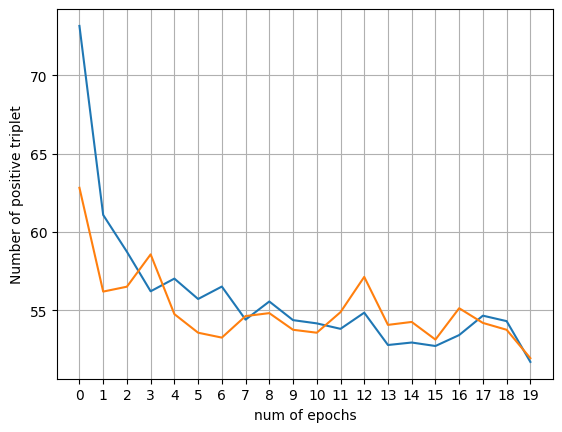

In [ ]:
n_p_plot_val = np.array(n_p_val).reshape(20, 16).mean(1)
n_p_plot_train = np.array(n_p_train).reshape(20, 63).mean(1)
plt.plot([i for i in range(len(n_p_plot_val))], n_p_plot_train, n_p_plot_val)
plt.ylabel('Number of positive triplet')
plt.xlabel('num of epochs')
x = range(0, len(n_p_plot_val), len(n_p_plot_val) // num_epochs)
labels = range(0, num_epochs)
plt.xticks(x, labels)
plt.grid()
plt.show()

In [25]:
import torch.nn.functional as F
def validate(model, val_loader, latent_dim):
    distances_pos = []
    distances_neg = []
    model.eval()

    for i, batch in enumerate(val_loader, 0):
        anc, pos, neg = batch
        output_anc, output_pos, output_neg = model(anc.to(device), pos.to(device), neg.to(device), latent_dim)
        
        distance_pos = F.pairwise_distance(output_anc, output_pos).detach().cpu()
        distance_neg = F.pairwise_distance(output_anc, output_neg).detach().cpu()
        


        distances_pos.append(distance_pos)
        distances_neg.append(distance_neg)
        
    return distances_pos, distances_neg

In [26]:
d_pos, d_neg = validate(model, val_loader, latent_dim = 64)

In [27]:
pos_dist = []
neg_dist = []
for d in d_pos:
  d = d.detach().cpu().numpy()
  pos_dist.append(d)
for d in d_neg:
  d = d.detach().cpu().numpy()
  neg_dist.append(d)

neg_dist = np.concatenate(np.array(neg_dist), axis=0, dtype = object)
pos_dist = np.concatenate(np.array(pos_dist), axis=0, dtype = object )

<ipython-input-27-5922c58f970f>:10: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  neg_dist = np.concatenate(np.array(neg_dist), axis=0, dtype = object)
<ipython-input-27-5922c58f970f>:11: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pos_dist = np.concatenate(np.array(pos_dist), axis=0, dtype = object )


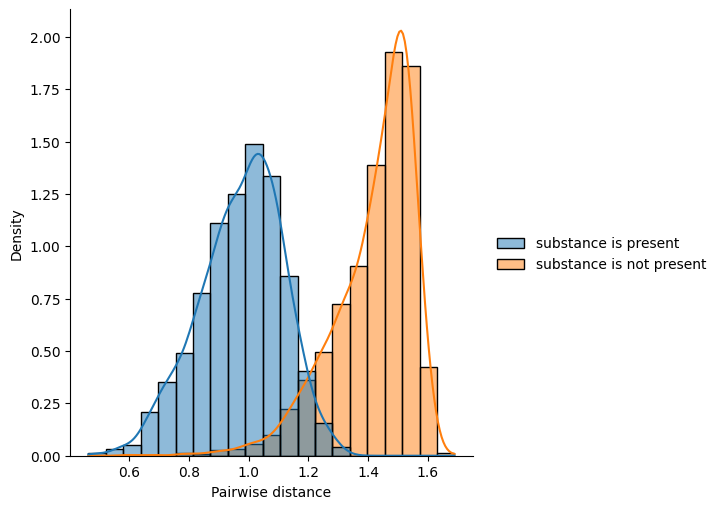

In [ ]:
import seaborn as sns

distances = {"substance is present": pos_dist, "substance is not present": neg_dist}

ax = sns.displot(distances, kde=True, stat="density")
ax.set(xlabel="Pairwise distance")
plt.show()

# Тест (знакомые классы)

In [29]:
def accuracy_(pred, cor):
  accuracy = np.zeros((4))
  total = 0
  for i in range(cor.shape[0]):
    intersect = np.intersect1d(cor[i], pred[i])
    error = len(cor[i]) - len(intersect)
    for j in range(accuracy.shape[0]-error):
      accuracy[j] = accuracy[j] +1
    total = total + 1
  return accuracy/total

In [30]:
x_test = np.load('/content/x_test_red.npy')
y_test = np.load('/content/y_test_red.npy')

In [31]:
x_test = x_test[2000:]
y_test = y_test[2000:]

In [32]:
molecules = []
molecules_embedding = []
label = []
for i in range(400, 500):
  molecules = []
  embedding = np.zeros((20, latent_dim))
  for j in range(0, 20):
    molecule = x_train[20*i + j]/np.max(x_train[20*i + j]) + np.random.normal(0,0.005,5000)
    molecules.append(molecule)
  molecules = np.array(molecules)
  molecules = torch.Tensor(molecules).to(device)
  embedding = embedding + model.predict(molecules).detach().cpu().numpy()
  embedding = np.mean(embedding, axis = 0)
  molecules_embedding.append(embedding/np.linalg.norm(embedding))
  label.append(i)
label = np.array(label)

In [33]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)*(len(label)-3)//2//3//4, 4))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)*(len(label)-3)//2//3//4, 64))
l = 0
for i in range(len(molecules_embedding)):
  for j in range(i+1, len(molecules_embedding)):
    for k in range(j+1, len(molecules_embedding)):
      for m in range(k+1, len(molecules_embedding)):
        emb = molecules_embedding[i] + molecules_embedding[j] + molecules_embedding[k] + molecules_embedding[m]
        mixture_train[l] = emb/np.linalg.norm(emb)
        label_train[l] = np.array([label[i], label[j], label[k], label[m]])
        l = l + 1

In [34]:
mixtures_test = []
correct_test = []
for i in range(0, 500):
  a = x_test[i]
  idxs = np.concatenate((np.arange(x_test[:].shape[0])[0 : i//5 * 5],
                                      np.arange(x_test[:].shape[0])[(i//5 + 1) * 5 :]))
  b_idx = np.random.choice(idxs)
  b = x_test[b_idx]
  c_idx = np.random.choice(idxs)
  c = x_test[c_idx]
  d_idx = np.random.choice(idxs)
  d = x_test[d_idx]
  mixtures_test.append((a+b+c+d)/np.max(a+b+c+d) + np.random.normal(0,0.005,a.shape[0]))
  correct_test.append([y_test[i], y_test[b_idx], y_test[c_idx], y_test[d_idx]])
mixtures_test = torch.Tensor(mixtures_test).to(device)
classification_data_test = model.predict(mixtures_test).detach().cpu().numpy()
correct_test = np.array(correct_test).reshape(-1, 4)

<ipython-input-34-18c6c86903d2>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  mixtures_test = torch.Tensor(mixtures_test).to(device)


In [35]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)

In [36]:
accuracy = accuracy_(preds, correct_test)

In [37]:
print('.....Accuracy.....')
print('1 of 4 ......', accuracy[0])
print('2 of 4 ......', accuracy[1])
print('3 of 4 ......', accuracy[2])
print('4 of 4 ......', accuracy[3])

.....Accuracy.....
1 of 4 ...... 1.0
2 of 4 ...... 0.998
3 of 4 ...... 0.962
4 of 4 ...... 0.822


Каждый класс представлен примерно одинаковое количество раз при формировании выборки используемым способом:

In [ ]:
from collections import Counter
cnt = Counter(correct_test.reshape(-1))
vals = np.fromiter(cnt.values(), dtype = float)
keys = np.fromiter(cnt.keys(), dtype = float)

In [ ]:
coefficient_of_variation = np.std(vals)/np.mean(vals)
coefficient_of_variation

0.200124960961895

<BarContainer object of 100 artists>

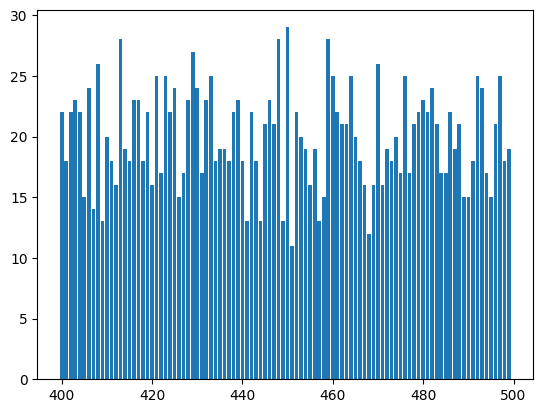

In [ ]:
plt.bar(keys, vals)

# Тест (новые классы)

In [38]:
def accuracy_(pred, cor):
  accuracy = np.zeros((4))
  total = 0
  for i in range(cor.shape[0]):
    intersect = np.intersect1d(cor[i], pred[i])
    error = len(cor[i]) - len(intersect)
    for j in range(accuracy.shape[0]-error):
      accuracy[j] = accuracy[j] +1
    total = total + 1
  return accuracy/total

In [39]:
x_test = np.load('/content/x_test_red.npy')
y_test = np.load('/content/y_test_red.npy')

In [40]:
x_test = x_test[:500]
y_test = y_test[:500]

In [41]:
molecules = []
molecules_embedding = []
label = []
for i in range(0, 100):
  molecules = []
  embedding = np.zeros((20, latent_dim))
  for j in range(0, 20):
    molecule = x_train[20*i + j]/np.max(x_train[20*i + j]) + np.random.normal(0,0.005,5000)
    molecules.append(molecule)
  molecules = np.array(molecules)
  molecules = torch.Tensor(molecules).to(device)
  embedding = embedding + model.predict(molecules).detach().cpu().numpy()
  embedding = np.mean(embedding, axis = 0)
  molecules_embedding.append(embedding/np.linalg.norm(embedding))
  label.append(i)
label = np.array(label)

In [42]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)*(len(label)-3)//2//3//4, 4))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)*(len(label)-3)//2//3//4, 64))
l = 0
for i in range(len(molecules_embedding)):
  for j in range(i+1, len(molecules_embedding)):
    for k in range(j+1, len(molecules_embedding)):
      for m in range(k+1, len(molecules_embedding)):
        emb = molecules_embedding[i] + molecules_embedding[j] + molecules_embedding[k] + molecules_embedding[m]
        mixture_train[l] = emb/np.linalg.norm(emb)
        label_train[l] = np.array([label[i], label[j], label[k], label[m]])
        l = l + 1

In [43]:
mixtures_test = []
correct_test = []
for i in range(0, 500):
  a = x_test[i]
  idxs = np.concatenate((np.arange(x_test[:].shape[0])[0 : i//5 * 5],
                                      np.arange(x_test[:].shape[0])[(i//5 + 1) * 5 :]))
  b_idx = np.random.choice(idxs)
  b = x_test[b_idx]
  c_idx = np.random.choice(idxs)
  c = x_test[c_idx]
  d_idx = np.random.choice(idxs)
  d = x_test[d_idx]
  mixtures_test.append((a+b+c+d)/np.max(a+b+c+d) + np.random.normal(0,0.005,a.shape[0]))
  correct_test.append([y_test[i], y_test[b_idx], y_test[c_idx], y_test[d_idx]])
mixtures_test = torch.Tensor(mixtures_test).to(device)
classification_data_test = model.predict(mixtures_test).detach().cpu().numpy()
correct_test = np.array(correct_test).reshape(-1, 4)

In [44]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)

In [45]:
accuracy = accuracy_(preds, correct_test)

In [ ]:
print('.....Accuracy.....')
print('1 of 4 ......', accuracy[0])
print('2 of 4 ......', accuracy[1])
print('3 of 4 ......', accuracy[2])
print('4 of 4 ......', accuracy[3])

.....Accuracy.....
1 of 4 ...... 1.0
2 of 4 ...... 0.986
3 of 4 ...... 0.928
4 of 4 ...... 0.722


# Тест (неравные количества компонентов в смесях)

In [ ]:
def accuracy_(pred, cor):
  accuracy = np.zeros((4))
  total = 0
  for i in range(cor.shape[0]):
    intersect = np.intersect1d(cor[i], pred[i])
    error = len(cor[i]) - len(intersect)
    for j in range(accuracy.shape[0]-error):
      accuracy[j] = accuracy[j] +1
    total = total + 1
  return accuracy/total

In [ ]:
x_test = np.load('/content/x_test_red.npy')
y_test = np.load('/content/y_test_red.npy')

In [ ]:
x_test = x_test[:500]
y_test = y_test[:500]

In [ ]:
molecules = []
molecules_embedding = []
label = []
for i in range(0, 100):
  molecules = []
  embedding = np.zeros((20, latent_dim))
  for j in range(0, 20):
    molecule = x_train[20*i + j]/np.max(x_train[20*i + j])
    molecules.append(molecule)
  molecules = np.array(molecules)
  molecules = torch.Tensor(molecules).to(device)
  embedding = embedding + model.predict(molecules).detach().cpu().numpy()
  embedding = np.mean(embedding, axis = 0)
  molecules_embedding.append(embedding/np.linalg.norm(embedding))
  label.append(i)
label = np.array(label)

In [ ]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)*(len(label)-3)//2//3//4, 4))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)*(len(label)-3)//2//3//4, 64))
l = 0
for i in range(len(molecules_embedding)):
  for j in range(i+1, len(molecules_embedding)):
    for k in range(j+1, len(molecules_embedding)):
      for m in range(k+1, len(molecules_embedding)):
        emb = molecules_embedding[i] + molecules_embedding[j] + molecules_embedding[k] + molecules_embedding[m]
        mixture_train[l] = emb/np.linalg.norm(emb)
        label_train[l] = np.array([label[i], label[j], label[k], label[m]])
        l = l + 1

In [ ]:
mixtures_test = []
correct_test = []
for i in range(0, 500):
  a = 0.15*x_test[i]
  idxs = np.concatenate((np.arange(x_test[:].shape[0])[0 : i//5 * 5],
                                      np.arange(x_test[:].shape[0])[(i//5 + 1) * 5 :]))
  b_idx = np.random.choice(idxs)
  b = 0.22*x_test[b_idx]
  c_idx = np.random.choice(idxs)
  c = 0.23*x_test[c_idx]
  d_idx = np.random.choice(idxs)
  d = 0.4*x_test[d_idx]
  mixtures_test.append((a+b+c+d)/np.max(a+b+c+d) + np.random.normal(0,0.005,a.shape[0]))
  correct_test.append([y_test[i], y_test[b_idx], y_test[c_idx], y_test[d_idx]])
mixtures_test = torch.Tensor(mixtures_test).to(device)
classification_data_test = model.predict(mixtures_test).detach().cpu().numpy()
correct_test = np.array(correct_test).reshape(-1, 4)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)

In [ ]:
accuracy = accuracy_(preds, correct_test)

In [ ]:
print('.....Accuracy.....')
print('1 of 4 ......', accuracy[0])
print('2 of 4 ......', accuracy[1])
print('3 of 4 ......', accuracy[2])
print('4 of 4 ......', accuracy[3])

.....Accuracy.....
1 of 4 ...... 0.996
2 of 4 ...... 0.942
3 of 4 ...... 0.726
4 of 4 ...... 0.398


# Бинарные смеси

In [47]:
def accuracy_(pred, cor):
  accuracy = np.zeros((2))
  total = 0
  for i in range(cor.shape[0]):
    intersect = np.intersect1d(cor[i], pred[i])
    error = len(cor[i]) - len(intersect)
    for j in range(accuracy.shape[0]-error):
      accuracy[j] = accuracy[j] +1
    total = total + 1
  return accuracy/total

In [48]:
x_test = np.load('/content/x_test_red.npy')
y_test = np.load('/content/y_test_red.npy')

In [49]:
x_test = x_test[:500]
y_test = y_test[:500]

In [50]:
molecules = []
molecules_embedding = []
label = []
for i in range(0, 100):
  molecules = []
  embedding = np.zeros((20, latent_dim))
  for j in range(0, 20):
    molecule = x_train[20*i + j]/np.max(x_train[20*i + j]) + np.random.normal(0,0.005,5000)
    molecules.append(molecule)
  molecules = np.array(molecules)
  molecules = torch.Tensor(molecules).to(device)
  embedding = embedding + model.predict(molecules).detach().cpu().numpy()
  embedding = np.mean(embedding, axis = 0)
  molecules_embedding.append(embedding/np.linalg.norm(embedding))
  label.append(i)
label = np.array(label)

In [51]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)//2, 2))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)//2, 64))
l = 0
for i in range(len(molecules_embedding)):
  for j in range(i+1, len(molecules_embedding)):
    emb = molecules_embedding[i] + molecules_embedding[j] 
    mixture_train[l] = emb/np.linalg.norm(emb)
    label_train[l] = np.array([label[i], label[j]])
    l = l + 1

In [52]:
mixtures_test = []
correct_test = []
for i in range(0, 500):
  a = x_test[i]
  idxs = np.concatenate((np.arange(x_test[:].shape[0])[0 : i//5 * 5],
                                      np.arange(x_test[:].shape[0])[(i//5 + 1) * 5 :]))
  b_idx = np.random.choice(idxs)
  b = x_test[b_idx]
  mixtures_test.append((a+b)/np.max(a+b) + np.random.normal(0,0.005,a.shape[0]))
  correct_test.append([y_test[i], y_test[b_idx]])
mixtures_test = torch.Tensor(mixtures_test).to(device)
classification_data_test = model.predict(mixtures_test).detach().cpu().numpy()
correct_test = np.array(correct_test).reshape(-1, 2)

In [53]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)

In [54]:
accuracy = accuracy_(preds, correct_test)

In [55]:
print('.....Accuracy.....')
print('1 of 2 ......', accuracy[0])
print('2 of 2 ......', accuracy[1])

.....Accuracy.....
1 of 2 ...... 0.998
2 of 2 ...... 0.966


# Тройные смеси

In [56]:
def accuracy_(pred, cor):
  accuracy = np.zeros((3))
  total = 0
  for i in range(cor.shape[0]):
    intersect = np.intersect1d(cor[i], pred[i])
    error = len(cor[i]) - len(intersect)
    for j in range(accuracy.shape[0]-error):
      accuracy[j] = accuracy[j] +1
    total = total + 1
  return accuracy/total

In [57]:
x_test = np.load('/content/x_test_red.npy')
y_test = np.load('/content/y_test_red.npy')

In [58]:
x_test = x_test[:500]
y_test = y_test[:500]

In [59]:
molecules = []
molecules_embedding = []
label = []
for i in range(0, 100):
  molecules = []
  embedding = np.zeros((20, latent_dim))
  for j in range(0, 20):
    molecule = x_train[20*i + j]/np.max(x_train[20*i + j]) + np.random.normal(0,0.005,5000)
    molecules.append(molecule)
  molecules = np.array(molecules)
  molecules = torch.Tensor(molecules).to(device)
  embedding = embedding + model.predict(molecules).detach().cpu().numpy()
  embedding = np.mean(embedding, axis = 0)
  molecules_embedding.append(embedding/np.linalg.norm(embedding))
  label.append(i)
label = np.array(label)

In [60]:
label_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)//2//3, 3))
mixture_train = np.zeros(shape = (len(label)*(len(label)-1)*(len(label) - 2)//2//3, 64))
l = 0
for i in range(len(molecules_embedding)):
  for j in range(i+1, len(molecules_embedding)):
    for k in range(j+1, len(molecules_embedding)):
      emb = molecules_embedding[i] + molecules_embedding[j] + molecules_embedding[k]
      mixture_train[l] = emb/np.linalg.norm(emb)
      label_train[l] = np.array([label[i], label[j], label[k]])
      l = l + 1

In [61]:
mixtures_test = []
correct_test = []
for i in range(0, 500):
  a = x_test[i]
  idxs = np.concatenate((np.arange(x_test[:].shape[0])[0 : i//5 * 5],
                                      np.arange(x_test[:].shape[0])[(i//5 + 1) * 5 :]))
  b_idx = np.random.choice(idxs)
  b = x_test[b_idx]
  c_idx = np.random.choice(idxs)
  c = x_test[c_idx]
  mixtures_test.append((a+b+c)/np.max(a+b+c) + np.random.normal(0,0.005,a.shape[0]))
  correct_test.append([y_test[i], y_test[b_idx], y_test[c_idx]])
mixtures_test = torch.Tensor(mixtures_test).to(device)
classification_data_test = model.predict(mixtures_test).detach().cpu().numpy()
correct_test = np.array(correct_test).reshape(-1, 3)

In [62]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(mixture_train, label_train)
preds = neigh.predict(classification_data_test)

In [63]:
accuracy = accuracy_(preds, correct_test)

In [64]:
print('.....Accuracy.....')
print('1 of 3 ......', accuracy[0])
print('2 of 3 ......', accuracy[1])
print('3 of 3 ......', accuracy[2])

.....Accuracy.....
1 of 3 ...... 1.0
2 of 3 ...... 0.994
3 of 3 ...... 0.868


# Explainability


Рассмотрим feature map на последнем сверточном слое модели.

In [65]:
print(model)

SiameseNet(
  (model): Sequential(
    (0): Conv1d(1, 16, kernel_size=(21,), stride=(1,), padding=same)
    (1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): LeakyReLU(negative_slope=0.01)
    (3): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Conv1d(16, 32, kernel_size=(11,), stride=(1,), padding=same)
    (5): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): LeakyReLU(negative_slope=0.01)
    (7): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Conv1d(32, 64, kernel_size=(5,), stride=(1,), padding=same)
    (9): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): LeakyReLU(negative_slope=0.01)
    (11): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=40000, out_features=64, bias=True)
  )
)


In [66]:
class ForwardHook():
    def __init__(self, layer):
        self.hook = layer.register_forward_hook(self.hook_func)

    def hook_func(self, layer, input_, output): 
        self.activation = output.detach().clone()

    def __enter__(self, *args): 
        return self

    def __exit__(self, *args): 
      self.hook.remove()

In [67]:
anchor, positive, negative  = next(iter(train_loader))

In [68]:
anchor, positive, negative = anchor[0], positive[0], negative[0]

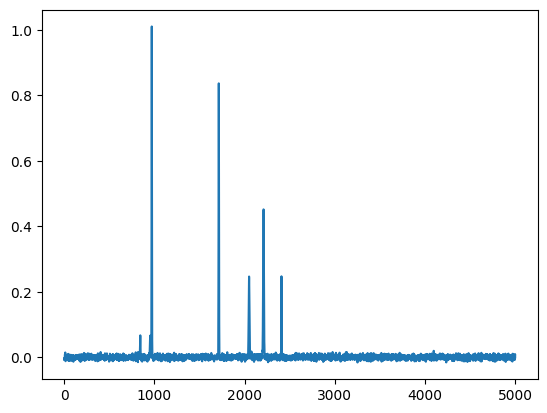

In [69]:
plt.plot(positive.detach().cpu().numpy())

In [70]:
with ForwardHook(model.model[8]) as forward_hook:
    output = model._forward(positive.to(device))
    activation_positive_trained = forward_hook.activation

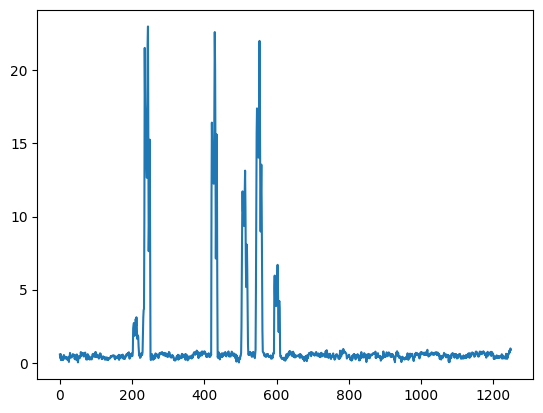

In [72]:
plt.plot(activation_positive_trained.detach().cpu().numpy()[0][0])